# Analyse de données Strava - Speed

Ce notebook permet une analyse exploratoire des données que l'on possède en réalisant un focus sur l'allure lors des courses d'Anto (colonne enhanced_speed). L'objectif est de reprendre les éléments du cours afin de déterminer les trends, la saisonnalité, les fréquences, les motifs et patterns répétés, etc.

# 1- Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import stumpy
from ruptures import Binseg, Pelt, KernelCPD
import ruptures as rpt
from scipy.fft import fft, fftfreq
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
import numpy as np
from scipy.spatial.distance import euclidean
warnings.filterwarnings("ignore")


✅ Bibliothèques importées avec succès


# 2- Data Cleaning et Preprocessing

In [ ]:
def fix_gotoes_header(filepath):
    """
    Corrige les CSV Garmin exportés avec un header décalé (colonne 'GOTOES_CSV').
    → Décale tous les noms de colonnes d’un cran vers la gauche.
    """
    df = pd.read_csv(filepath, header=0)
    
    if df.columns[0] == 'GOTOES_CSV':
        print(f"⚙️ Correction du header 'GOTOES_CSV' dans {filepath.split('\\')[-1]}")
        new_cols = df.columns[1:].tolist() + ['extra_col']
        df.columns = new_cols
    return df

In [ ]:
marathon1 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\marathon_1.csv")
marathon2 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\marathon_2.csv")
semi1 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_1.csv")
semi2 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_2.csv")
semi3 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_3.csv")
dix1 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\10k_1.csv")
dix2 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\10k_2.csv")

⚙️ Correction du header 'GOTOES_CSV' dans marathon_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans marathon_2.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_2.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_3.csv
⚙️ Correction du header 'GOTOES_CSV' dans 10k_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans 10k_2.csv
✅ Nouvelles colonnes : ['timestamp', 'position_lat', 'position_long', 'altitude', 'heart_rate', 'cadence', 'distance', 'speed', 'power', 'compressed_speed_distance']


In [ ]:
def prepare_course(df, course_name):
    """
    Nettoie et prépare les données Garmin avec les bonnes unités :
      - Supprime les lignes invalides
      - Convertit les colonnes en unités cohérentes
      - Filtre les valeurs aberrantes
    """
    cols = ['distance', 'stance_time', 'vertical_oscillation', 'step_length',
            'enhanced_speed', 'heart_rate', 'enhanced_altitude', 'timestamp',
            'cadence', 'distance', 'speed','altitude', 'power', 'enhanced_altitude', 'vertical_ratio']

    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"❌ Colonnes manquantes dans {course_name}: {missing}")

    df = df[cols].copy()

    df = df[df['stance_time'] <= 1500]

    df['vertical_oscillation'] = df['vertical_oscillation'] / 10.0

    df['step_length'] = df['step_length'] / 1000.0

    df = df[df['enhanced_speed'] > 0]

    print(f"✅ {course_name} : {len(df)} lignes valides après nettoyage")
    return df


marathon1_clean = prepare_course(marathon1, "Marathon 1")
marathon2_clean = prepare_course(marathon2, "Marathon 2")
semi1_clean = prepare_course(semi1, "Semi 1")
semi2_clean = prepare_course(semi2, "Semi 2")
semi3_clean = prepare_course(semi3, "Semi 3")
dix1_clean = prepare_course(dix1, "10k 1")
dix2_clean = prepare_course(dix2, "10k 2")


print("🔍 DIAGNOSTIC DU NETTOYAGE:")
print(f"  Données de départ: {len(marathon1_clean)} lignes")
target_col = 'enhanced_speed'

marathon1_clean[target_col] = pd.to_numeric(marathon1_clean[target_col], errors='coerce')
print(f"  Après conversion numérique: {marathon1_clean[target_col].notna().sum()} valeurs non-nulles")

if 'timestamp' in marathon1_clean.columns:
    print(f"  Colonne 'timestamp' présente: {marathon1_clean['timestamp'].notna().sum()} valeurs non-nulles")
    print(f"  Exemple de valeur timestamp: {marathon1_clean['timestamp'].iloc[0]}")
else:
    print(f"  ❌ Colonne 'timestamp' ABSENTE!")

print(f"\n✅ Nettoyage effectué:")
print(f"  - Lignes avant: {len(marathon1_clean)}")
print(f"  - Lignes après: {len(marathon1_clean)}")
print(f"  - Lignes supprimées: {len(marathon1_clean) - len(marathon1_clean)}")

if 'timestamp' in marathon1_clean.columns:
    print(f"\n🔍 Création de l'index temporel avec 'timestamp'...")
    ts_data = marathon1_clean[['timestamp', target_col]].copy()
    print(f"  Après sélection colonnes: {len(ts_data)} lignes")
    ts_data = ts_data.dropna()
    print(f"  Après dropna initial: {len(ts_data)} lignes")
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    print(f"  Après conversion datetime: {ts_data['timestamp'].notna().sum()} timestamps valides")
    ts_data = ts_data.dropna()
    print(f"  Après dropna final: {len(ts_data)} lignes")
    
    ts_data = ts_data.set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
    if len(ts_data) > 0:
        print(f"\n⏱️ Plage temporelle de la série :")
        print(f"  Début : {ts_data.index.min()}")
        print(f"  Fin   : {ts_data.index.max()}")
        print(f"  Durée totale : {ts_data.index.max() - ts_data.index.min()}")

    
elif 'timestamp' in marathon1_clean.columns:
    ts_data = marathon1_clean[['timestamp', target_col]].dropna().copy()
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    ts_data = ts_data.dropna().set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
else:
    ts_data = marathon1_clean[[target_col]].dropna().copy()
    ts_data.index = range(len(ts_data))
    print(f"\n✅ Index temporel numérique créé")

print(f"\n{'='*60}")
print(f"RÉSULTAT FINAL: {len(ts_data)} points valides")
print(f"{'='*60}")

if len(ts_data) > 0:
    print(f"\nPremières valeurs de la série:")
    print(ts_data.head())
    print(f"\nStatistiques descriptives:")
    print(ts_data[target_col].describe())
else:
    print("⚠️ ATTENTION: Aucune donnée valide après nettoyage!")
    print("Vérifiez les étapes de diagnostic ci-dessus.")

# Analyse des courses et décomposition

## Semi 1

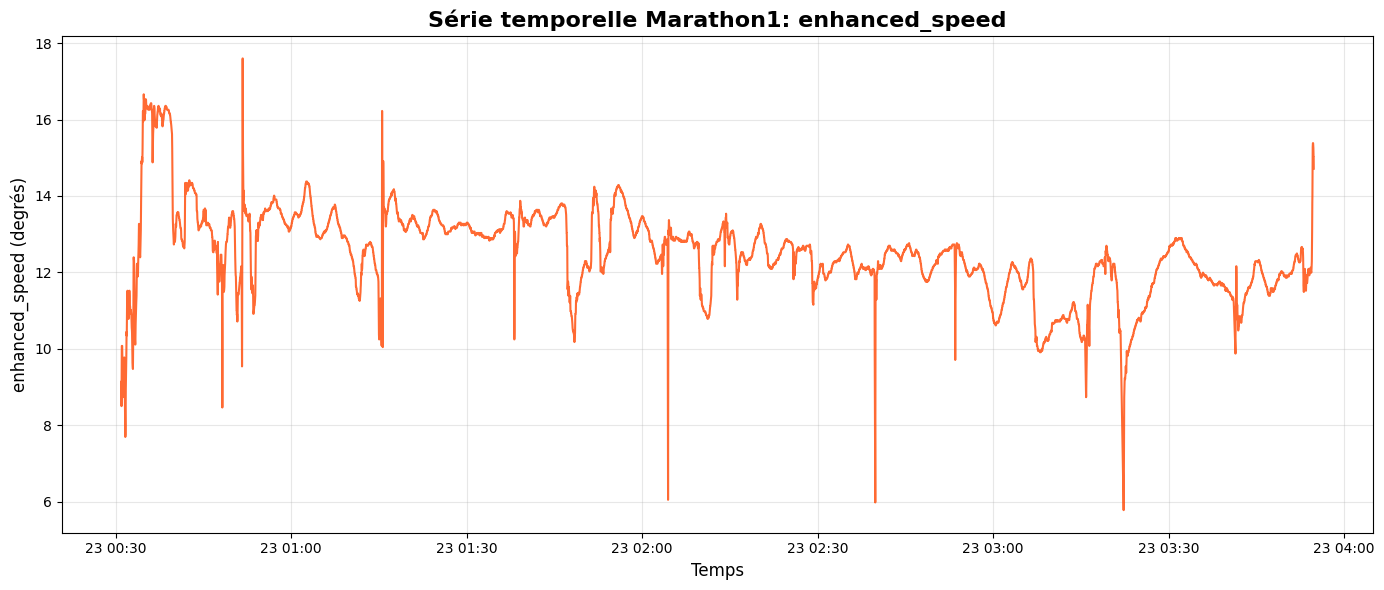

📈 Graphique de la série temporelle affiché


In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(ts_data.index, ts_data[target_col], color='orangered', linewidth=1.5, alpha=0.8)
plt.title(f'Série temporelle Marathon1: {target_col}', fontsize=16, fontweight='bold')
plt.xlabel('Temps', fontsize=12)
plt.ylabel(f'{target_col} (degrés)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

STATISTIQUES DESCRIPTIVES MARATHON1
Moyenne        : 12.5212°
Médiane        : 12.5280°
Écart-type     : 1.1390°
Min            : 5.7780°
Max            : 17.6000°
Q1 (25%)       : 11.9230°
Q3 (75%)       : 13.2010°


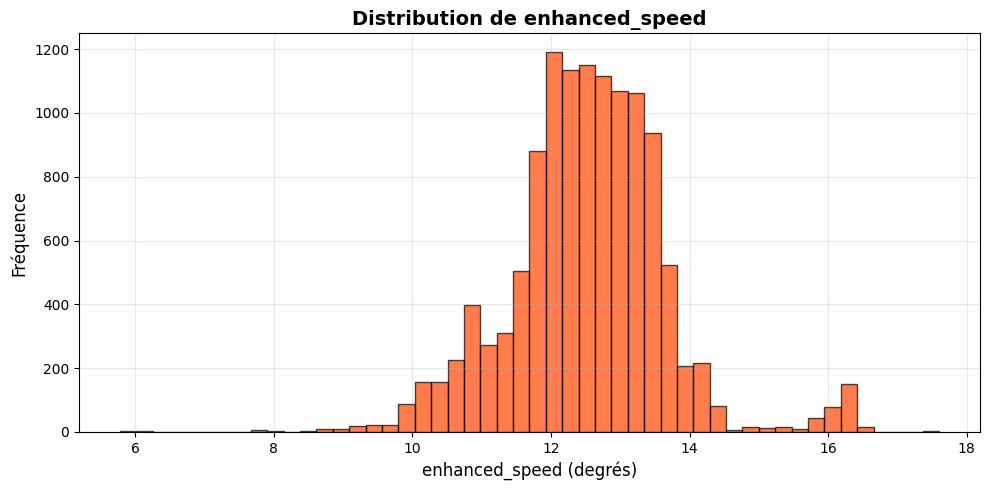

In [ ]:
print("=" * 60)
print("STATISTIQUES DESCRIPTIVES MARATHON1")
print("=" * 60)

stats = {
    'Moyenne': ts_data[target_col].mean(),
    'Médiane': ts_data[target_col].median(),
    'Écart-type': ts_data[target_col].std(),
    'Min': ts_data[target_col].min(),
    'Max': ts_data[target_col].max(),
    'Q1 (25%)': ts_data[target_col].quantile(0.25),
    'Q3 (75%)': ts_data[target_col].quantile(0.75)
}

for key, value in stats.items():
    print(f"{key:15s}: {value:.4f}°")

plt.figure(figsize=(10, 5))
plt.hist(ts_data[target_col], bins=50, color='orangered', edgecolor='black', alpha=0.7)
plt.title(f'Distribution de {target_col}', fontsize=14, fontweight='bold')
plt.xlabel(f'{target_col} (degrés)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

🔄 Décomposition STL en cours...


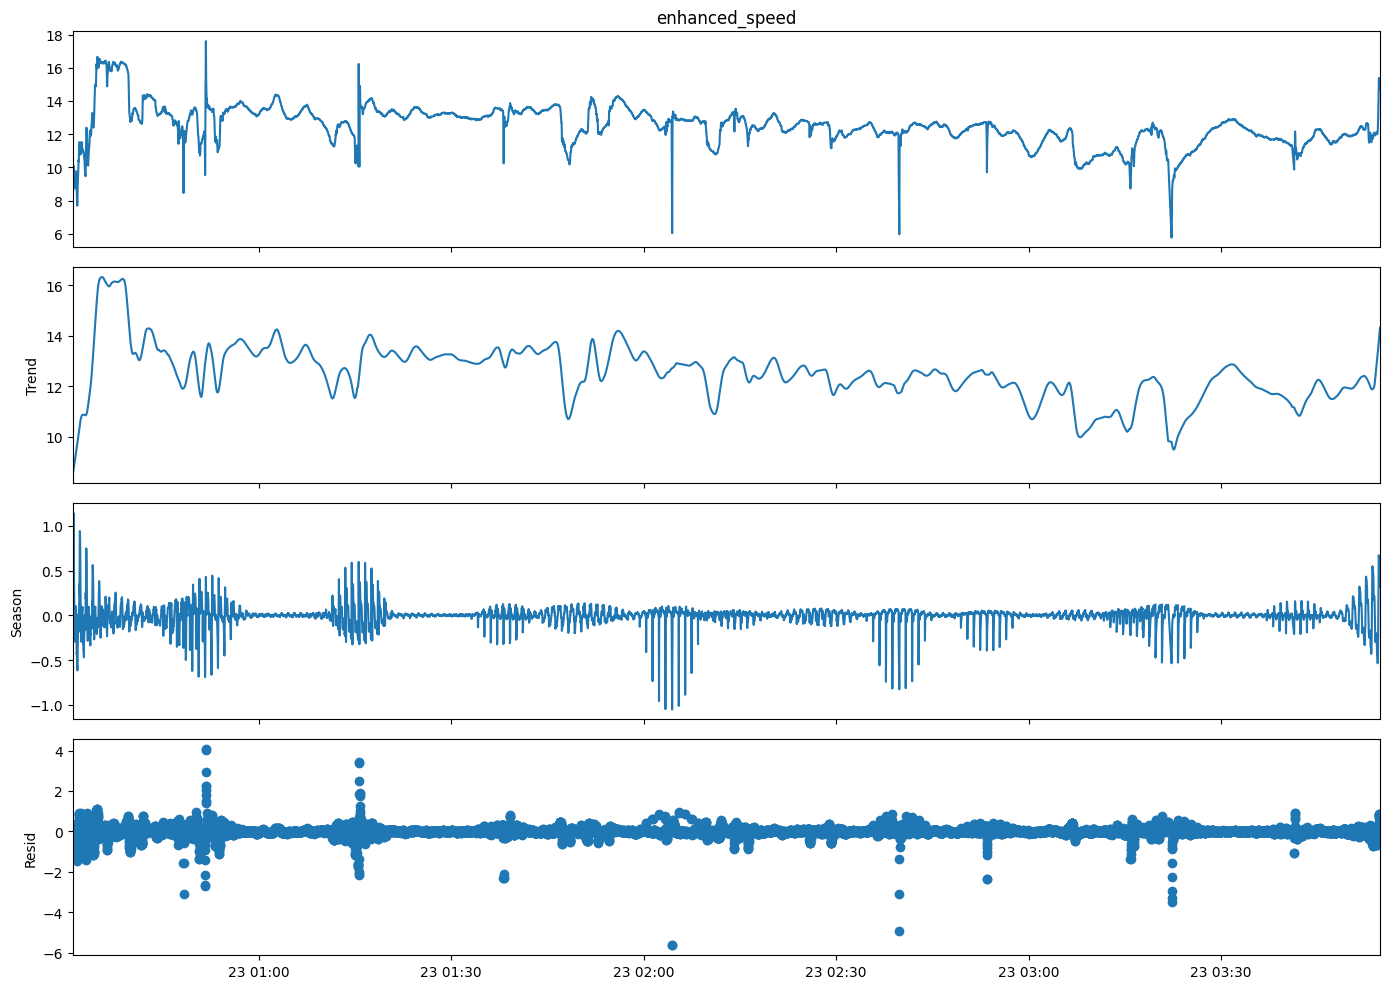

✅ Décomposition STL effectuée (période=60)


In [ ]:
if len(ts_data) >= 100:
    print("🔄 Décomposition STL en cours...")
    
    # Définition de 60 afin de remettre une granularité à la minute
    period = min(60, len(ts_data) // 3)
    
    stl = STL(ts_data[target_col], period=period, seasonal=13)
    result = stl.fit()
    
    fig = result.plot()
    fig.set_size_inches(14, 10)
    plt.tight_layout()
    plt.show()

In [ ]:
print("=" * 60)
print("TEST DE STATIONNARITÉ (ADF)")
print("=" * 60)

result_adf = adfuller(ts_data[target_col].dropna())

print(f"\nStatistique ADF: {result_adf[0]:.6f}")
print(f"P-value: {result_adf[1]:.6f}")
print(f"\nValeurs critiques:")
for key, value in result_adf[4].items():
    print(f"  {key}: {value:.3f}")
if result_adf[1] < 0.05:
    print(f"\n✅ La série est STATIONNAIRE (p-value < 0.05)")
else:
    print(f"\n⚠️ La série est NON-STATIONNAIRE (p-value >= 0.05)")
    print("   → Considérer une différenciation ou une transformation")

TEST DE STATIONNARITÉ (ADF)

Statistique ADF: -5.070116
P-value: 0.000016

Valeurs critiques:
  1%: -3.431
  5%: -2.862
  10%: -2.567

✅ La série est STATIONNAIRE (p-value < 0.05)


📊 Calcul et affichage des fonctions d’autocorrélation...


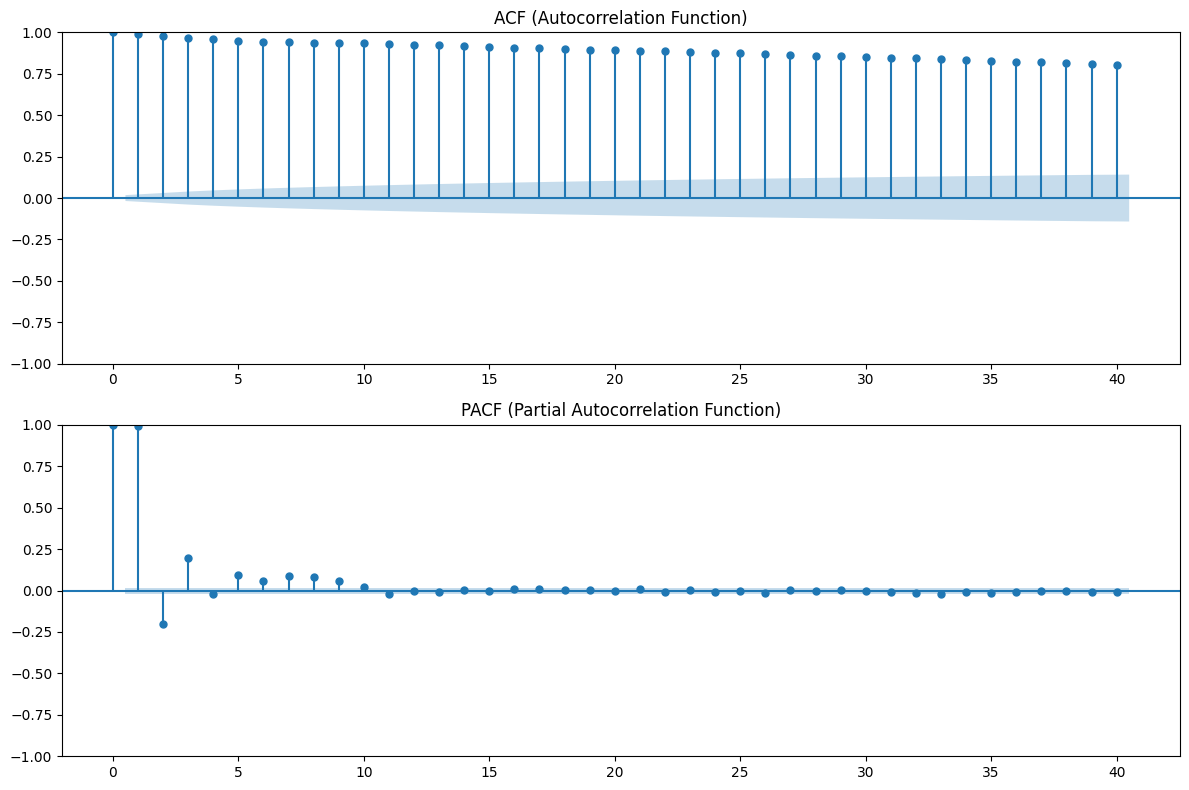

In [ ]:
if len(ts_data) > 30:
    print("📊 Calcul et affichage des fonctions d’autocorrélation...")
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    plot_acf(ts_data[target_col].dropna(), ax=ax[0], lags=40)
    ax[0].set_title("ACF (Autocorrelation Function)")
    
    plot_pacf(ts_data[target_col].dropna(), ax=ax[1], lags=40, method='ywm')
    ax[1].set_title("PACF (Partial Autocorrelation Function)")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Série trop courte pour ACF/PACF fiables.")


🔍 Détection des points de rupture dans la série...


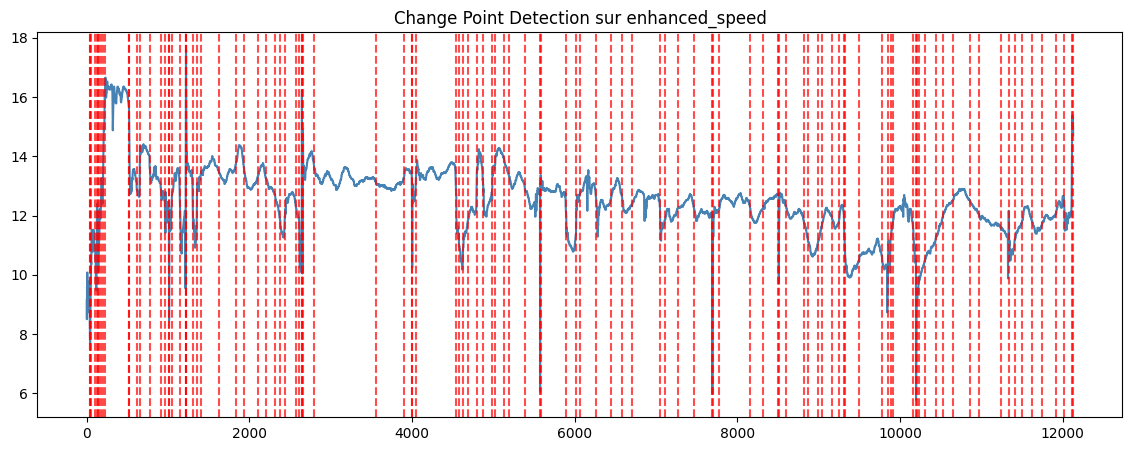

✅ 110 ruptures détectées aux indices : [35, 45, 55, 105, 125, 135, 155, 175, 205, 220, 520, 525, 615, 650, 775, 910, 960, 1010, 1015, 1045, 1145, 1215, 1220, 1225, 1305, 1355, 1400, 1620, 1835, 1935, 2100, 2210, 2320, 2375, 2440, 2570, 2615, 2645, 2650, 2655, 2800, 3560, 3895, 4000, 4005, 4045, 4545, 4580, 4630, 4685, 4795, 4875, 4985, 5025, 5135, 5190, 5390, 5570, 5580, 5895, 6020, 6070, 6260, 6450, 6585, 6710, 7050, 7105, 7265, 7470, 7690, 7695, 7780, 8160, 8315, 8505, 8515, 8600, 8820, 8870, 8995, 9045, 9170, 9255, 9315, 9330, 9500, 9780, 9855, 9885, 9915, 10165, 10195, 10205, 10230, 10305, 10440, 10525, 10650, 10860, 10975, 11240, 11345, 11410, 11505, 11620, 11750, 11925, 12020, 12115]


In [ ]:
print("🔍 Détection des points de rupture dans la série...")

signal = ts_data[target_col].dropna().values

# On peut utiliser Pelt (rapide et précis)
model = "l2"  # distance L2 (euclidienne)
algo = rpt.Pelt(model=model).fit(signal)

# On fixe un seuil de pénalité (ajuste la sensibilité)
result = algo.predict(pen=5)

plt.figure(figsize=(14, 5))
plt.plot(signal, color='steelblue')
for cp in result:
    plt.axvline(cp, color='red', linestyle='--', alpha=0.7)
plt.title(f"Change Point Detection sur {target_col}")
plt.show()

print(f"✅ {len(result)-1} ruptures détectées aux indices : {result[:-1]}")

🌊 Analyse fréquentielle (Transformée de Fourier)


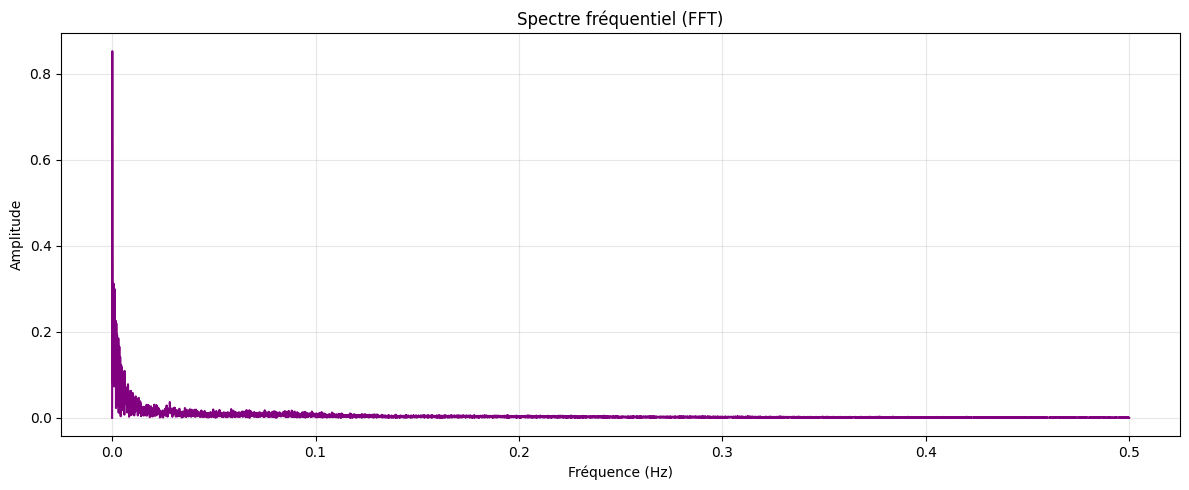

In [ ]:
print("🌊 Analyse fréquentielle (Transformée de Fourier)")

y = ts_data[target_col].dropna().values
n = len(y)
timestep = 1  #1 échantillon par seconde

yf = fft(y - np.mean(y))  
xf = fftfreq(n, timestep)[:n//2]  

# Spectre de puissance
plt.figure(figsize=(12, 5))
plt.plot(xf, 2.0/n * np.abs(yf[:n//2]), color='purple')
plt.title("Spectre fréquentiel (FFT)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


📉 Calcul des critères d’information (AIC / BIC) via modèle ARIMA...
AIC : -12193.6748
BIC : -12164.0607
L1-norm (somme des valeurs absolues) : 380.4356
L2-norm (norme quadratique) : 16.4621


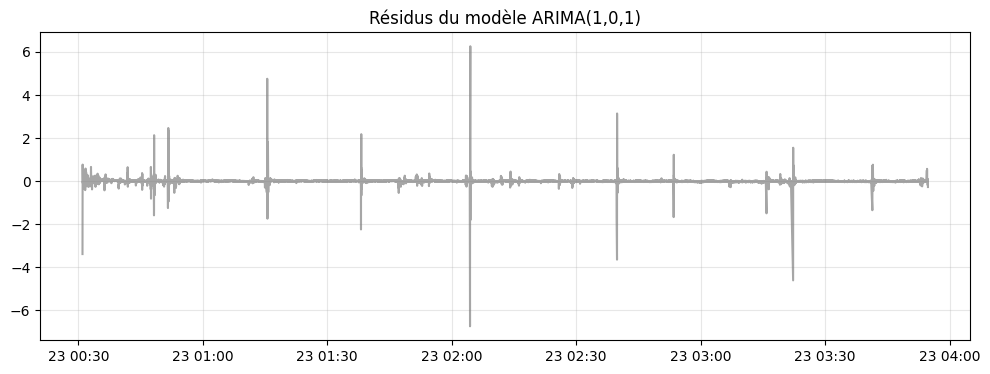

In [ ]:
print("📉 Calcul des critères d’information (AIC / BIC) via modèle ARIMA...")

# On tente un modèle simple ARIMA(1,0,1)
try:
    model = ARIMA(ts_data[target_col].dropna(), order=(1, 0, 1))
    result = model.fit()
    
    print(f"AIC : {result.aic:.4f}")
    print(f"BIC : {result.bic:.4f}")
    print(f"L1-norm (somme des valeurs absolues) : {np.sum(np.abs(result.resid)):.4f}")
    print(f"L2-norm (norme quadratique) : {np.sqrt(np.sum(result.resid**2)):.4f}")
    
    plt.figure(figsize=(12, 4))
    plt.plot(result.resid, color='gray', alpha=0.7)
    plt.title("Résidus du modèle ARIMA(1,0,1)")
    plt.grid(True, alpha=0.3)
    plt.show()
except Exception as e:
    print(f"❌ Erreur lors de l’ajustement du modèle ARIMA : {e}")


🔁 Autocorrélation globale sur la série...


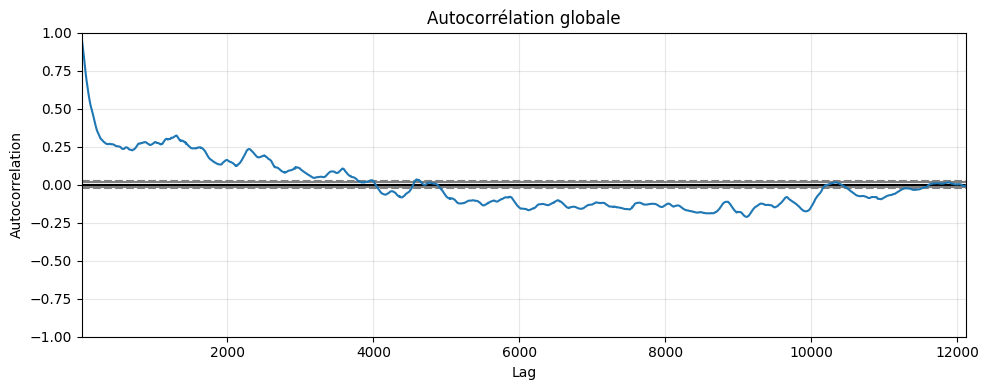

In [ ]:
print("🔁 Autocorrélation globale sur la série...")

plt.figure(figsize=(10, 4))
autocorrelation_plot(ts_data[target_col])
plt.title("Autocorrélation globale")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Deux segments de taille égale
y = ts_data[target_col].dropna().values
n = len(y) // 2
segment1, segment2 = y[:n], y[n:2*n]

# Distance Euclidienne
dist_euclid = euclidean(segment1[:min(len(segment1), len(segment2))],
                        segment2[:min(len(segment1), len(segment2))])
print(f"📏 Distance euclidienne entre les deux segments : {dist_euclid:.4f}")


📏 Distance euclidienne entre les deux segments : 143.9794


🔍 Calcul du Matrix Profile pour la détection de motifs...
🏁 Motif principal trouvé à l’indice 8995


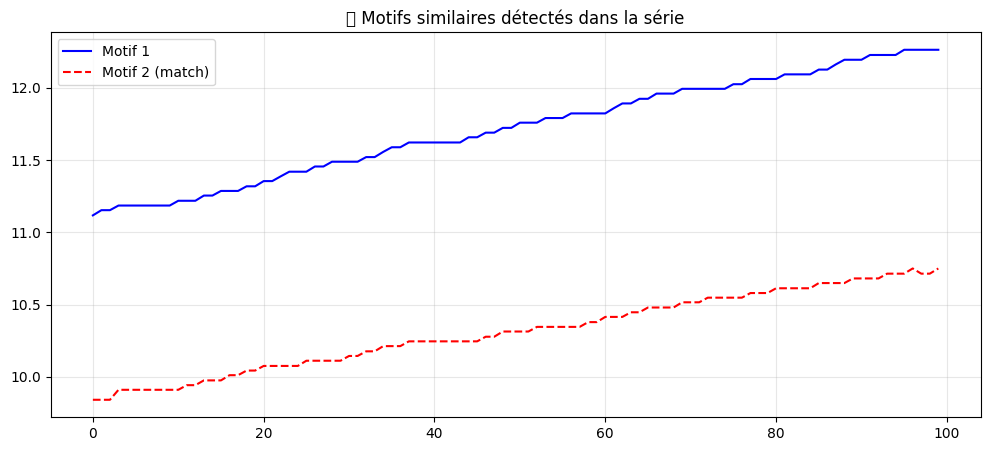

In [ ]:
print("🔍 Calcul du Matrix Profile pour la détection de motifs...")

series = ts_data[target_col].dropna().values.astype(float)

m = 100  

# Calcul du Matrix Profile
mp = stumpy.stump(series, m=m)

# mp[:, 0] contient les valeurs du profil (distance minimale pour chaque sous-séquence)
# Trouvons le motif le plus récurrent (plus petite distance)
motif_idx = np.argmin(mp[:, 0])
print(f"🏁 Motif principal trouvé à l’indice {motif_idx}")

# On récupère le motif et son match le plus proche
motif1 = series[motif_idx:motif_idx+m]
motif2 = series[int(mp[motif_idx, 1]):int(mp[motif_idx, 1])+m]

plt.figure(figsize=(12, 5))
plt.plot(motif1, label='Motif 1', color='blue')
plt.plot(motif2, label='Motif 2 (match)', color='red', linestyle='--')
plt.title("🔍 Motifs similaires détectés dans la série")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


⚠️ Discord (anomalie potentielle) détectée à l’indice 9945


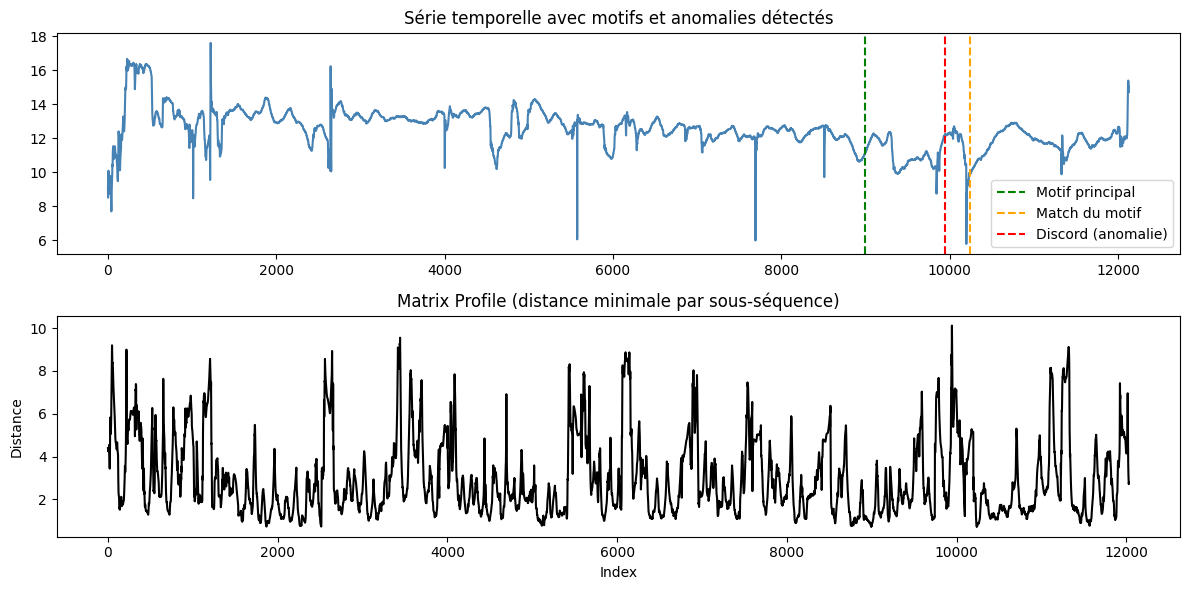

In [ ]:
# Discord = sous-séquence la plus éloignée de toutes les autres
discord_idx = np.argmax(mp[:, 0])
print(f"⚠️ Discord (anomalie potentielle) détectée à l’indice {discord_idx}")

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(series, color='steelblue')
plt.axvline(motif_idx, color='green', linestyle='--', label='Motif principal')
plt.axvline(int(mp[motif_idx,1]), color='orange', linestyle='--', label='Match du motif')
plt.axvline(discord_idx, color='red', linestyle='--', label='Discord (anomalie)')
plt.title("Série temporelle avec motifs et anomalies détectés")
plt.legend()

plt.subplot(2,1,2)
plt.plot(mp[:,0], color='black')
plt.title("Matrix Profile (distance minimale par sous-séquence)")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


## Marathon 1

🔍 DIAGNOSTIC DU NETTOYAGE:
  Données de départ: 12131 lignes
  Après conversion numérique: 12131 valeurs non-nulles
  Colonne 'timestamp' présente: 12131 valeurs non-nulles
  Exemple de valeur timestamp: 2024-11-23T00:31:00

✅ Nettoyage effectué:
  - Lignes avant: 12131
  - Lignes après: 12131
  - Lignes supprimées: 0

🔍 Création de l'index temporel avec 'timestamp'...
  Après sélection colonnes: 12131 lignes
  Après dropna initial: 12131 lignes
  Après conversion datetime: 12131 timestamps valides
  Après dropna final: 12131 lignes

✅ Index temporel basé sur 'timestamp'

⏱️ Plage temporelle de la série :
  Début : 2024-11-23 00:31:00
  Fin   : 2024-11-23 03:54:48
  Durée totale : 0 days 03:23:48

RÉSULTAT FINAL: 12131 points valides

Premières valeurs de la série:
                     enhanced_speed
timestamp                          
2024-11-23 00:31:00           9.137
2024-11-23 00:31:01           8.500
2024-11-23 00:31:02           9.137
2024-11-23 00:31:03           9.742
2024-11-

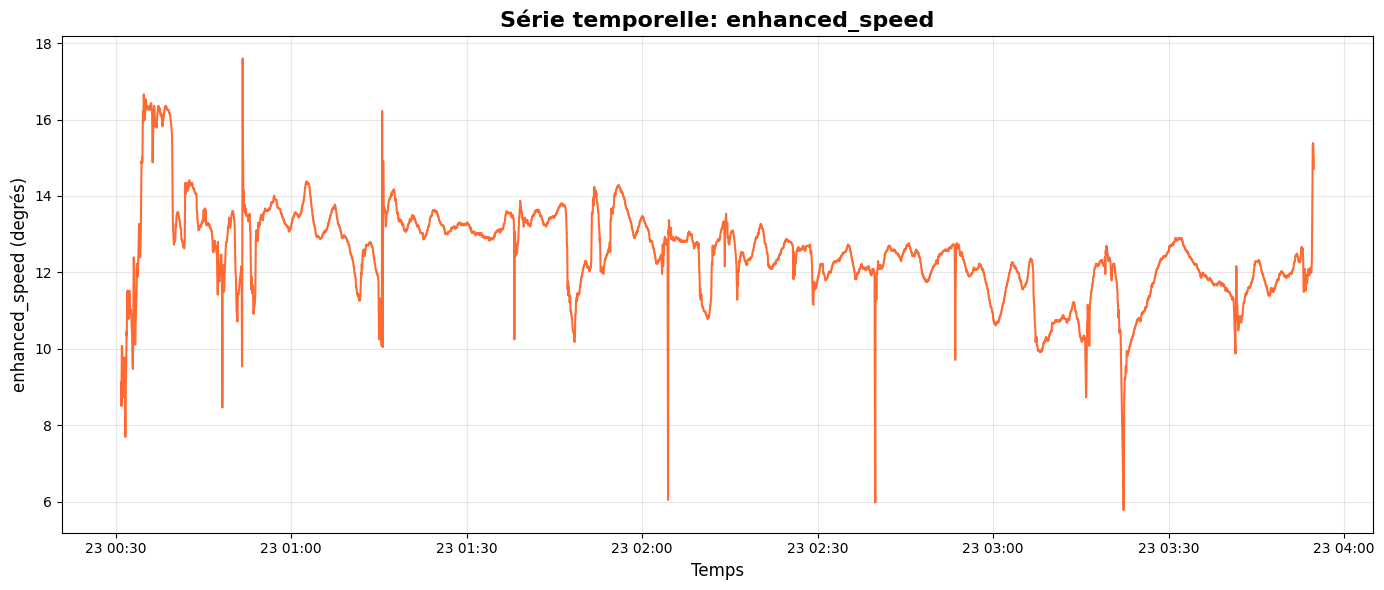

📈 Graphique de la série temporelle affiché
STATISTIQUES DESCRIPTIVES
Moyenne        : 12.5212°
Médiane        : 12.5280°
Écart-type     : 1.1390°
Min            : 5.7780°
Max            : 17.6000°
Q1 (25%)       : 11.9230°
Q3 (75%)       : 13.2010°


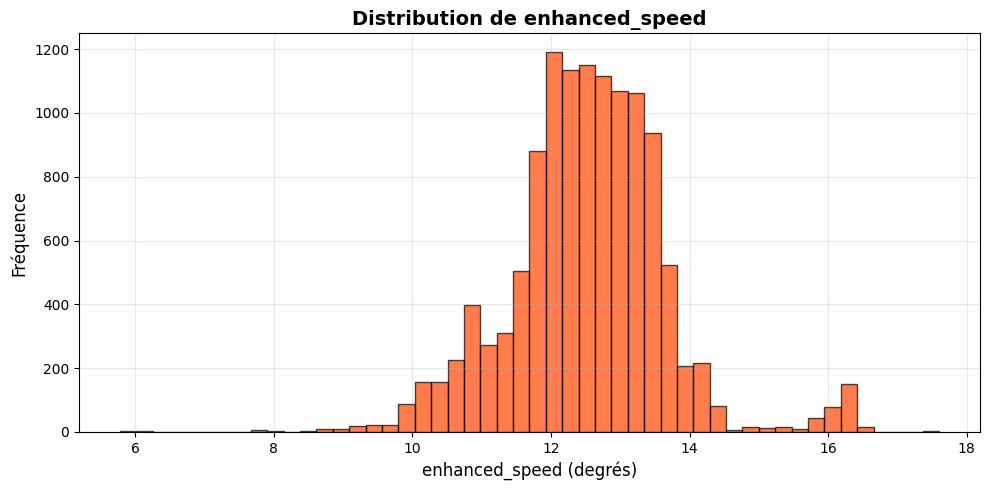

🔄 Décomposition STL en cours...


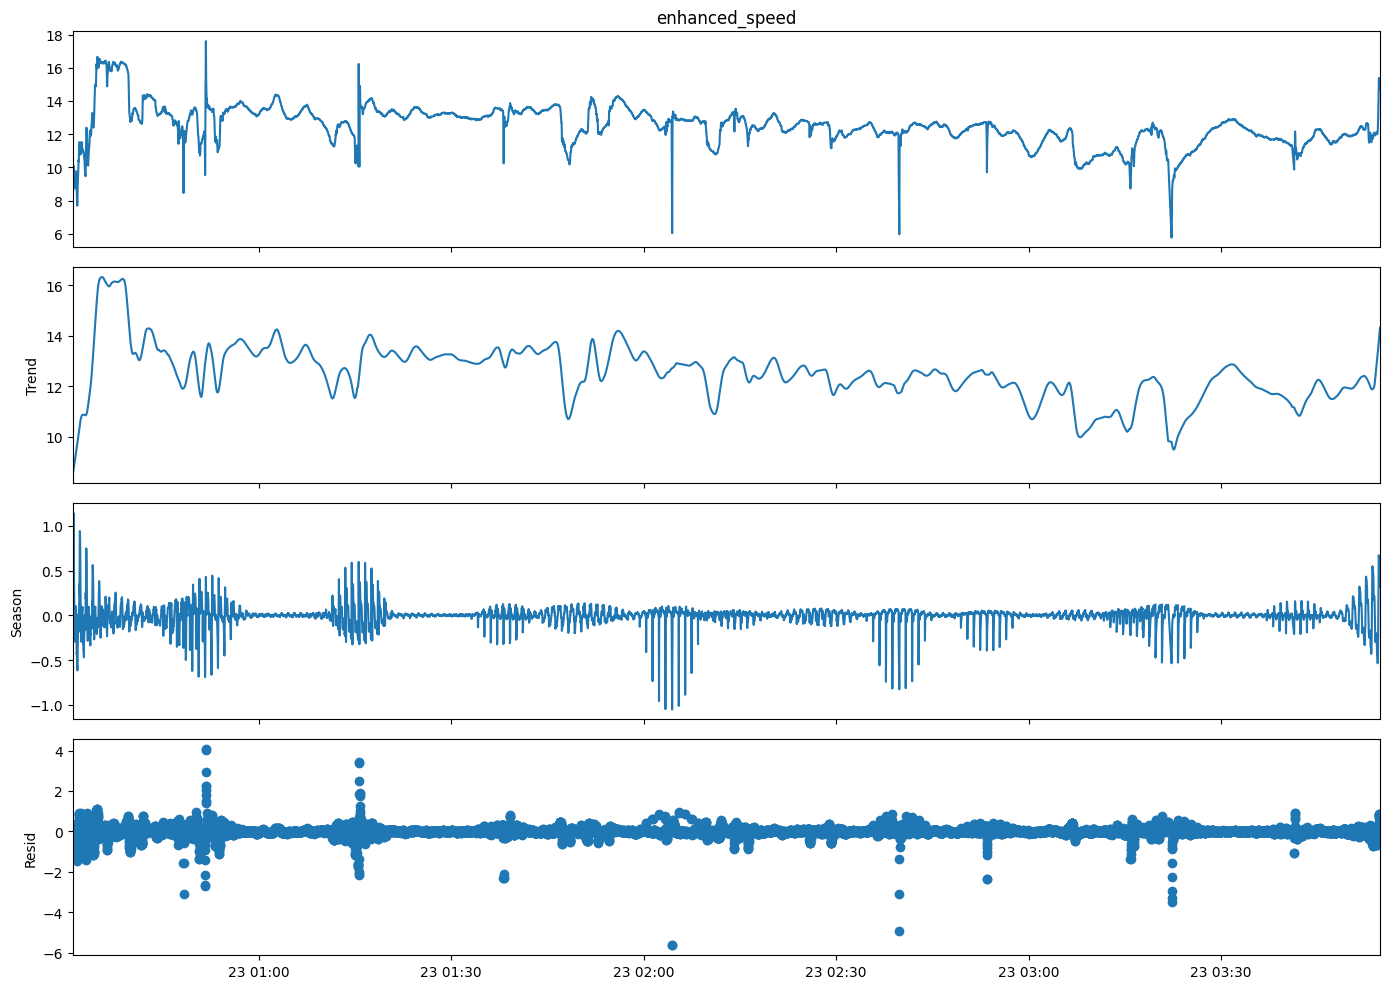

✅ Décomposition STL effectuée (période=60)
TEST DE STATIONNARITÉ (ADF)

Statistique ADF: -5.070116
P-value: 0.000016

Valeurs critiques:
  1%: -3.431
  5%: -2.862
  10%: -2.567

✅ La série est STATIONNAIRE (p-value < 0.05)
📊 Calcul et affichage des fonctions d’autocorrélation...


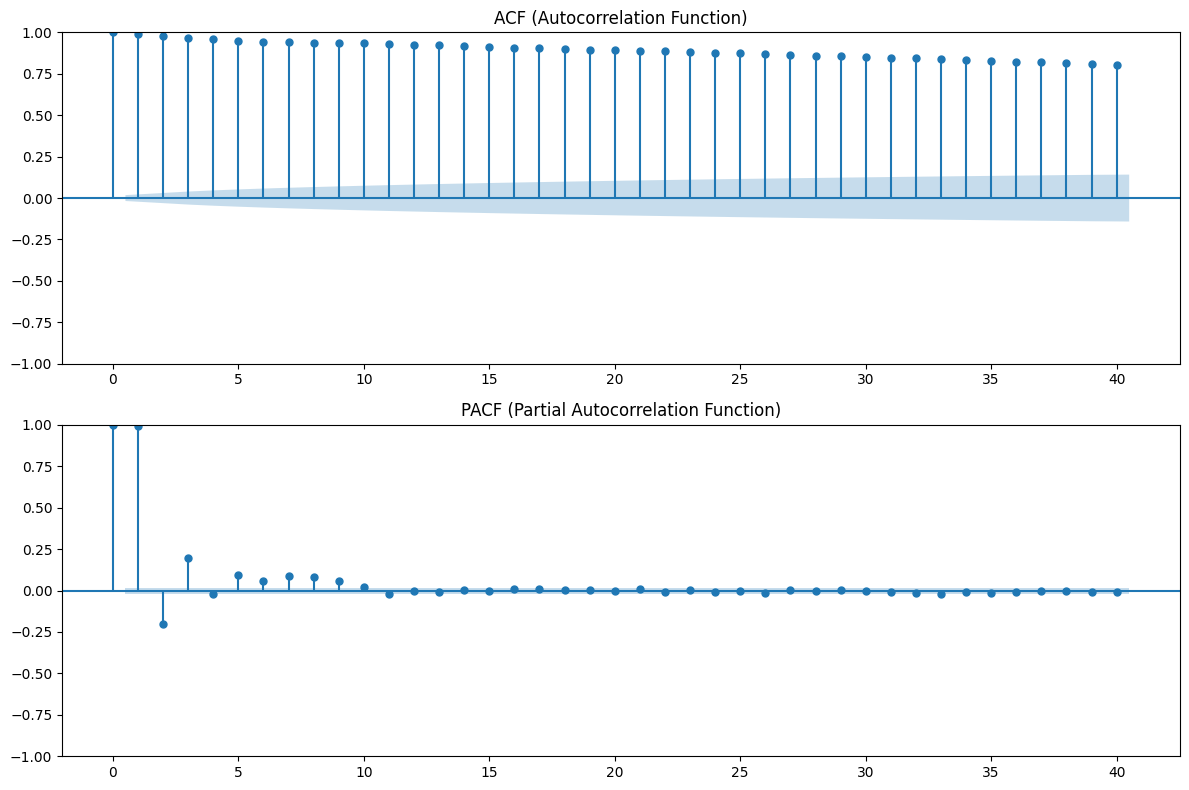

🔍 Détection des points de rupture dans la série...


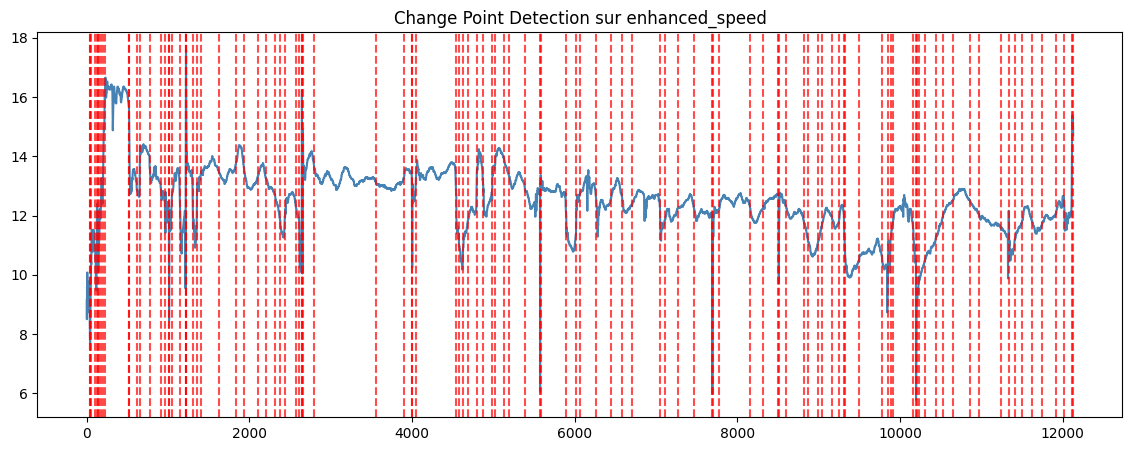

✅ 110 ruptures détectées aux indices : [35, 45, 55, 105, 125, 135, 155, 175, 205, 220, 520, 525, 615, 650, 775, 910, 960, 1010, 1015, 1045, 1145, 1215, 1220, 1225, 1305, 1355, 1400, 1620, 1835, 1935, 2100, 2210, 2320, 2375, 2440, 2570, 2615, 2645, 2650, 2655, 2800, 3560, 3895, 4000, 4005, 4045, 4545, 4580, 4630, 4685, 4795, 4875, 4985, 5025, 5135, 5190, 5390, 5570, 5580, 5895, 6020, 6070, 6260, 6450, 6585, 6710, 7050, 7105, 7265, 7470, 7690, 7695, 7780, 8160, 8315, 8505, 8515, 8600, 8820, 8870, 8995, 9045, 9170, 9255, 9315, 9330, 9500, 9780, 9855, 9885, 9915, 10165, 10195, 10205, 10230, 10305, 10440, 10525, 10650, 10860, 10975, 11240, 11345, 11410, 11505, 11620, 11750, 11925, 12020, 12115]
🌊 Analyse fréquentielle (Transformée de Fourier)


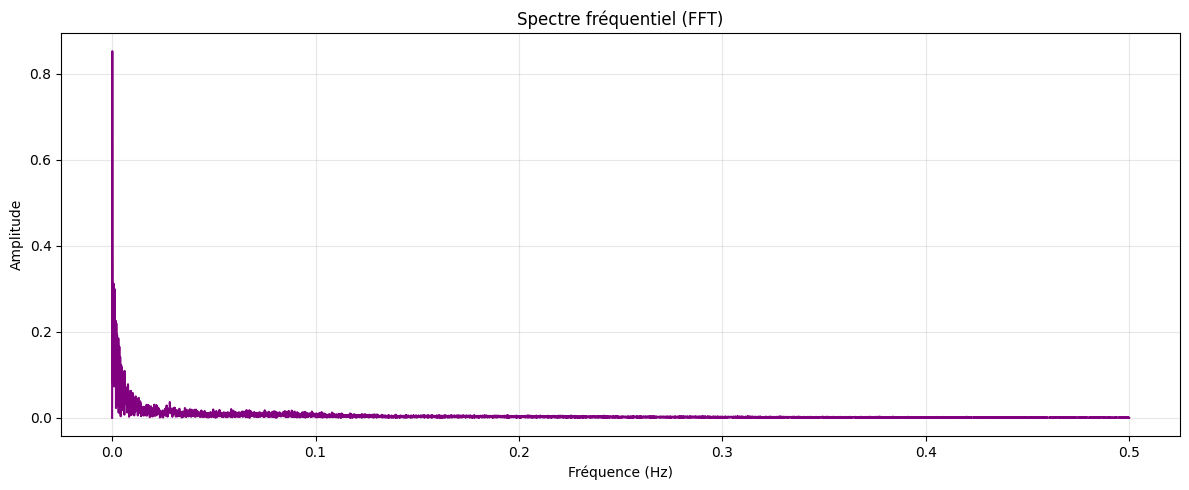

📉 Calcul des critères d’information (AIC / BIC) via modèle ARIMA...
AIC : -12193.6748
BIC : -12164.0607
L1-norm (somme des valeurs absolues) : 380.4356
L2-norm (norme quadratique) : 16.4621


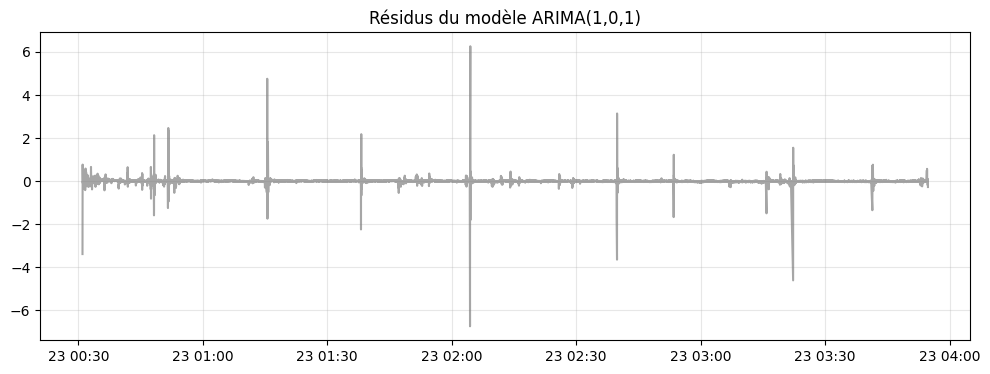

🔁 Autocorrélation globale sur la série...


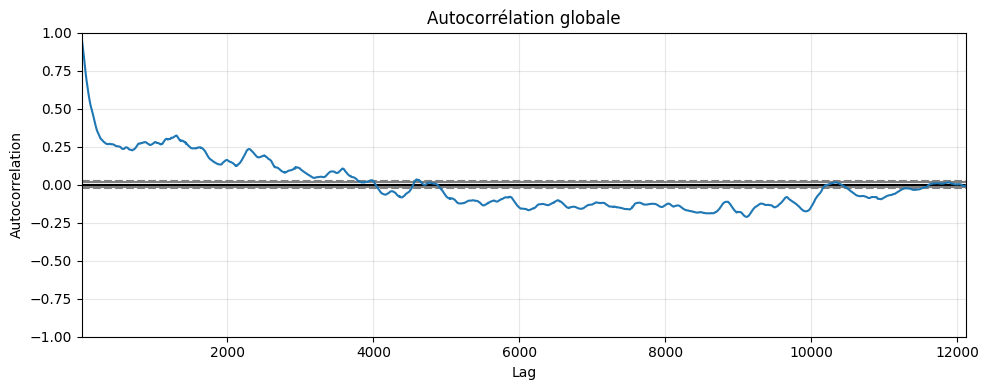

📏 Distance euclidienne entre les deux segments : 143.9794
🔍 Calcul du Matrix Profile pour la détection de motifs...
🏁 Motif principal trouvé à l’indice 8995


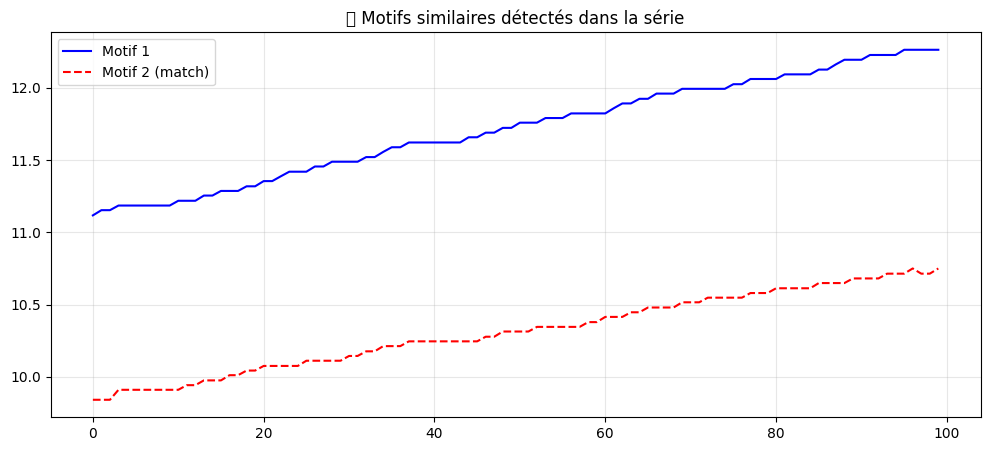

⚠️ Discord (anomalie potentielle) détectée à l’indice 9945


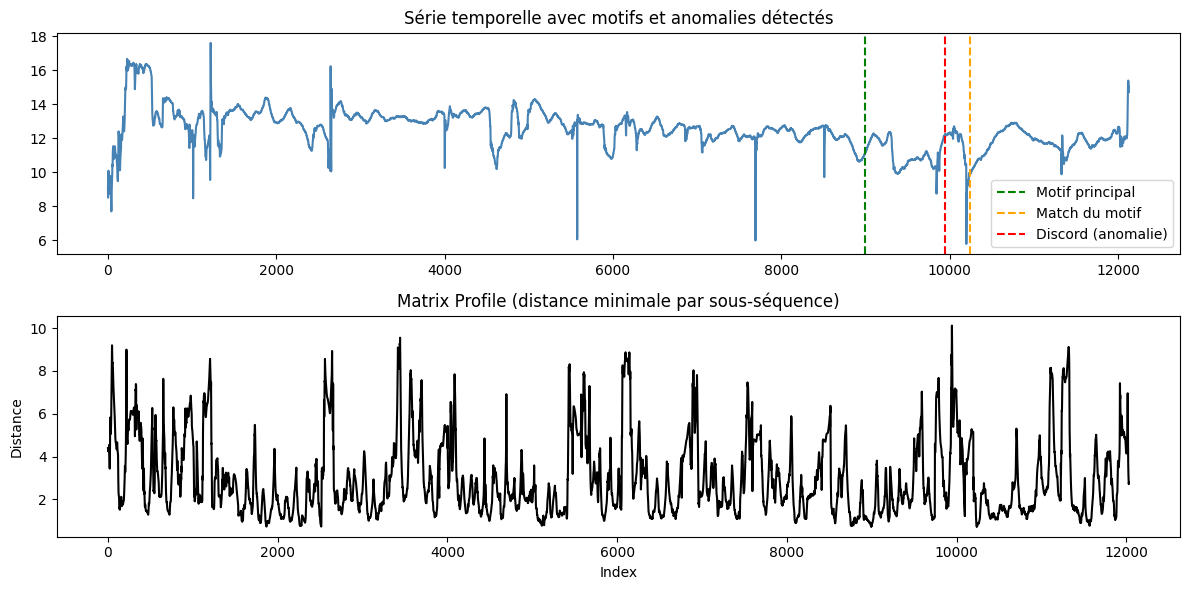

In [ ]:
print("🔍 DIAGNOSTIC DU NETTOYAGE:")
print(f"  Données de départ: {len(marathon1_clean)} lignes")
target_col = 'enhanced_speed'

marathon1_clean[target_col] = pd.to_numeric(marathon1_clean[target_col], errors='coerce')
print(f"  Après conversion numérique: {marathon1_clean[target_col].notna().sum()} valeurs non-nulles")

if 'timestamp' in marathon1_clean.columns:
    print(f"  Colonne 'timestamp' présente: {marathon1_clean['timestamp'].notna().sum()} valeurs non-nulles")
    print(f"  Exemple de valeur timestamp: {marathon1_clean['timestamp'].iloc[0]}")
else:
    print(f"  ❌ Colonne 'timestamp' ABSENTE!")

print(f"\n✅ Nettoyage effectué:")
print(f"  - Lignes avant: {len(marathon1_clean)}")
print(f"  - Lignes après: {len(marathon1_clean)}")
print(f"  - Lignes supprimées: {len(marathon1_clean) - len(marathon1_clean)}")

if 'timestamp' in marathon1_clean.columns:
    print(f"\n🔍 Création de l'index temporel avec 'timestamp'...")
    
    ts_data = marathon1_clean[['timestamp', target_col]].copy()
    print(f"  Après sélection colonnes: {len(ts_data)} lignes")
    ts_data = ts_data.dropna()
    print(f"  Après dropna initial: {len(ts_data)} lignes")
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    print(f"  Après conversion datetime: {ts_data['timestamp'].notna().sum()} timestamps valides")
    ts_data = ts_data.dropna()
    print(f"  Après dropna final: {len(ts_data)} lignes")
    
    ts_data = ts_data.set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
    if len(ts_data) > 0:
        print(f"\n⏱️ Plage temporelle de la série :")
        print(f"  Début : {ts_data.index.min()}")
        print(f"  Fin   : {ts_data.index.max()}")
        print(f"  Durée totale : {ts_data.index.max() - ts_data.index.min()}")

    
elif 'timestamp' in marathon1_clean.columns:
    ts_data = marathon1_clean[['timestamp', target_col]].dropna().copy()
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    ts_data = ts_data.dropna().set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
else:
    ts_data = marathon1_clean[[target_col]].dropna().copy()
    ts_data.index = range(len(ts_data))
    print(f"\n✅ Index temporel numérique créé")

print(f"\n{'='*60}")
print(f"RÉSULTAT FINAL: {len(ts_data)} points valides")
print(f"{'='*60}")

if len(ts_data) > 0:
    print(f"\nPremières valeurs de la série:")
    print(ts_data.head())
    print(f"\nStatistiques descriptives:")
    print(ts_data[target_col].describe())
else:
    print("⚠️ ATTENTION: Aucune donnée valide après nettoyage!")
    print("Vérifiez les étapes de diagnostic ci-dessus.")

plt.figure(figsize=(14, 6))
plt.plot(ts_data.index, ts_data[target_col], color='orangered', linewidth=1.5, alpha=0.8)
plt.title(f'Série temporelle: {target_col}', fontsize=16, fontweight='bold')
plt.xlabel('Temps', fontsize=12)
plt.ylabel(f'{target_col} (degrés)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📈 Graphique de la série temporelle affiché")

print("=" * 60)
print("STATISTIQUES DESCRIPTIVES")
print("=" * 60)

stats = {
    'Moyenne': ts_data[target_col].mean(),
    'Médiane': ts_data[target_col].median(),
    'Écart-type': ts_data[target_col].std(),
    'Min': ts_data[target_col].min(),
    'Max': ts_data[target_col].max(),
    'Q1 (25%)': ts_data[target_col].quantile(0.25),
    'Q3 (75%)': ts_data[target_col].quantile(0.75)
}

for key, value in stats.items():
    print(f"{key:15s}: {value:.4f}°")
plt.figure(figsize=(10, 5))
plt.hist(ts_data[target_col], bins=50, color='orangered', edgecolor='black', alpha=0.7)
plt.title(f'Distribution de {target_col}', fontsize=14, fontweight='bold')
plt.xlabel(f'{target_col} (degrés)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if len(ts_data) >= 100:
    print("🔄 Décomposition STL en cours...")
    
    period = min(60, len(ts_data) // 3)
    
    stl = STL(ts_data[target_col], period=period, seasonal=13)
    result = stl.fit()
    
    fig = result.plot()
    fig.set_size_inches(14, 10)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Décomposition STL effectuée (période={period})")
else:
    print(f"⚠️ Série trop courte ({len(ts_data)} points) pour une décomposition STL fiable.")

print("=" * 60)
print("TEST DE STATIONNARITÉ (ADF)")
print("=" * 60)

result_adf = adfuller(ts_data[target_col].dropna())

print(f"\nStatistique ADF: {result_adf[0]:.6f}")
print(f"P-value: {result_adf[1]:.6f}")
print(f"\nValeurs critiques:")
for key, value in result_adf[4].items():
    print(f"  {key}: {value:.3f}")

if result_adf[1] < 0.05:
    print(f"\n✅ La série est STATIONNAIRE (p-value < 0.05)")
else:
    print(f"\n⚠️ La série est NON-STATIONNAIRE (p-value >= 0.05)")
    print("   → Considérer une différenciation ou une transformation")

if len(ts_data) > 30:
    print("📊 Calcul et affichage des fonctions d’autocorrélation...")
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    plot_acf(ts_data[target_col].dropna(), ax=ax[0], lags=40)
    ax[0].set_title("ACF (Autocorrelation Function)")
    
    plot_pacf(ts_data[target_col].dropna(), ax=ax[1], lags=40, method='ywm')
    ax[1].set_title("PACF (Partial Autocorrelation Function)")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Série trop courte pour ACF/PACF fiables.")

print("🔍 Détection des points de rupture dans la série...")

signal = ts_data[target_col].dropna().values
model = "l2"  
algo = rpt.Pelt(model=model).fit(signal)
result = algo.predict(pen=5)

plt.figure(figsize=(14, 5))
plt.plot(signal, color='steelblue')
for cp in result:
    plt.axvline(cp, color='red', linestyle='--', alpha=0.7)
plt.title(f"Change Point Detection sur {target_col}")
plt.show()

print(f"✅ {len(result)-1} ruptures détectées aux indices : {result[:-1]}")

print("🌊 Analyse fréquentielle (Transformée de Fourier)")

y = ts_data[target_col].dropna().values
n = len(y)
timestep = 1  

yf = fft(y - np.mean(y))  
xf = fftfreq(n, timestep)[:n//2]  

plt.figure(figsize=(12, 5))
plt.plot(xf, 2.0/n * np.abs(yf[:n//2]), color='purple')
plt.title("Spectre fréquentiel (FFT)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📉 Calcul des critères d’information (AIC / BIC) via modèle ARIMA...")

try:
    model = ARIMA(ts_data[target_col].dropna(), order=(1, 0, 1))
    result = model.fit()
    
    print(f"AIC : {result.aic:.4f}")
    print(f"BIC : {result.bic:.4f}")
    print(f"L1-norm (somme des valeurs absolues) : {np.sum(np.abs(result.resid)):.4f}")
    print(f"L2-norm (norme quadratique) : {np.sqrt(np.sum(result.resid**2)):.4f}")
    
    plt.figure(figsize=(12, 4))
    plt.plot(result.resid, color='gray', alpha=0.7)
    plt.title("Résidus du modèle ARIMA(1,0,1)")
    plt.grid(True, alpha=0.3)
    plt.show()
except Exception as e:
    print(f"❌ Erreur lors de l’ajustement du modèle ARIMA : {e}")

print("🔁 Autocorrélation globale sur la série...")

plt.figure(figsize=(10, 4))
autocorrelation_plot(ts_data[target_col])
plt.title("Autocorrélation globale")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


y = ts_data[target_col].dropna().values
n = len(y) // 2
segment1, segment2 = y[:n], y[n:2*n]

dist_euclid = euclidean(segment1[:min(len(segment1), len(segment2))],
                        segment2[:min(len(segment1), len(segment2))])

print(f"📏 Distance euclidienne entre les deux segments : {dist_euclid:.4f}")


print("🔍 Calcul du Matrix Profile pour la détection de motifs...")

series = ts_data[target_col].dropna().values.astype(float)

m = 100  

mp = stumpy.stump(series, m=m)


motif_idx = np.argmin(mp[:, 0])
print(f"🏁 Motif principal trouvé à l’indice {motif_idx}")

motif1 = series[motif_idx:motif_idx+m]
motif2 = series[int(mp[motif_idx, 1]):int(mp[motif_idx, 1])+m]


plt.figure(figsize=(12, 5))
plt.plot(motif1, label='Motif 1', color='blue')
plt.plot(motif2, label='Motif 2 (match)', color='red', linestyle='--')
plt.title("🔍 Motifs similaires détectés dans la série")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

discord_idx = np.argmax(mp[:, 0])
print(f"⚠️ Discord (anomalie potentielle) détectée à l’indice {discord_idx}")

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(series, color='steelblue')
plt.axvline(motif_idx, color='green', linestyle='--', label='Motif principal')
plt.axvline(int(mp[motif_idx,1]), color='orange', linestyle='--', label='Match du motif')
plt.axvline(discord_idx, color='red', linestyle='--', label='Discord (anomalie)')
plt.title("Série temporelle avec motifs et anomalies détectés")
plt.legend()

plt.subplot(2,1,2)
plt.plot(mp[:,0], color='black')
plt.title("Matrix Profile (distance minimale par sous-séquence)")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


## Marathon 2

🔍 DIAGNOSTIC DU NETTOYAGE:
  Données de départ: 11408 lignes
  Après conversion numérique: 11408 valeurs non-nulles
  Colonne 'timestamp' présente: 11408 valeurs non-nulles
  Exemple de valeur timestamp: 2025-10-05T00:25:09

✅ Nettoyage effectué:
  - Lignes avant: 11408
  - Lignes après: 11408
  - Lignes supprimées: 0

🔍 Création de l'index temporel avec 'timestamp'...
  Après sélection colonnes: 11408 lignes
  Après dropna initial: 11408 lignes
  Après conversion datetime: 11408 timestamps valides
  Après dropna final: 11408 lignes

✅ Index temporel basé sur 'timestamp'

⏱️ Plage temporelle de la série :
  Début : 2025-10-05 00:25:09
  Fin   : 2025-10-05 03:58:13
  Durée totale : 0 days 03:33:04

RÉSULTAT FINAL: 11408 points valides

Premières valeurs de la série:
                     enhanced_speed
timestamp                          
2025-10-05 00:25:09           7.222
2025-10-05 00:25:10           9.810
2025-10-05 00:25:11          12.766
2025-10-05 00:25:12          12.766
2025-10-

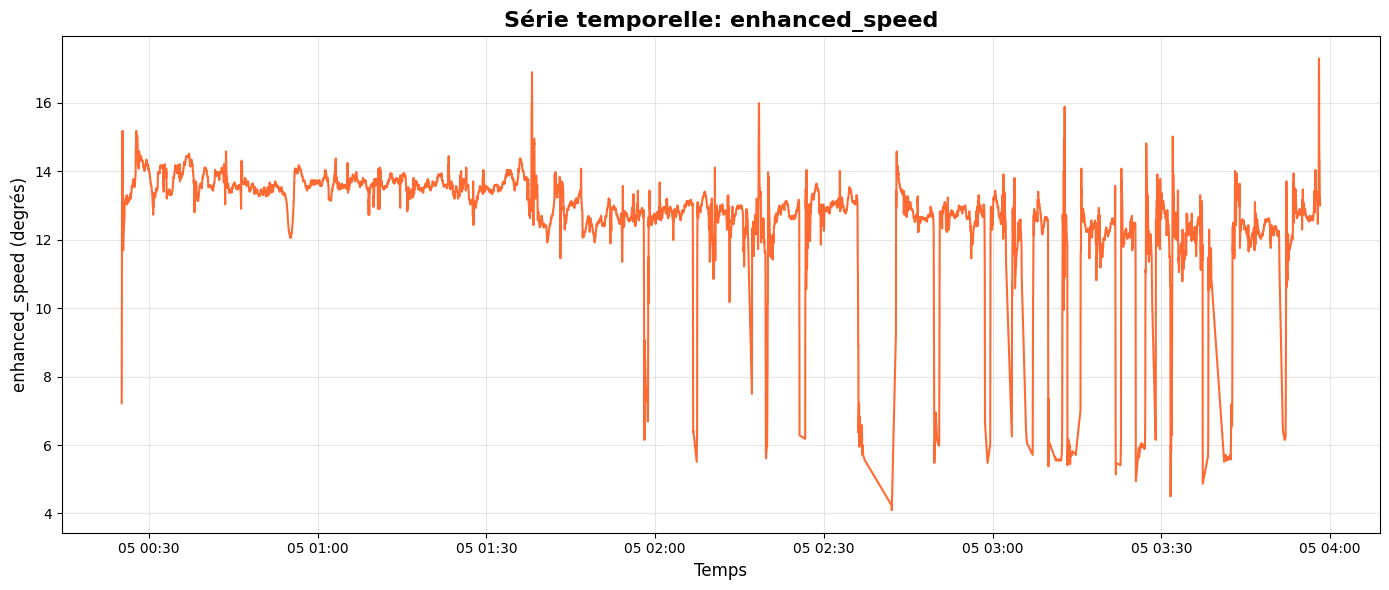

📈 Graphique de la série temporelle affiché
STATISTIQUES DESCRIPTIVES
Moyenne        : 12.7852°
Médiane        : 12.9670°
Écart-type     : 1.4660°
Min            : 4.0970°
Max            : 17.2980°
Q1 (25%)       : 12.5280°
Q3 (75%)       : 13.5720°


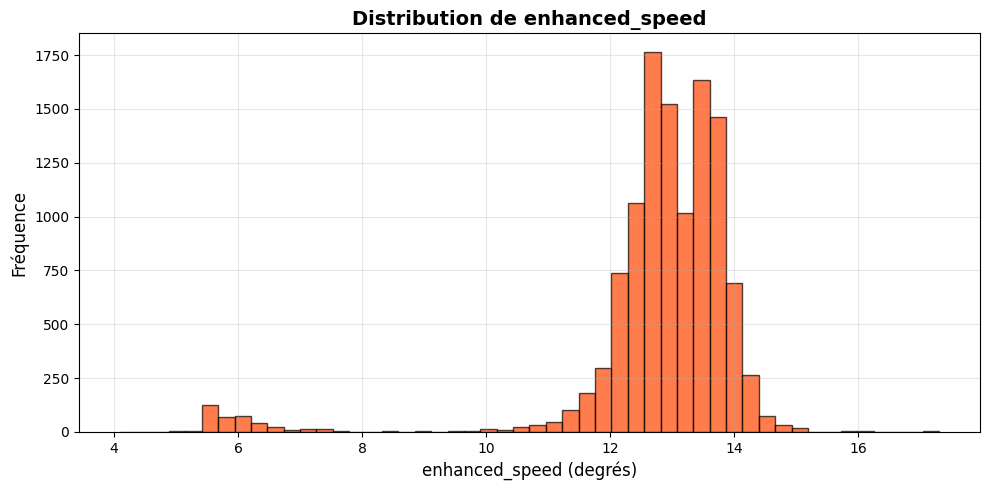

🔄 Décomposition STL en cours...


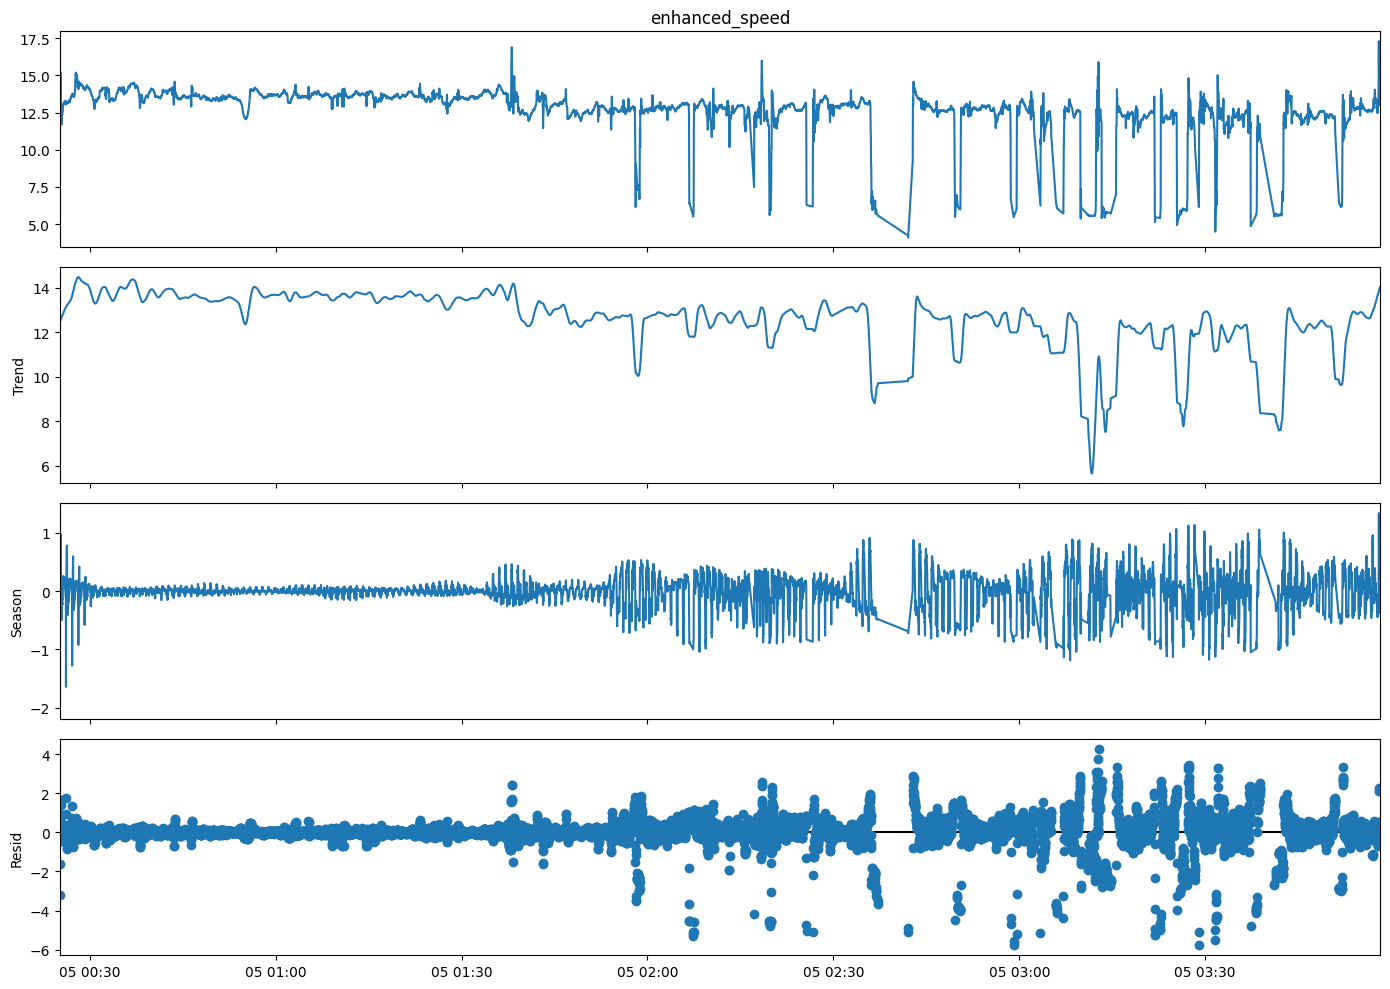

✅ Décomposition STL effectuée (période=60)
TEST DE STATIONNARITÉ (ADF)

Statistique ADF: -9.343793
P-value: 0.000000

Valeurs critiques:
  1%: -3.431
  5%: -2.862
  10%: -2.567

✅ La série est STATIONNAIRE (p-value < 0.05)
📊 Calcul et affichage des fonctions d’autocorrélation...


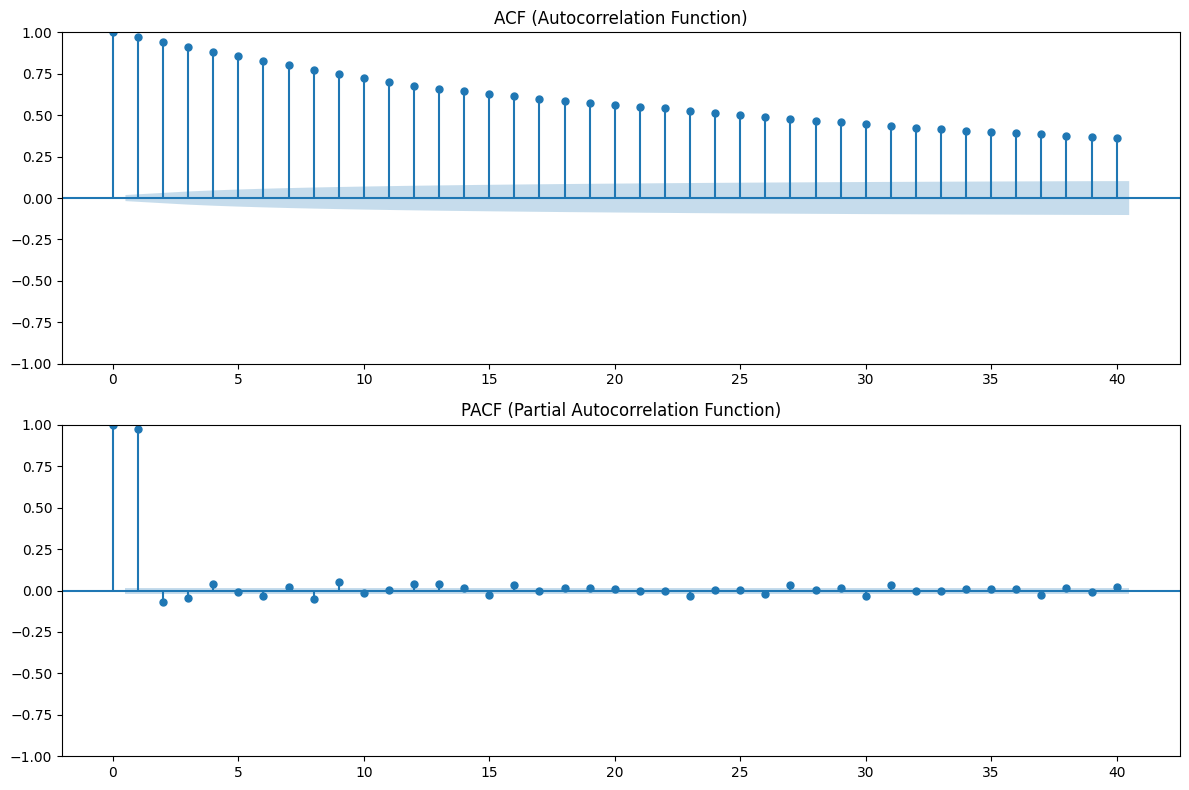

🔍 Détection des points de rupture dans la série...


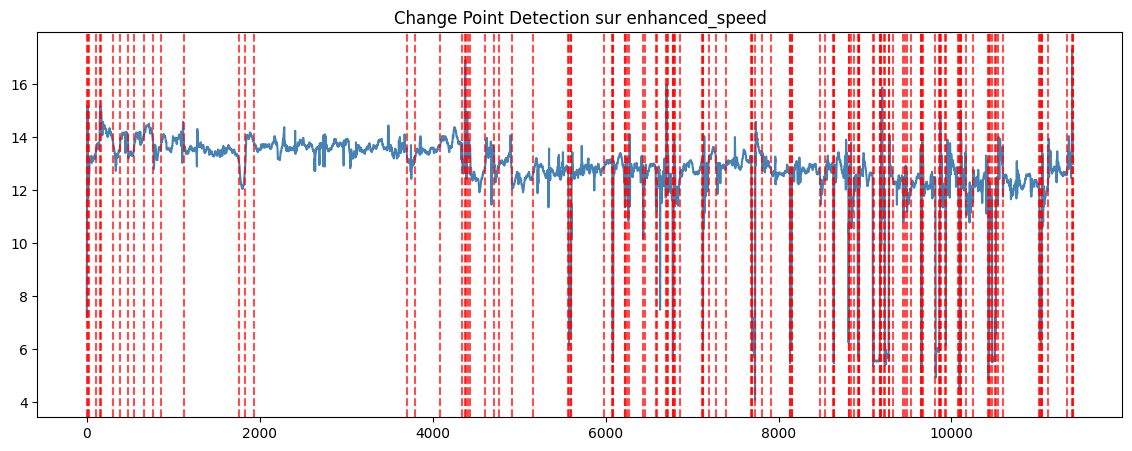

✅ 133 ruptures détectées aux indices : [5, 10, 30, 105, 150, 170, 305, 385, 480, 550, 660, 765, 860, 1125, 1765, 1835, 1935, 3700, 3800, 4090, 4340, 4370, 4380, 4405, 4435, 4605, 4715, 4765, 4915, 5160, 5570, 5575, 5600, 5605, 5985, 6075, 6080, 6090, 6220, 6230, 6250, 6275, 6430, 6455, 6580, 6595, 6700, 6710, 6725, 6775, 6785, 6790, 6805, 6855, 7120, 7125, 7130, 7190, 7275, 7395, 7685, 7690, 7695, 7730, 7805, 7910, 8130, 8135, 8150, 8155, 8480, 8540, 8635, 8640, 8645, 8810, 8815, 8840, 8870, 8915, 8925, 8930, 8935, 9090, 9100, 9170, 9175, 9185, 9190, 9225, 9230, 9275, 9280, 9320, 9440, 9460, 9480, 9535, 9645, 9650, 9660, 9675, 9815, 9860, 9865, 9870, 9880, 9930, 9940, 10075, 10090, 10095, 10105, 10115, 10165, 10250, 10425, 10435, 10440, 10470, 10500, 10515, 10540, 10590, 11015, 11020, 11040, 11045, 11050, 11115, 11340, 11395, 11400]
🌊 Analyse fréquentielle (Transformée de Fourier)


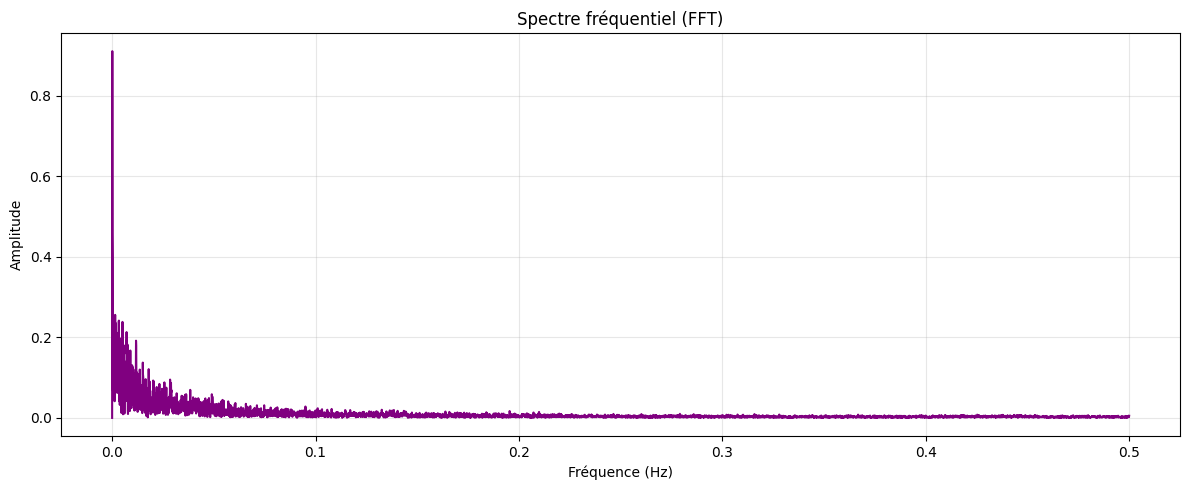

📉 Calcul des critères d’information (AIC / BIC) via modèle ARIMA...
AIC : 7154.4276
BIC : 7183.7959
L1-norm (somme des valeurs absolues) : 1021.5748
L2-norm (norme quadratique) : 35.7573


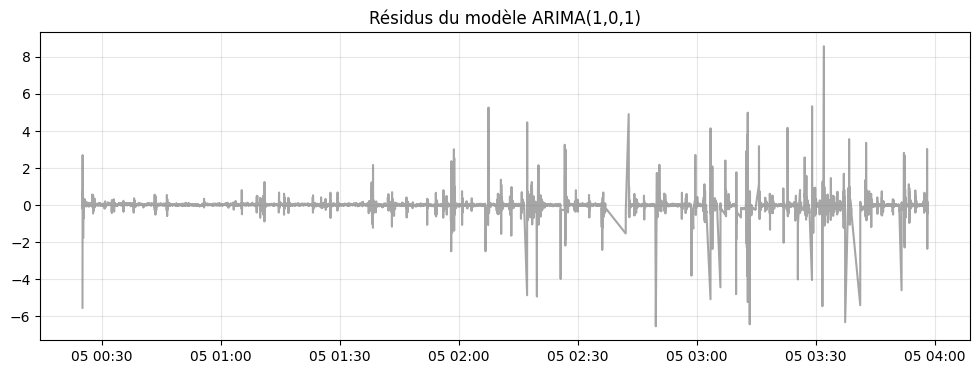

🔁 Autocorrélation globale sur la série...


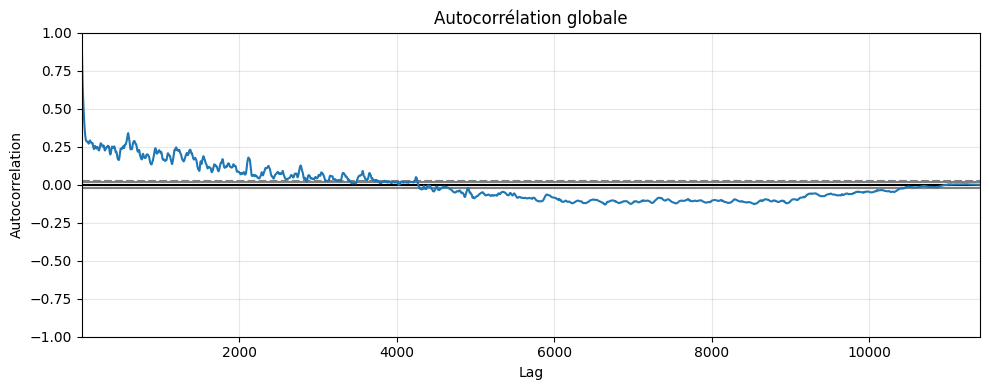

📏 Distance euclidienne entre les deux segments : 169.8797
🔍 Calcul du Matrix Profile pour la détection de motifs...
🏁 Motif principal trouvé à l’indice 8050


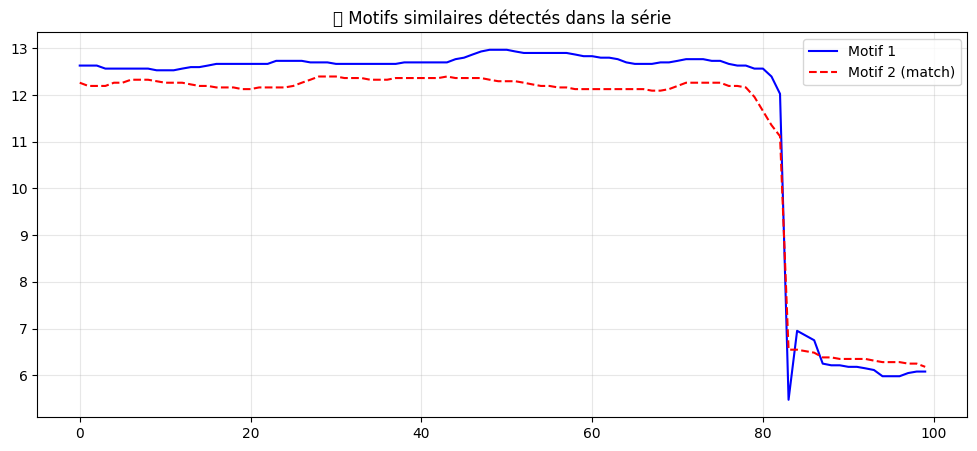

⚠️ Discord (anomalie potentielle) détectée à l’indice 2019


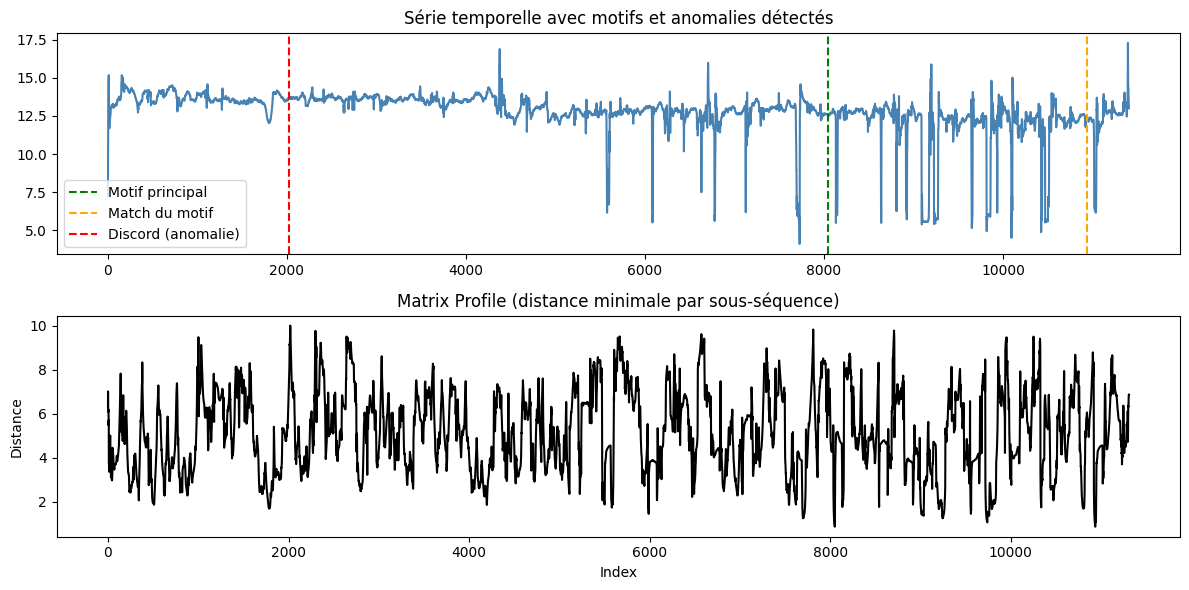

In [ ]:
print("🔍 DIAGNOSTIC DU NETTOYAGE:")
print(f"  Données de départ: {len(marathon2_clean)} lignes")
target_col = 'enhanced_speed'

marathon2_clean[target_col] = pd.to_numeric(marathon2_clean[target_col], errors='coerce')
print(f"  Après conversion numérique: {marathon2_clean[target_col].notna().sum()} valeurs non-nulles")

if 'timestamp' in marathon2_clean.columns:
    print(f"  Colonne 'timestamp' présente: {marathon2_clean['timestamp'].notna().sum()} valeurs non-nulles")
    print(f"  Exemple de valeur timestamp: {marathon2_clean['timestamp'].iloc[0]}")
else:
    print(f"  ❌ Colonne 'timestamp' ABSENTE!")

print(f"\n✅ Nettoyage effectué:")
print(f"  - Lignes avant: {len(marathon2_clean)}")
print(f"  - Lignes après: {len(marathon2_clean)}")
print(f"  - Lignes supprimées: {len(marathon2_clean) - len(marathon2_clean)}")

if 'timestamp' in marathon2_clean.columns:
    print(f"\n🔍 Création de l'index temporel avec 'timestamp'...")
    
    ts_data = marathon2_clean[['timestamp', target_col]].copy()
    print(f"  Après sélection colonnes: {len(ts_data)} lignes")
    ts_data = ts_data.dropna()
    print(f"  Après dropna initial: {len(ts_data)} lignes")
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    print(f"  Après conversion datetime: {ts_data['timestamp'].notna().sum()} timestamps valides")
    ts_data = ts_data.dropna()
    print(f"  Après dropna final: {len(ts_data)} lignes")
    
    ts_data = ts_data.set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
    if len(ts_data) > 0:
        print(f"\n⏱️ Plage temporelle de la série :")
        print(f"  Début : {ts_data.index.min()}")
        print(f"  Fin   : {ts_data.index.max()}")
        print(f"  Durée totale : {ts_data.index.max() - ts_data.index.min()}")

    
elif 'timestamp' in marathon2_clean.columns:
    ts_data = marathon2_clean[['timestamp', target_col]].dropna().copy()
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    ts_data = ts_data.dropna().set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
else:
    ts_data = marathon2_clean[[target_col]].dropna().copy()
    ts_data.index = range(len(ts_data))
    print(f"\n✅ Index temporel numérique créé")

print(f"\n{'='*60}")
print(f"RÉSULTAT FINAL: {len(ts_data)} points valides")
print(f"{'='*60}")

if len(ts_data) > 0:
    print(f"\nPremières valeurs de la série:")
    print(ts_data.head())
    print(f"\nStatistiques descriptives:")
    print(ts_data[target_col].describe())
else:
    print("⚠️ ATTENTION: Aucune donnée valide après nettoyage!")
    print("Vérifiez les étapes de diagnostic ci-dessus.")

plt.figure(figsize=(14, 6))
plt.plot(ts_data.index, ts_data[target_col], color='orangered', linewidth=1.5, alpha=0.8)
plt.title(f'Série temporelle: {target_col}', fontsize=16, fontweight='bold')
plt.xlabel('Temps', fontsize=12)
plt.ylabel(f'{target_col} (degrés)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📈 Graphique de la série temporelle affiché")

print("=" * 60)
print("STATISTIQUES DESCRIPTIVES")
print("=" * 60)

stats = {
    'Moyenne': ts_data[target_col].mean(),
    'Médiane': ts_data[target_col].median(),
    'Écart-type': ts_data[target_col].std(),
    'Min': ts_data[target_col].min(),
    'Max': ts_data[target_col].max(),
    'Q1 (25%)': ts_data[target_col].quantile(0.25),
    'Q3 (75%)': ts_data[target_col].quantile(0.75)
}

for key, value in stats.items():
    print(f"{key:15s}: {value:.4f}°")
plt.figure(figsize=(10, 5))
plt.hist(ts_data[target_col], bins=50, color='orangered', edgecolor='black', alpha=0.7)
plt.title(f'Distribution de {target_col}', fontsize=14, fontweight='bold')
plt.xlabel(f'{target_col} (degrés)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if len(ts_data) >= 100:
    print("🔄 Décomposition STL en cours...")
    
    period = min(60, len(ts_data) // 3)
    
    stl = STL(ts_data[target_col], period=period, seasonal=13)
    result = stl.fit()
    
    fig = result.plot()
    fig.set_size_inches(14, 10)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Décomposition STL effectuée (période={period})")
else:
    print(f"⚠️ Série trop courte ({len(ts_data)} points) pour une décomposition STL fiable.")

print("=" * 60)
print("TEST DE STATIONNARITÉ (ADF)")
print("=" * 60)

result_adf = adfuller(ts_data[target_col].dropna())

print(f"\nStatistique ADF: {result_adf[0]:.6f}")
print(f"P-value: {result_adf[1]:.6f}")
print(f"\nValeurs critiques:")
for key, value in result_adf[4].items():
    print(f"  {key}: {value:.3f}")

if result_adf[1] < 0.05:
    print(f"\n✅ La série est STATIONNAIRE (p-value < 0.05)")
else:
    print(f"\n⚠️ La série est NON-STATIONNAIRE (p-value >= 0.05)")
    print("   → Considérer une différenciation ou une transformation")

if len(ts_data) > 30:
    print("📊 Calcul et affichage des fonctions d’autocorrélation...")
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    plot_acf(ts_data[target_col].dropna(), ax=ax[0], lags=40)
    ax[0].set_title("ACF (Autocorrelation Function)")
    
    plot_pacf(ts_data[target_col].dropna(), ax=ax[1], lags=40, method='ywm')
    ax[1].set_title("PACF (Partial Autocorrelation Function)")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Série trop courte pour ACF/PACF fiables.")

print("🔍 Détection des points de rupture dans la série...")

signal = ts_data[target_col].dropna().values
model = "l2"  
algo = rpt.Pelt(model=model).fit(signal)
result = algo.predict(pen=5)

plt.figure(figsize=(14, 5))
plt.plot(signal, color='steelblue')
for cp in result:
    plt.axvline(cp, color='red', linestyle='--', alpha=0.7)
plt.title(f"Change Point Detection sur {target_col}")
plt.show()

print(f"✅ {len(result)-1} ruptures détectées aux indices : {result[:-1]}")

print("🌊 Analyse fréquentielle (Transformée de Fourier)")

y = ts_data[target_col].dropna().values
n = len(y)
timestep = 1  

yf = fft(y - np.mean(y))  
xf = fftfreq(n, timestep)[:n//2]  

plt.figure(figsize=(12, 5))
plt.plot(xf, 2.0/n * np.abs(yf[:n//2]), color='purple')
plt.title("Spectre fréquentiel (FFT)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📉 Calcul des critères d’information (AIC / BIC) via modèle ARIMA...")

try:
    model = ARIMA(ts_data[target_col].dropna(), order=(1, 0, 1))
    result = model.fit()
    
    print(f"AIC : {result.aic:.4f}")
    print(f"BIC : {result.bic:.4f}")
    print(f"L1-norm (somme des valeurs absolues) : {np.sum(np.abs(result.resid)):.4f}")
    print(f"L2-norm (norme quadratique) : {np.sqrt(np.sum(result.resid**2)):.4f}")
    
    plt.figure(figsize=(12, 4))
    plt.plot(result.resid, color='gray', alpha=0.7)
    plt.title("Résidus du modèle ARIMA(1,0,1)")
    plt.grid(True, alpha=0.3)
    plt.show()
except Exception as e:
    print(f"❌ Erreur lors de l’ajustement du modèle ARIMA : {e}")

print("🔁 Autocorrélation globale sur la série...")

plt.figure(figsize=(10, 4))
autocorrelation_plot(ts_data[target_col])
plt.title("Autocorrélation globale")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

y = ts_data[target_col].dropna().values
n = len(y) // 2
segment1, segment2 = y[:n], y[n:2*n]

dist_euclid = euclidean(segment1[:min(len(segment1), len(segment2))],
                        segment2[:min(len(segment1), len(segment2))])

print(f"📏 Distance euclidienne entre les deux segments : {dist_euclid:.4f}")


print("🔍 Calcul du Matrix Profile pour la détection de motifs...")

series = ts_data[target_col].dropna().values.astype(float)

m = 100  

mp = stumpy.stump(series, m=m)


motif_idx = np.argmin(mp[:, 0])
print(f"🏁 Motif principal trouvé à l’indice {motif_idx}")

motif1 = series[motif_idx:motif_idx+m]
motif2 = series[int(mp[motif_idx, 1]):int(mp[motif_idx, 1])+m]


plt.figure(figsize=(12, 5))
plt.plot(motif1, label='Motif 1', color='blue')
plt.plot(motif2, label='Motif 2 (match)', color='red', linestyle='--')
plt.title("🔍 Motifs similaires détectés dans la série")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

discord_idx = np.argmax(mp[:, 0])
print(f"⚠️ Discord (anomalie potentielle) détectée à l’indice {discord_idx}")

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(series, color='steelblue')
plt.axvline(motif_idx, color='green', linestyle='--', label='Motif principal')
plt.axvline(int(mp[motif_idx,1]), color='orange', linestyle='--', label='Match du motif')
plt.axvline(discord_idx, color='red', linestyle='--', label='Discord (anomalie)')
plt.title("Série temporelle avec motifs et anomalies détectés")
plt.legend()

plt.subplot(2,1,2)
plt.plot(mp[:,0], color='black')
plt.title("Matrix Profile (distance minimale par sous-séquence)")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


## Semi 2

🔍 DIAGNOSTIC DU NETTOYAGE:
  Données de départ: 5636 lignes
  Après conversion numérique: 5636 valeurs non-nulles
  Colonne 'timestamp' présente: 5636 valeurs non-nulles
  Exemple de valeur timestamp: 2024-10-27T01:58:10

✅ Nettoyage effectué:
  - Lignes avant: 5636
  - Lignes après: 5636
  - Lignes supprimées: 0

🔍 Création de l'index temporel avec 'timestamp'...
  Après sélection colonnes: 5636 lignes
  Après dropna initial: 5636 lignes
  Après conversion datetime: 5636 timestamps valides
  Après dropna final: 5636 lignes

✅ Index temporel basé sur 'timestamp'

⏱️ Plage temporelle de la série :
  Début : 2024-10-27 01:58:10
  Fin   : 2024-10-27 03:32:05
  Durée totale : 0 days 01:33:55

RÉSULTAT FINAL: 5636 points valides

Premières valeurs de la série:
                     enhanced_speed
timestamp                          
2024-10-27 01:58:10          13.673
2024-10-27 01:58:11          13.673
2024-10-27 01:58:12          12.092
2024-10-27 01:58:13          11.689
2024-10-27 01:58:1

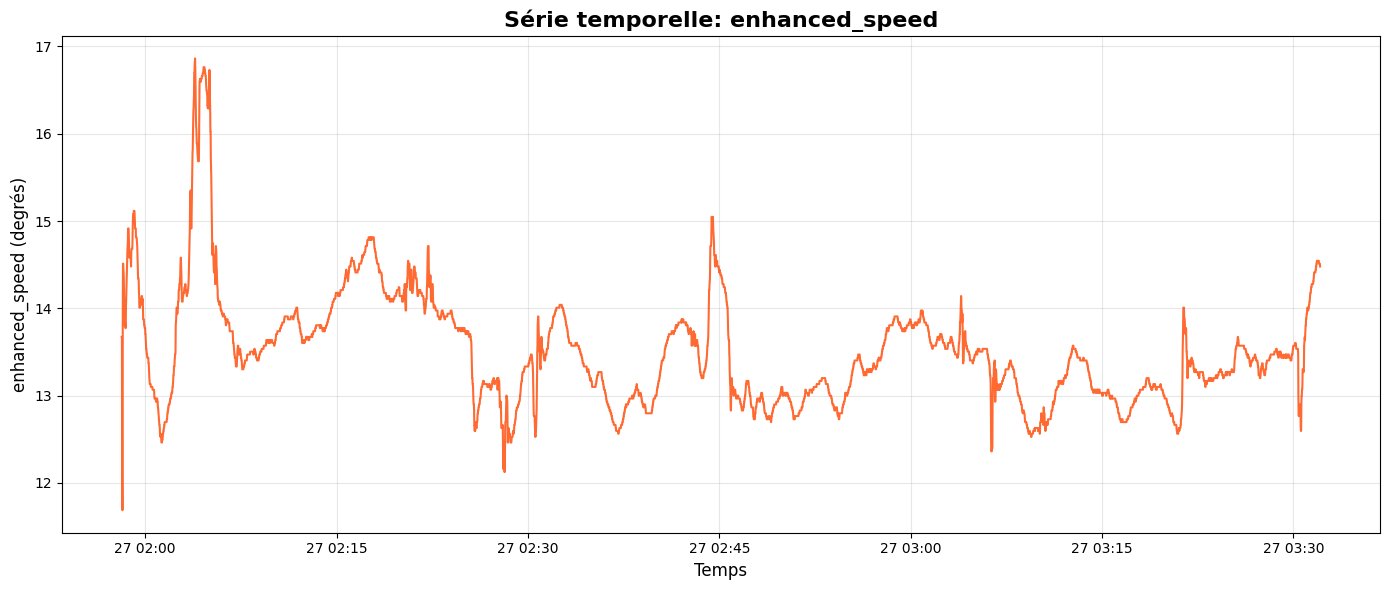

📈 Graphique de la série temporelle affiché
STATISTIQUES DESCRIPTIVES
Moyenne        : 13.5041°
Médiane        : 13.4350°
Écart-type     : 0.6467°
Min            : 11.6890°
Max            : 16.8620°
Q1 (25%)       : 13.0680°
Q3 (75%)       : 13.8060°


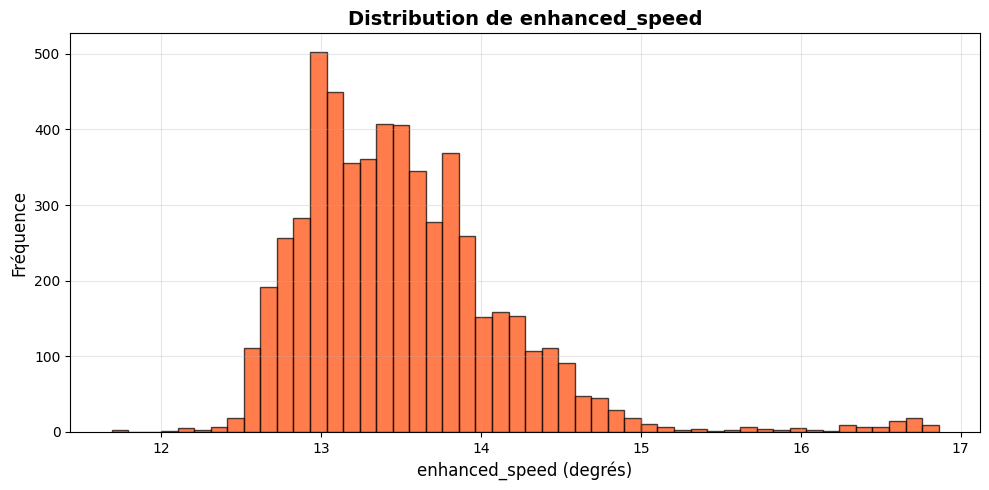

🔄 Décomposition STL en cours...


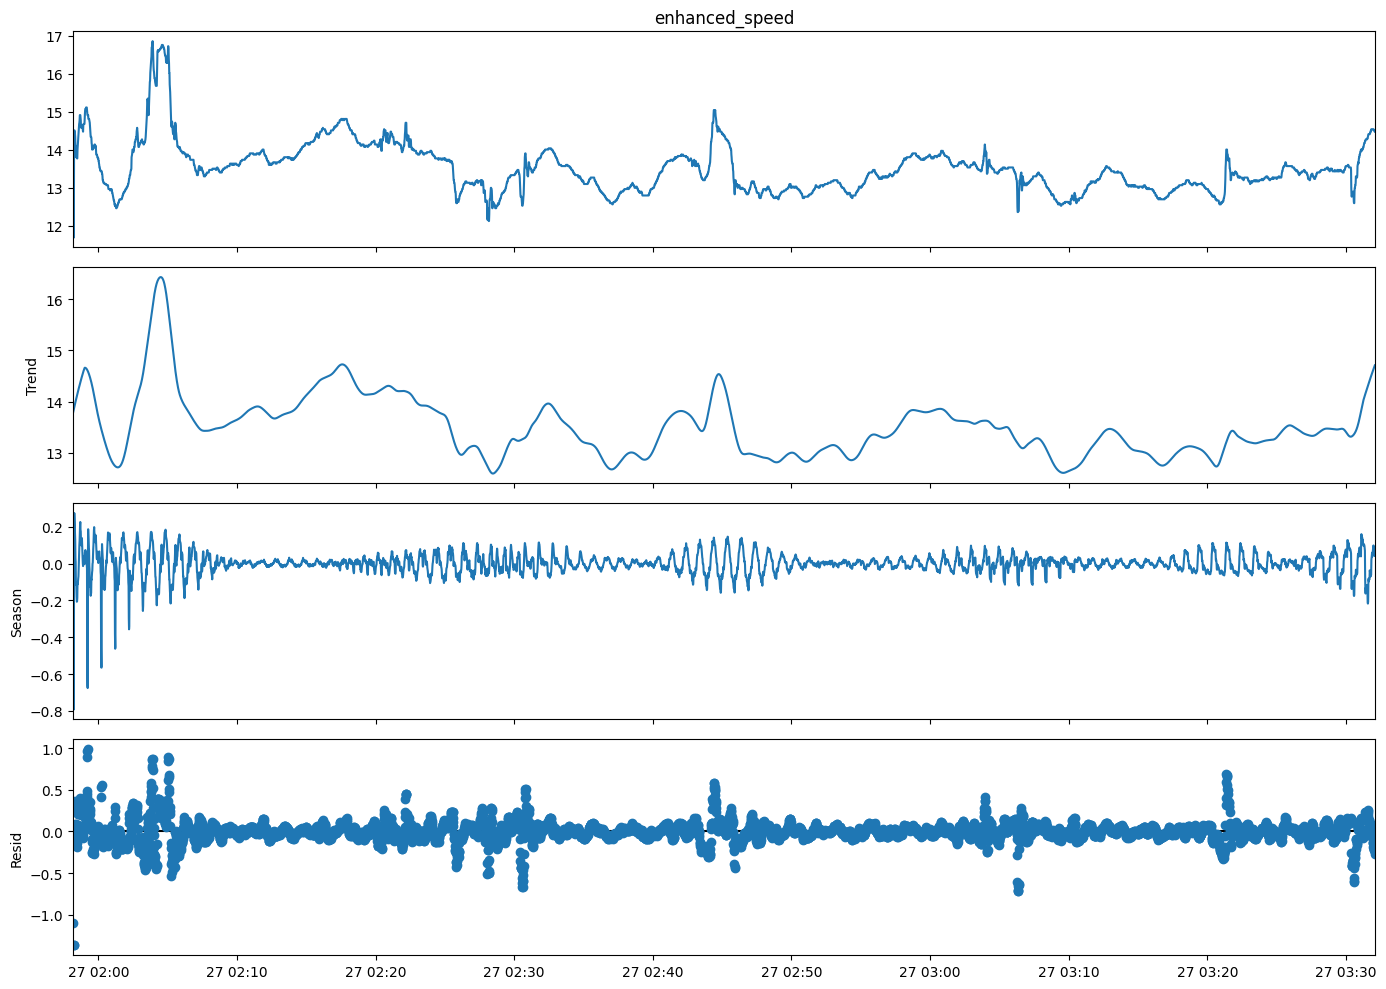

✅ Décomposition STL effectuée (période=60)
TEST DE STATIONNARITÉ (ADF)

Statistique ADF: -4.145777
P-value: 0.000813

Valeurs critiques:
  1%: -3.432
  5%: -2.862
  10%: -2.567

✅ La série est STATIONNAIRE (p-value < 0.05)
📊 Calcul et affichage des fonctions d’autocorrélation...


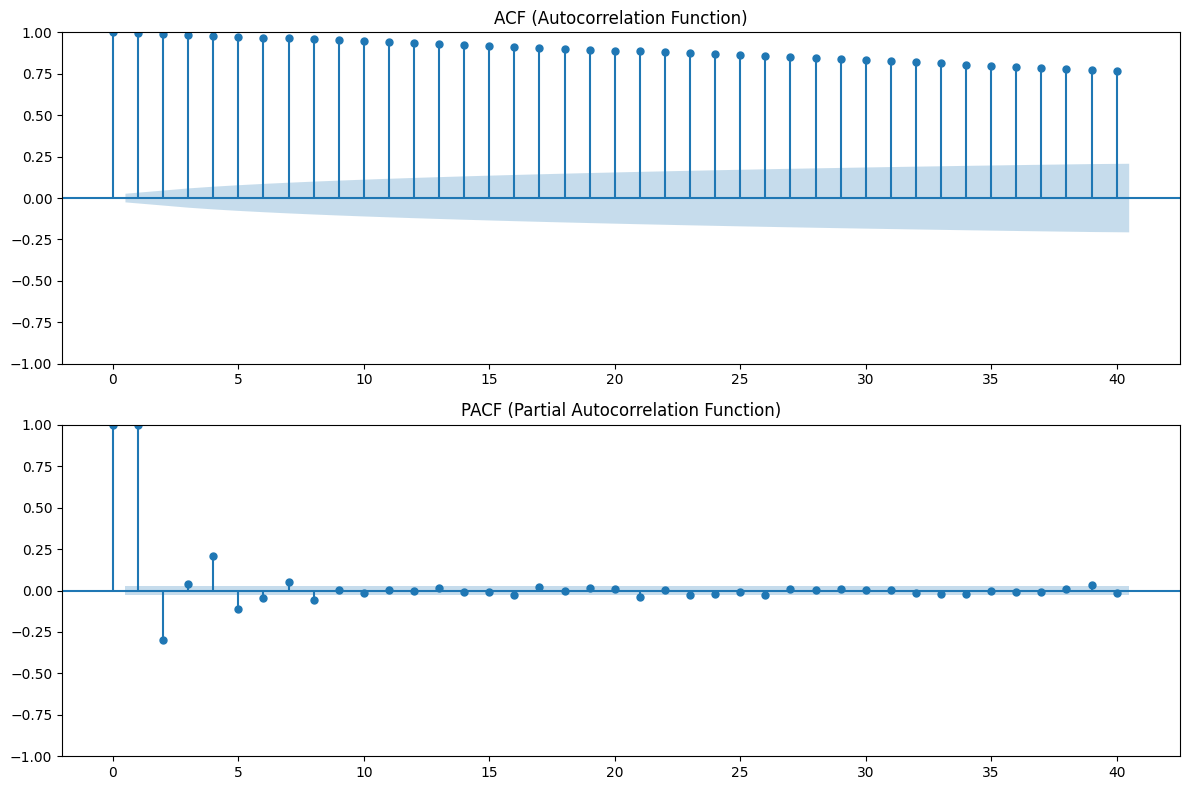

🔍 Détection des points de rupture dans la série...


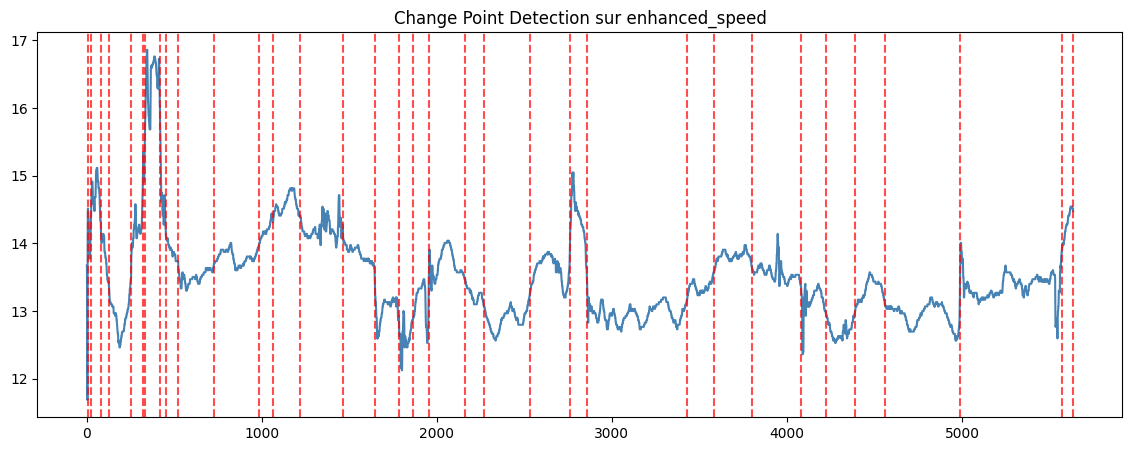

✅ 33 ruptures détectées aux indices : [5, 25, 80, 125, 255, 320, 335, 420, 450, 520, 725, 985, 1065, 1220, 1465, 1645, 1785, 1865, 1955, 2160, 2270, 2530, 2760, 2855, 3430, 3585, 3800, 4080, 4225, 4390, 4560, 4990, 5570]
🌊 Analyse fréquentielle (Transformée de Fourier)


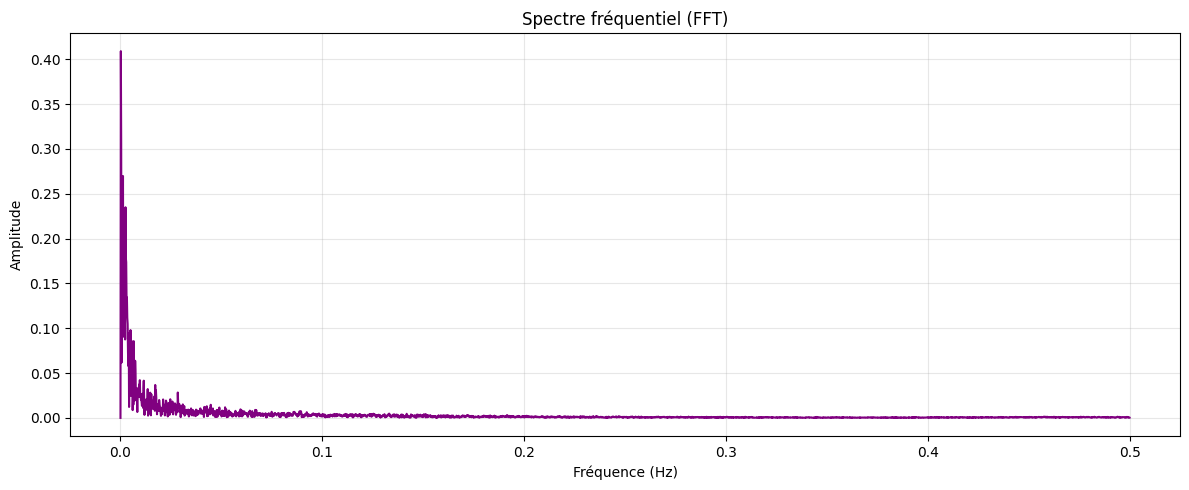

📉 Calcul des critères d’information (AIC / BIC) via modèle ARIMA...
AIC : -17210.9748
BIC : -17184.4271
L1-norm (somme des valeurs absolues) : 105.6712
L2-norm (norme quadratique) : 3.9454


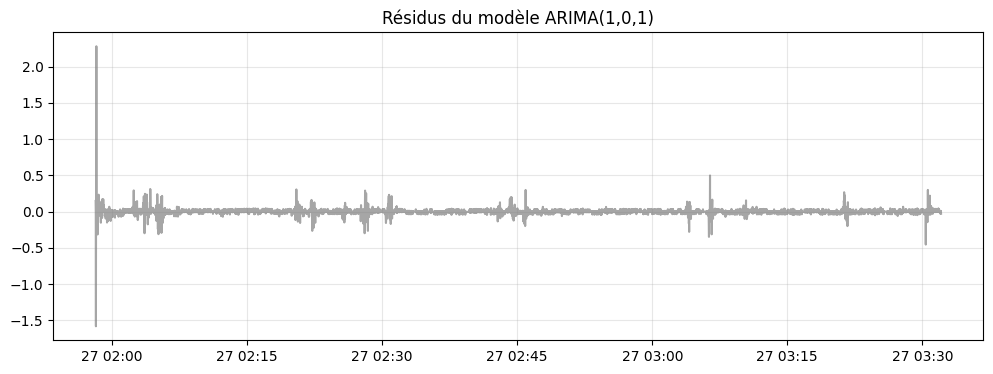

🔁 Autocorrélation globale sur la série...


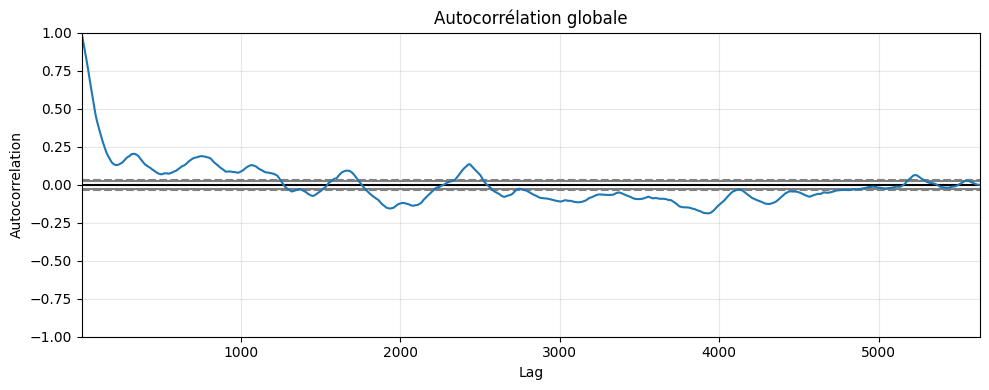

📏 Distance euclidienne entre les deux segments : 51.1399
🔍 Calcul du Matrix Profile pour la détection de motifs...
🏁 Motif principal trouvé à l’indice 2241


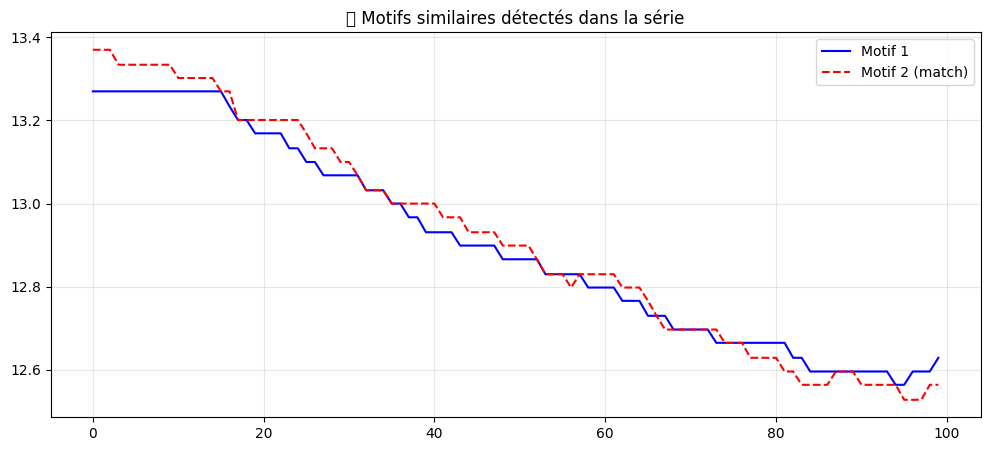

⚠️ Discord (anomalie potentielle) détectée à l’indice 1240


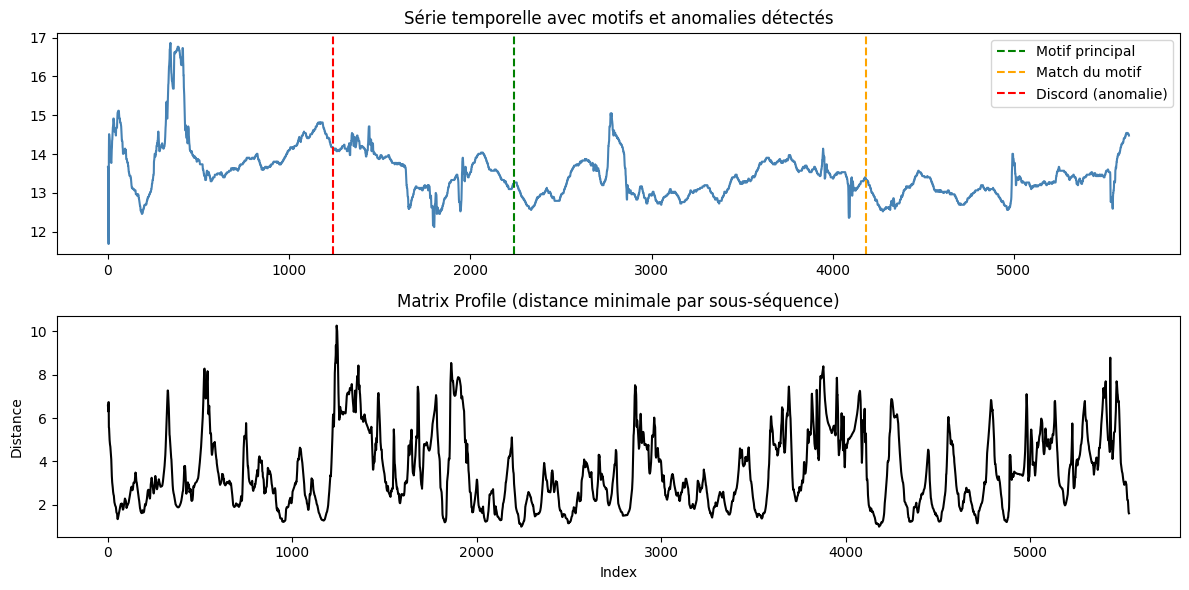

In [ ]:
print("🔍 DIAGNOSTIC DU NETTOYAGE:")
print(f"  Données de départ: {len(semi2_clean)} lignes")
target_col = 'enhanced_speed'

semi2_clean[target_col] = pd.to_numeric(semi2_clean[target_col], errors='coerce')
print(f"  Après conversion numérique: {semi2_clean[target_col].notna().sum()} valeurs non-nulles")

if 'timestamp' in semi2_clean.columns:
    print(f"  Colonne 'timestamp' présente: {semi2_clean['timestamp'].notna().sum()} valeurs non-nulles")
    print(f"  Exemple de valeur timestamp: {semi2_clean['timestamp'].iloc[0]}")
else:
    print(f"  ❌ Colonne 'timestamp' ABSENTE!")

print(f"\n✅ Nettoyage effectué:")
print(f"  - Lignes avant: {len(semi2_clean)}")
print(f"  - Lignes après: {len(semi2_clean)}")
print(f"  - Lignes supprimées: {len(semi2_clean) - len(semi2_clean)}")

if 'timestamp' in semi2_clean.columns:
    print(f"\n🔍 Création de l'index temporel avec 'timestamp'...")
    
    ts_data = semi2_clean[['timestamp', target_col]].copy()
    print(f"  Après sélection colonnes: {len(ts_data)} lignes")
    ts_data = ts_data.dropna()
    print(f"  Après dropna initial: {len(ts_data)} lignes")
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    print(f"  Après conversion datetime: {ts_data['timestamp'].notna().sum()} timestamps valides")
    ts_data = ts_data.dropna()
    print(f"  Après dropna final: {len(ts_data)} lignes")
    
    ts_data = ts_data.set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
    if len(ts_data) > 0:
        print(f"\n⏱️ Plage temporelle de la série :")
        print(f"  Début : {ts_data.index.min()}")
        print(f"  Fin   : {ts_data.index.max()}")
        print(f"  Durée totale : {ts_data.index.max() - ts_data.index.min()}")

    
elif 'timestamp' in semi2_clean.columns:
    ts_data = semi2_clean[['timestamp', target_col]].dropna().copy()
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    ts_data = ts_data.dropna().set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
else:
    ts_data = semi2_clean[[target_col]].dropna().copy()
    ts_data.index = range(len(ts_data))
    print(f"\n✅ Index temporel numérique créé")

print(f"\n{'='*60}")
print(f"RÉSULTAT FINAL: {len(ts_data)} points valides")
print(f"{'='*60}")

if len(ts_data) > 0:
    print(f"\nPremières valeurs de la série:")
    print(ts_data.head())
    print(f"\nStatistiques descriptives:")
    print(ts_data[target_col].describe())
else:
    print("⚠️ ATTENTION: Aucune donnée valide après nettoyage!")
    print("Vérifiez les étapes de diagnostic ci-dessus.")

plt.figure(figsize=(14, 6))
plt.plot(ts_data.index, ts_data[target_col], color='orangered', linewidth=1.5, alpha=0.8)
plt.title(f'Série temporelle: {target_col}', fontsize=16, fontweight='bold')
plt.xlabel('Temps', fontsize=12)
plt.ylabel(f'{target_col} (degrés)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📈 Graphique de la série temporelle affiché")

print("=" * 60)
print("STATISTIQUES DESCRIPTIVES")
print("=" * 60)

stats = {
    'Moyenne': ts_data[target_col].mean(),
    'Médiane': ts_data[target_col].median(),
    'Écart-type': ts_data[target_col].std(),
    'Min': ts_data[target_col].min(),
    'Max': ts_data[target_col].max(),
    'Q1 (25%)': ts_data[target_col].quantile(0.25),
    'Q3 (75%)': ts_data[target_col].quantile(0.75)
}

for key, value in stats.items():
    print(f"{key:15s}: {value:.4f}°")
plt.figure(figsize=(10, 5))
plt.hist(ts_data[target_col], bins=50, color='orangered', edgecolor='black', alpha=0.7)
plt.title(f'Distribution de {target_col}', fontsize=14, fontweight='bold')
plt.xlabel(f'{target_col} (degrés)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if len(ts_data) >= 100:
    print("🔄 Décomposition STL en cours...")
    
    period = min(60, len(ts_data) // 3)
    
    stl = STL(ts_data[target_col], period=period, seasonal=13)
    result = stl.fit()
    
    fig = result.plot()
    fig.set_size_inches(14, 10)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Décomposition STL effectuée (période={period})")
else:
    print(f"⚠️ Série trop courte ({len(ts_data)} points) pour une décomposition STL fiable.")

print("=" * 60)
print("TEST DE STATIONNARITÉ (ADF)")
print("=" * 60)

result_adf = adfuller(ts_data[target_col].dropna())

print(f"\nStatistique ADF: {result_adf[0]:.6f}")
print(f"P-value: {result_adf[1]:.6f}")
print(f"\nValeurs critiques:")
for key, value in result_adf[4].items():
    print(f"  {key}: {value:.3f}")

if result_adf[1] < 0.05:
    print(f"\n✅ La série est STATIONNAIRE (p-value < 0.05)")
else:
    print(f"\n⚠️ La série est NON-STATIONNAIRE (p-value >= 0.05)")
    print("   → Considérer une différenciation ou une transformation")

if len(ts_data) > 30:
    print("📊 Calcul et affichage des fonctions d’autocorrélation...")
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    plot_acf(ts_data[target_col].dropna(), ax=ax[0], lags=40)
    ax[0].set_title("ACF (Autocorrelation Function)")
    
    plot_pacf(ts_data[target_col].dropna(), ax=ax[1], lags=40, method='ywm')
    ax[1].set_title("PACF (Partial Autocorrelation Function)")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Série trop courte pour ACF/PACF fiables.")

print("🔍 Détection des points de rupture dans la série...")

signal = ts_data[target_col].dropna().values
model = "l2"  
algo = rpt.Pelt(model=model).fit(signal)
result = algo.predict(pen=5)

plt.figure(figsize=(14, 5))
plt.plot(signal, color='steelblue')
for cp in result:
    plt.axvline(cp, color='red', linestyle='--', alpha=0.7)
plt.title(f"Change Point Detection sur {target_col}")
plt.show()

print(f"✅ {len(result)-1} ruptures détectées aux indices : {result[:-1]}")

print("🌊 Analyse fréquentielle (Transformée de Fourier)")

y = ts_data[target_col].dropna().values
n = len(y)
timestep = 1  

yf = fft(y - np.mean(y))  
xf = fftfreq(n, timestep)[:n//2]  

plt.figure(figsize=(12, 5))
plt.plot(xf, 2.0/n * np.abs(yf[:n//2]), color='purple')
plt.title("Spectre fréquentiel (FFT)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📉 Calcul des critères d’information (AIC / BIC) via modèle ARIMA...")

try:
    model = ARIMA(ts_data[target_col].dropna(), order=(1, 0, 1))
    result = model.fit()
    
    print(f"AIC : {result.aic:.4f}")
    print(f"BIC : {result.bic:.4f}")
    print(f"L1-norm (somme des valeurs absolues) : {np.sum(np.abs(result.resid)):.4f}")
    print(f"L2-norm (norme quadratique) : {np.sqrt(np.sum(result.resid**2)):.4f}")
    
    plt.figure(figsize=(12, 4))
    plt.plot(result.resid, color='gray', alpha=0.7)
    plt.title("Résidus du modèle ARIMA(1,0,1)")
    plt.grid(True, alpha=0.3)
    plt.show()
except Exception as e:
    print(f"❌ Erreur lors de l’ajustement du modèle ARIMA : {e}")

print("🔁 Autocorrélation globale sur la série...")

plt.figure(figsize=(10, 4))
autocorrelation_plot(ts_data[target_col])
plt.title("Autocorrélation globale")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

y = ts_data[target_col].dropna().values
n = len(y) // 2
segment1, segment2 = y[:n], y[n:2*n]

dist_euclid = euclidean(segment1[:min(len(segment1), len(segment2))],
                        segment2[:min(len(segment1), len(segment2))])

print(f"📏 Distance euclidienne entre les deux segments : {dist_euclid:.4f}")


print("🔍 Calcul du Matrix Profile pour la détection de motifs...")

series = ts_data[target_col].dropna().values.astype(float)

m = 100  

mp = stumpy.stump(series, m=m)


motif_idx = np.argmin(mp[:, 0])
print(f"🏁 Motif principal trouvé à l’indice {motif_idx}")

motif1 = series[motif_idx:motif_idx+m]
motif2 = series[int(mp[motif_idx, 1]):int(mp[motif_idx, 1])+m]


plt.figure(figsize=(12, 5))
plt.plot(motif1, label='Motif 1', color='blue')
plt.plot(motif2, label='Motif 2 (match)', color='red', linestyle='--')
plt.title("🔍 Motifs similaires détectés dans la série")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

discord_idx = np.argmax(mp[:, 0])
print(f"⚠️ Discord (anomalie potentielle) détectée à l’indice {discord_idx}")

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(series, color='steelblue')
plt.axvline(motif_idx, color='green', linestyle='--', label='Motif principal')
plt.axvline(int(mp[motif_idx,1]), color='orange', linestyle='--', label='Match du motif')
plt.axvline(discord_idx, color='red', linestyle='--', label='Discord (anomalie)')
plt.title("Série temporelle avec motifs et anomalies détectés")
plt.legend()

plt.subplot(2,1,2)
plt.plot(mp[:,0], color='black')
plt.title("Matrix Profile (distance minimale par sous-séquence)")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


## Semi 3 

🔍 DIAGNOSTIC DU NETTOYAGE:
  Données de départ: 5187 lignes
  Après conversion numérique: 5187 valeurs non-nulles
  Colonne 'timestamp' présente: 5187 valeurs non-nulles
  Exemple de valeur timestamp: 2025-10-29T13:02:09

✅ Nettoyage effectué:
  - Lignes avant: 5187
  - Lignes après: 5187
  - Lignes supprimées: 0

🔍 Création de l'index temporel avec 'timestamp'...
  Après sélection colonnes: 5187 lignes
  Après dropna initial: 5187 lignes
  Après conversion datetime: 5187 timestamps valides
  Après dropna final: 5187 lignes

✅ Index temporel basé sur 'timestamp'

⏱️ Plage temporelle de la série :
  Début : 2025-10-29 13:02:09
  Fin   : 2025-10-29 17:24:50
  Durée totale : 0 days 04:22:41

RÉSULTAT FINAL: 5187 points valides

Premières valeurs de la série:
                     enhanced_speed
timestamp                          
2025-10-29 13:02:09           9.205
2025-10-29 13:02:10          12.362
2025-10-29 13:02:11          13.504
2025-10-29 13:02:12          14.443
2025-10-29 13:02:1

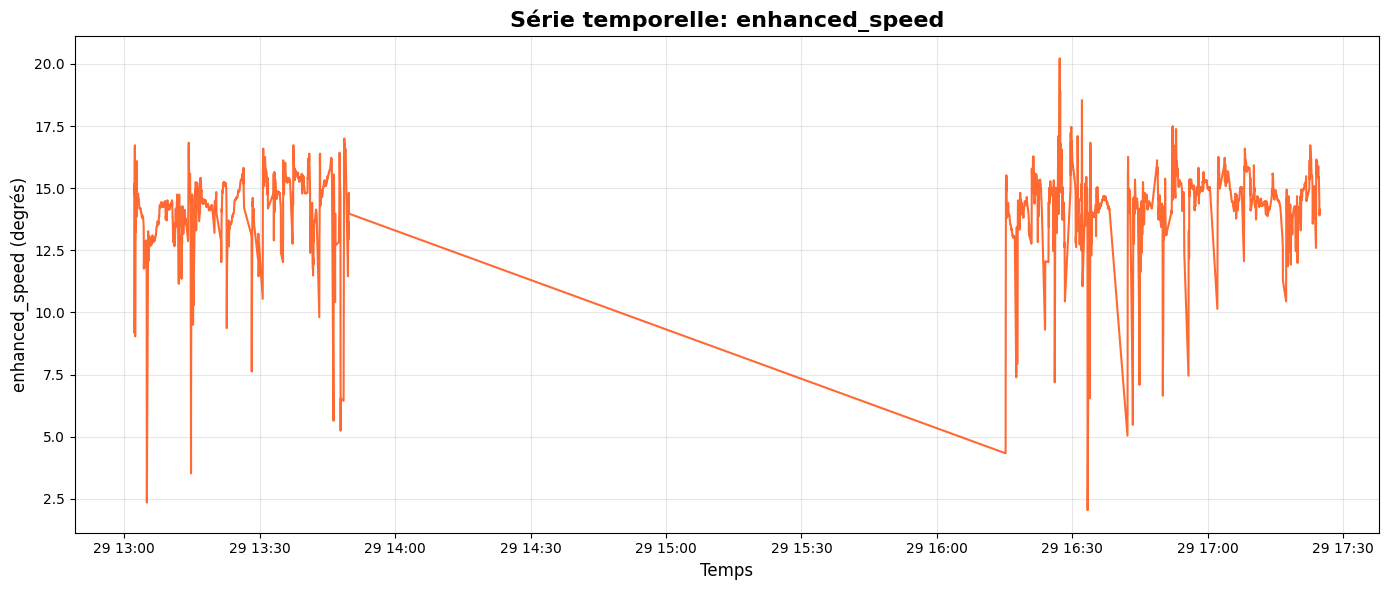

📈 Graphique de la série temporelle affiché
STATISTIQUES DESCRIPTIVES
Moyenne        : 14.3897°
Médiane        : 14.4790°
Écart-type     : 1.2758°
Min            : 2.0480°
Max            : 20.2210°
Q1 (25%)       : 13.9390°
Q3 (75%)       : 15.1160°


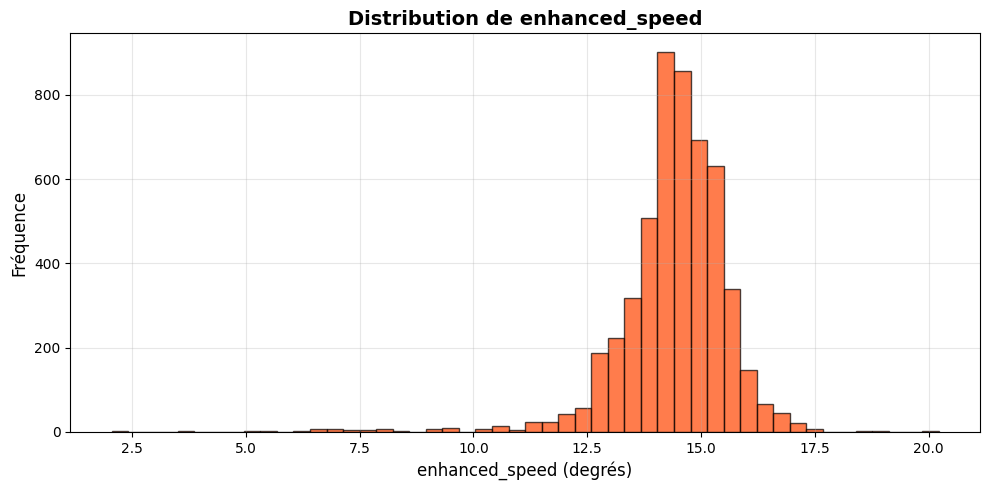

🔄 Décomposition STL en cours...


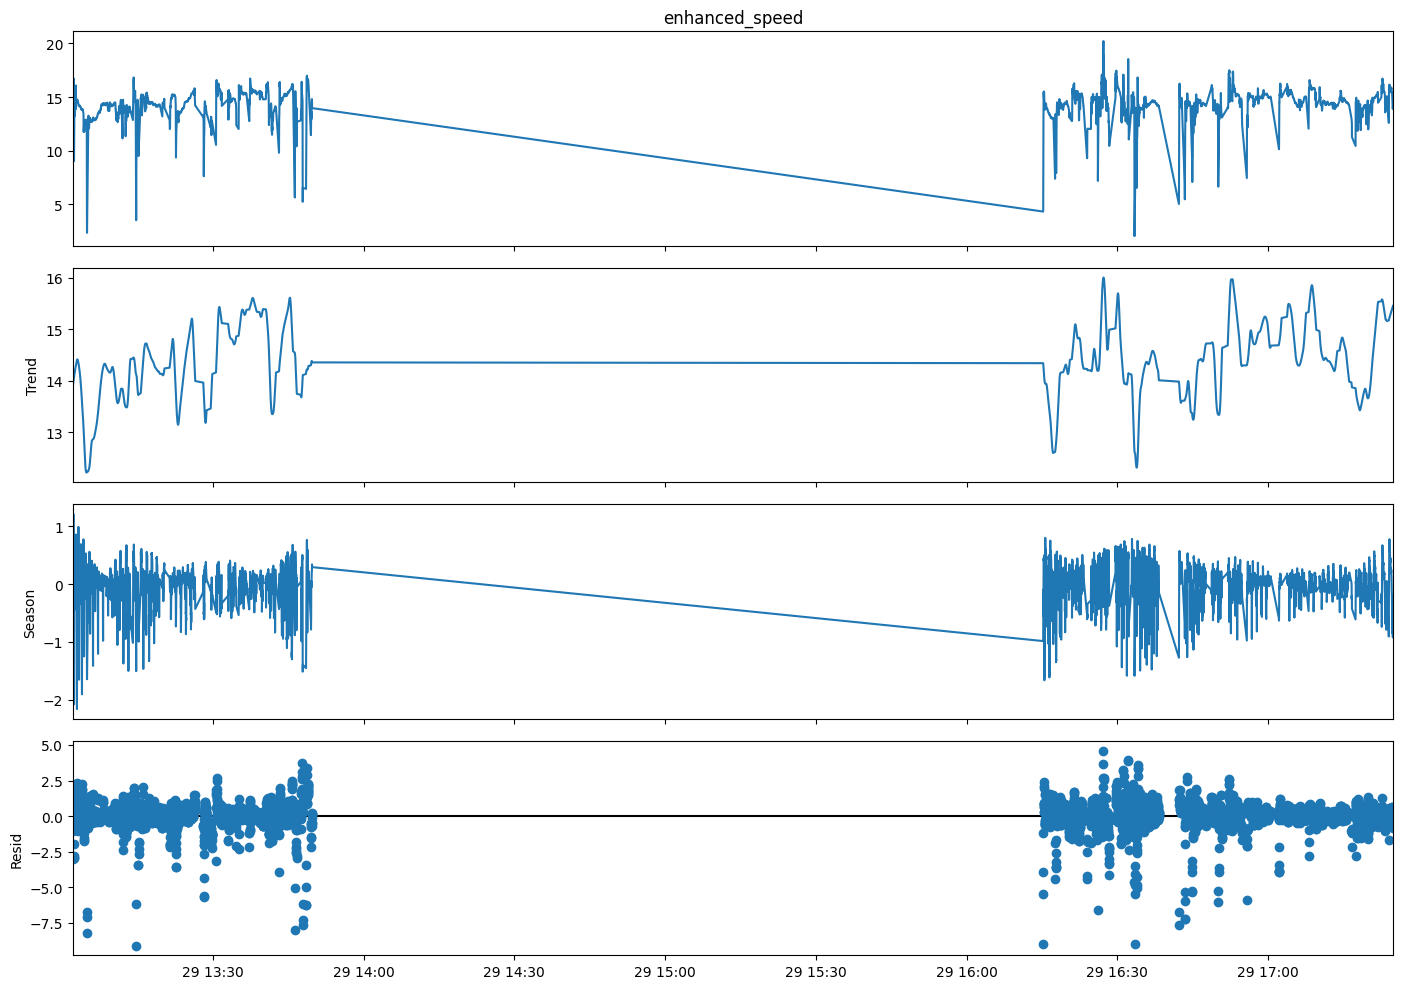

✅ Décomposition STL effectuée (période=60)
TEST DE STATIONNARITÉ (ADF)

Statistique ADF: -7.187719
P-value: 0.000000

Valeurs critiques:
  1%: -3.432
  5%: -2.862
  10%: -2.567

✅ La série est STATIONNAIRE (p-value < 0.05)
📊 Calcul et affichage des fonctions d’autocorrélation...


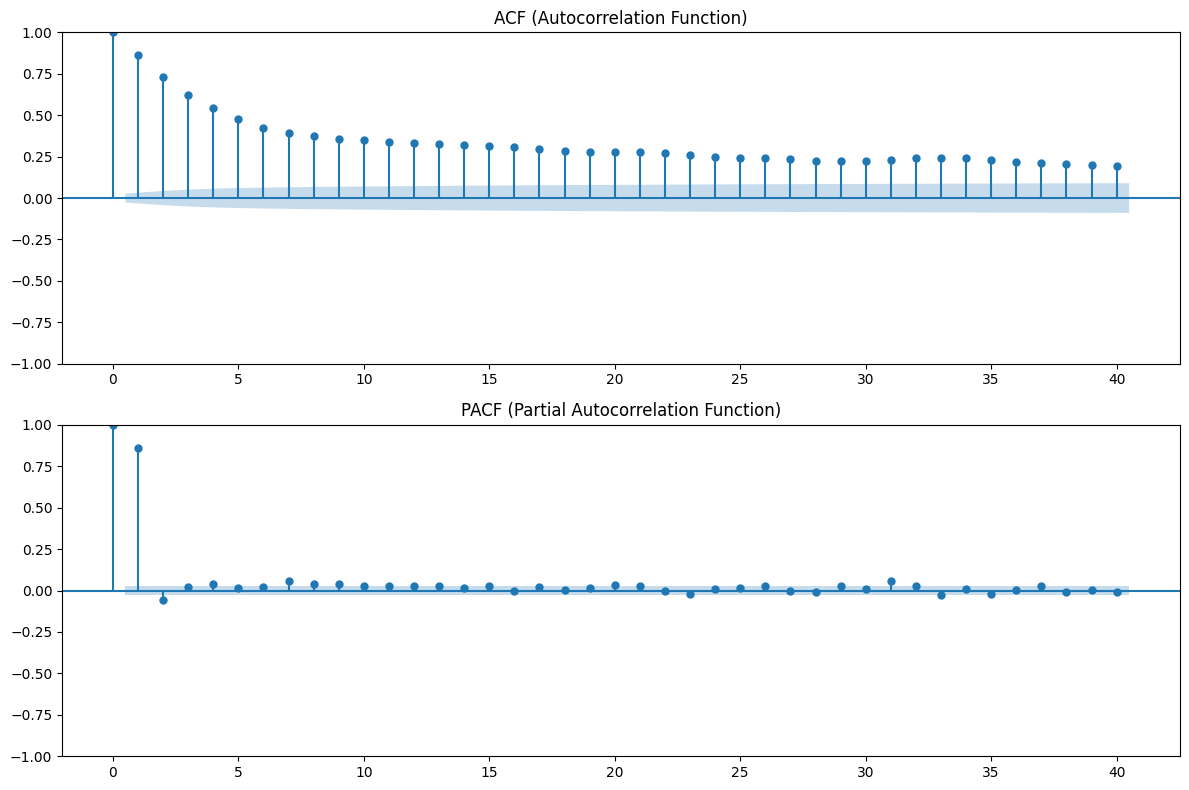

🔍 Détection des points de rupture dans la série...


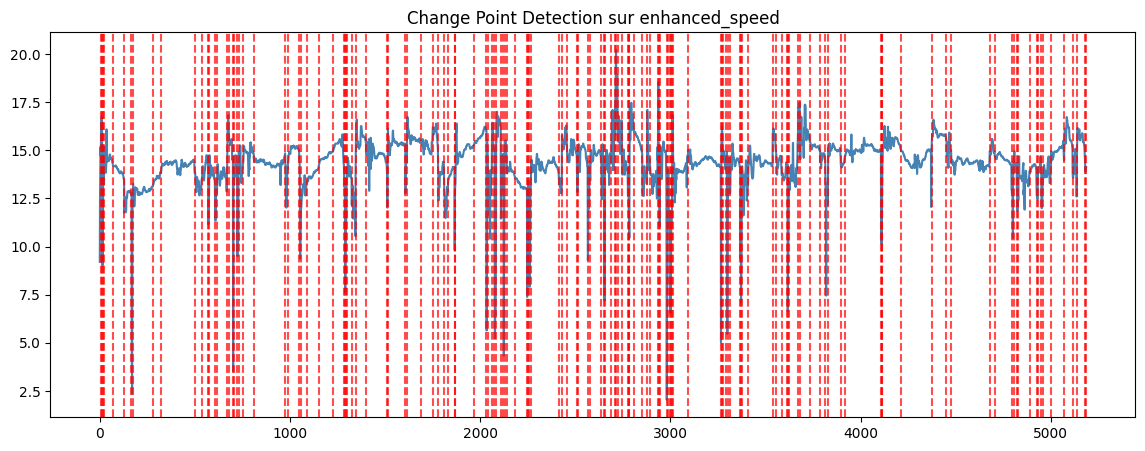

✅ 143 ruptures détectées aux indices : [5, 10, 15, 20, 70, 125, 165, 175, 280, 320, 500, 540, 570, 575, 605, 615, 670, 680, 700, 705, 720, 730, 755, 810, 975, 990, 1050, 1060, 1090, 1150, 1225, 1285, 1290, 1295, 1300, 1325, 1345, 1400, 1510, 1515, 1605, 1615, 1690, 1750, 1780, 1810, 1830, 1865, 1870, 1970, 2030, 2040, 2060, 2075, 2085, 2110, 2120, 2130, 2140, 2185, 2245, 2250, 2255, 2265, 2415, 2430, 2455, 2510, 2515, 2565, 2575, 2635, 2650, 2655, 2690, 2710, 2715, 2725, 2745, 2775, 2780, 2785, 2810, 2850, 2875, 2895, 2935, 2940, 2945, 2980, 2985, 3000, 3005, 3010, 3015, 3090, 3265, 3270, 3275, 3295, 3305, 3315, 3365, 3370, 3375, 3410, 3540, 3555, 3585, 3615, 3620, 3625, 3670, 3680, 3735, 3785, 3815, 3830, 3895, 3920, 4105, 4110, 4115, 4215, 4375, 4450, 4475, 4680, 4705, 4795, 4805, 4820, 4830, 4890, 4925, 4935, 4950, 4960, 5000, 5070, 5115, 5140, 5180]
🌊 Analyse fréquentielle (Transformée de Fourier)


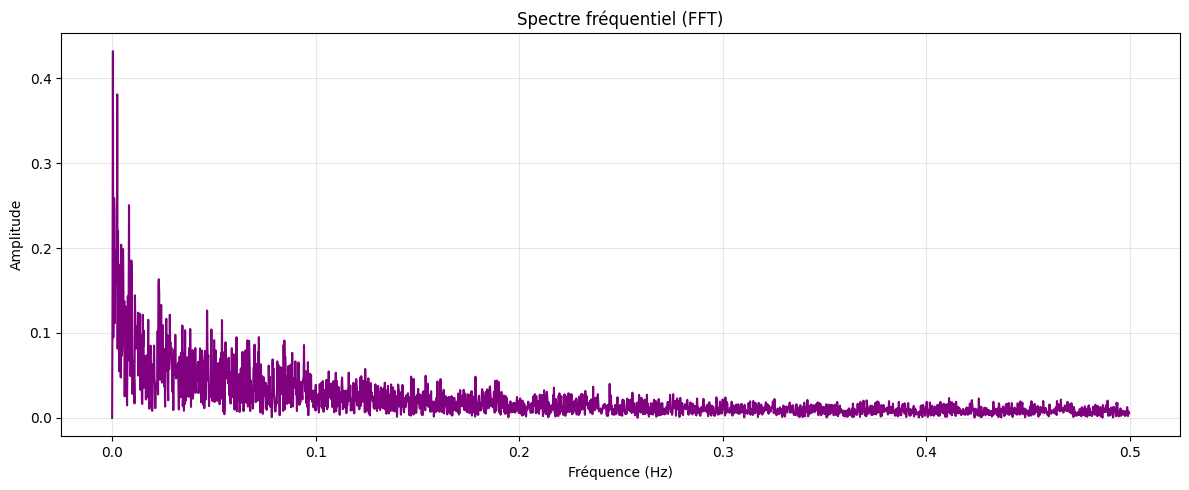

📉 Calcul des critères d’information (AIC / BIC) via modèle ARIMA...
AIC : 10106.9994
BIC : 10133.2151
L1-norm (somme des valeurs absolues) : 1196.7594
L2-norm (norme quadratique) : 46.3437


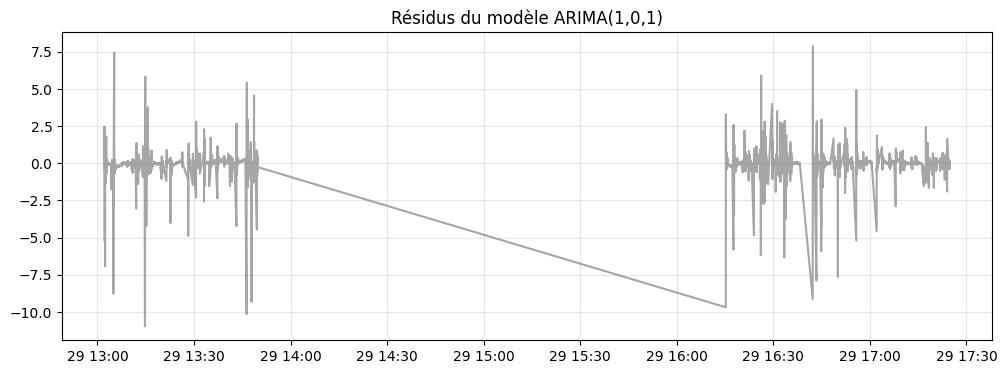

🔁 Autocorrélation globale sur la série...


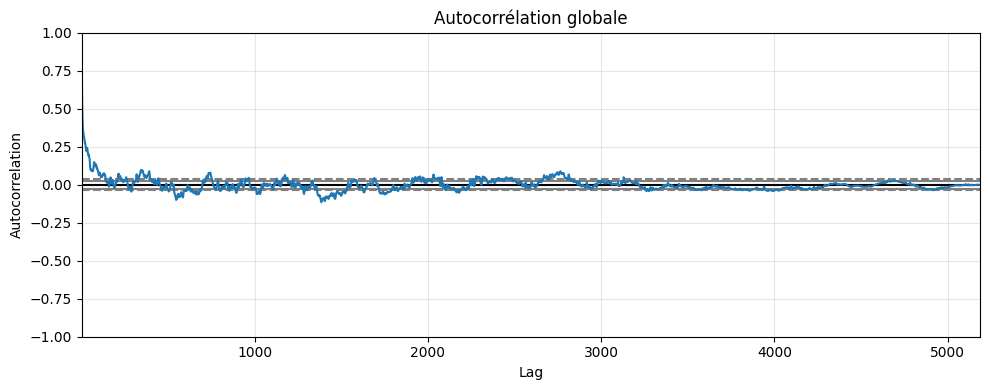

📏 Distance euclidienne entre les deux segments : 92.7995
🔍 Calcul du Matrix Profile pour la détection de motifs...
🏁 Motif principal trouvé à l’indice 1090


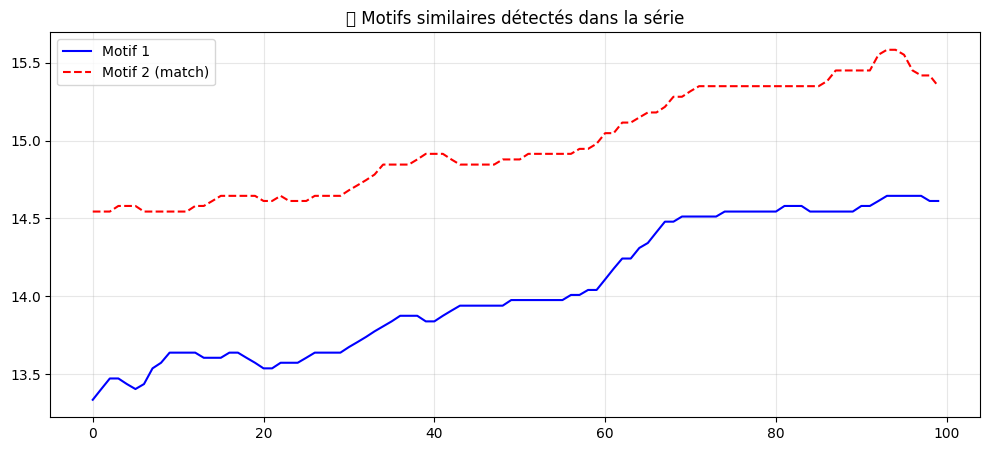

⚠️ Discord (anomalie potentielle) détectée à l’indice 2848


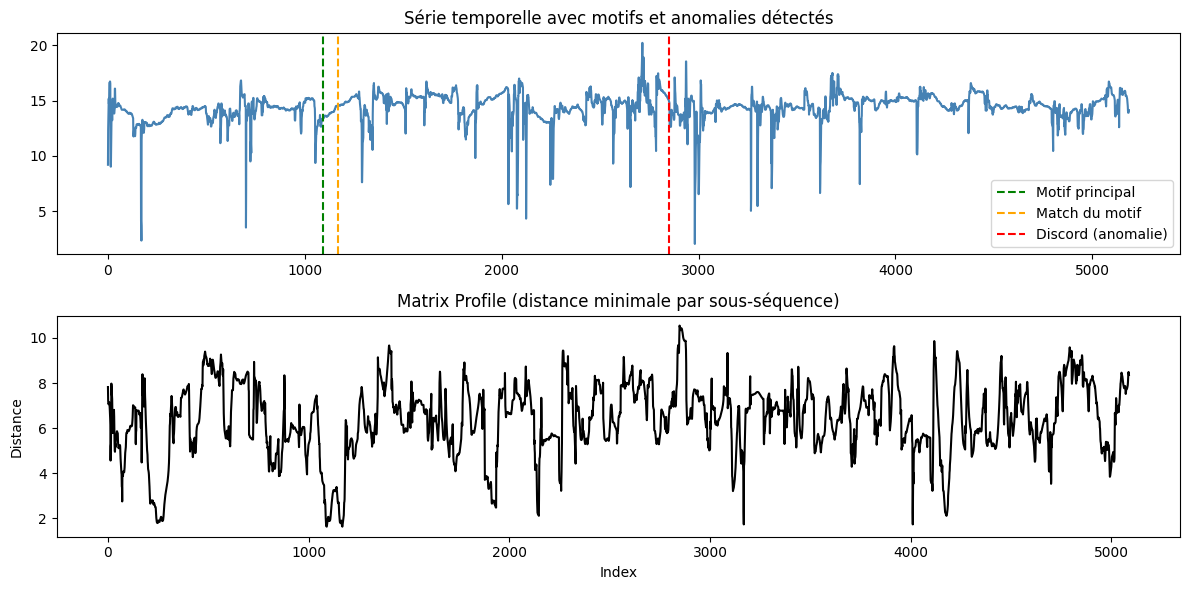

In [ ]:
print("🔍 DIAGNOSTIC DU NETTOYAGE:")
print(f"  Données de départ: {len(semi3_clean)} lignes")
target_col = 'enhanced_speed'

semi3_clean[target_col] = pd.to_numeric(semi3_clean[target_col], errors='coerce')
print(f"  Après conversion numérique: {semi3_clean[target_col].notna().sum()} valeurs non-nulles")

if 'timestamp' in semi3_clean.columns:
    print(f"  Colonne 'timestamp' présente: {semi3_clean['timestamp'].notna().sum()} valeurs non-nulles")
    print(f"  Exemple de valeur timestamp: {semi3_clean['timestamp'].iloc[0]}")
else:
    print(f"  ❌ Colonne 'timestamp' ABSENTE!")

print(f"\n✅ Nettoyage effectué:")
print(f"  - Lignes avant: {len(semi3_clean)}")
print(f"  - Lignes après: {len(semi3_clean)}")
print(f"  - Lignes supprimées: {len(semi3_clean) - len(semi3_clean)}")

if 'timestamp' in semi3_clean.columns:
    print(f"\n🔍 Création de l'index temporel avec 'timestamp'...")
    
    ts_data = semi3_clean[['timestamp', target_col]].copy()
    print(f"  Après sélection colonnes: {len(ts_data)} lignes")
    ts_data = ts_data.dropna()
    print(f"  Après dropna initial: {len(ts_data)} lignes")
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    print(f"  Après conversion datetime: {ts_data['timestamp'].notna().sum()} timestamps valides")
    ts_data = ts_data.dropna()
    print(f"  Après dropna final: {len(ts_data)} lignes")
    
    ts_data = ts_data.set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
    if len(ts_data) > 0:
        print(f"\n⏱️ Plage temporelle de la série :")
        print(f"  Début : {ts_data.index.min()}")
        print(f"  Fin   : {ts_data.index.max()}")
        print(f"  Durée totale : {ts_data.index.max() - ts_data.index.min()}")

    
elif 'timestamp' in semi3_clean.columns:
    ts_data = semi3_clean[['timestamp', target_col]].dropna().copy()
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    ts_data = ts_data.dropna().set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
else:
    ts_data = semi3_clean[[target_col]].dropna().copy()
    ts_data.index = range(len(ts_data))
    print(f"\n✅ Index temporel numérique créé")

print(f"\n{'='*60}")
print(f"RÉSULTAT FINAL: {len(ts_data)} points valides")
print(f"{'='*60}")

if len(ts_data) > 0:
    print(f"\nPremières valeurs de la série:")
    print(ts_data.head())
    print(f"\nStatistiques descriptives:")
    print(ts_data[target_col].describe())
else:
    print("⚠️ ATTENTION: Aucune donnée valide après nettoyage!")
    print("Vérifiez les étapes de diagnostic ci-dessus.")

plt.figure(figsize=(14, 6))
plt.plot(ts_data.index, ts_data[target_col], color='orangered', linewidth=1.5, alpha=0.8)
plt.title(f'Série temporelle: {target_col}', fontsize=16, fontweight='bold')
plt.xlabel('Temps', fontsize=12)
plt.ylabel(f'{target_col} (degrés)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📈 Graphique de la série temporelle affiché")

print("=" * 60)
print("STATISTIQUES DESCRIPTIVES")
print("=" * 60)

stats = {
    'Moyenne': ts_data[target_col].mean(),
    'Médiane': ts_data[target_col].median(),
    'Écart-type': ts_data[target_col].std(),
    'Min': ts_data[target_col].min(),
    'Max': ts_data[target_col].max(),
    'Q1 (25%)': ts_data[target_col].quantile(0.25),
    'Q3 (75%)': ts_data[target_col].quantile(0.75)
}

for key, value in stats.items():
    print(f"{key:15s}: {value:.4f}°")
plt.figure(figsize=(10, 5))
plt.hist(ts_data[target_col], bins=50, color='orangered', edgecolor='black', alpha=0.7)
plt.title(f'Distribution de {target_col}', fontsize=14, fontweight='bold')
plt.xlabel(f'{target_col} (degrés)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if len(ts_data) >= 100:
    print("🔄 Décomposition STL en cours...")
    
    period = min(60, len(ts_data) // 3)
    
    stl = STL(ts_data[target_col], period=period, seasonal=13)
    result = stl.fit()
    
    fig = result.plot()
    fig.set_size_inches(14, 10)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Décomposition STL effectuée (période={period})")
else:
    print(f"⚠️ Série trop courte ({len(ts_data)} points) pour une décomposition STL fiable.")

print("=" * 60)
print("TEST DE STATIONNARITÉ (ADF)")
print("=" * 60)

result_adf = adfuller(ts_data[target_col].dropna())

print(f"\nStatistique ADF: {result_adf[0]:.6f}")
print(f"P-value: {result_adf[1]:.6f}")
print(f"\nValeurs critiques:")
for key, value in result_adf[4].items():
    print(f"  {key}: {value:.3f}")

if result_adf[1] < 0.05:
    print(f"\n✅ La série est STATIONNAIRE (p-value < 0.05)")
else:
    print(f"\n⚠️ La série est NON-STATIONNAIRE (p-value >= 0.05)")
    print("   → Considérer une différenciation ou une transformation")

if len(ts_data) > 30:
    print("📊 Calcul et affichage des fonctions d’autocorrélation...")
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    plot_acf(ts_data[target_col].dropna(), ax=ax[0], lags=40)
    ax[0].set_title("ACF (Autocorrelation Function)")
    
    plot_pacf(ts_data[target_col].dropna(), ax=ax[1], lags=40, method='ywm')
    ax[1].set_title("PACF (Partial Autocorrelation Function)")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Série trop courte pour ACF/PACF fiables.")

print("🔍 Détection des points de rupture dans la série...")

signal = ts_data[target_col].dropna().values
model = "l2"  
algo = rpt.Pelt(model=model).fit(signal)
result = algo.predict(pen=5)

plt.figure(figsize=(14, 5))
plt.plot(signal, color='steelblue')
for cp in result:
    plt.axvline(cp, color='red', linestyle='--', alpha=0.7)
plt.title(f"Change Point Detection sur {target_col}")
plt.show()

print(f"✅ {len(result)-1} ruptures détectées aux indices : {result[:-1]}")

print("🌊 Analyse fréquentielle (Transformée de Fourier)")

y = ts_data[target_col].dropna().values
n = len(y)
timestep = 1  

yf = fft(y - np.mean(y))  
xf = fftfreq(n, timestep)[:n//2]  

plt.figure(figsize=(12, 5))
plt.plot(xf, 2.0/n * np.abs(yf[:n//2]), color='purple')
plt.title("Spectre fréquentiel (FFT)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📉 Calcul des critères d’information (AIC / BIC) via modèle ARIMA...")

try:
    model = ARIMA(ts_data[target_col].dropna(), order=(1, 0, 1))
    result = model.fit()
    
    print(f"AIC : {result.aic:.4f}")
    print(f"BIC : {result.bic:.4f}")
    print(f"L1-norm (somme des valeurs absolues) : {np.sum(np.abs(result.resid)):.4f}")
    print(f"L2-norm (norme quadratique) : {np.sqrt(np.sum(result.resid**2)):.4f}")
    
    plt.figure(figsize=(12, 4))
    plt.plot(result.resid, color='gray', alpha=0.7)
    plt.title("Résidus du modèle ARIMA(1,0,1)")
    plt.grid(True, alpha=0.3)
    plt.show()
except Exception as e:
    print(f"❌ Erreur lors de l’ajustement du modèle ARIMA : {e}")

print("🔁 Autocorrélation globale sur la série...")

plt.figure(figsize=(10, 4))
autocorrelation_plot(ts_data[target_col])
plt.title("Autocorrélation globale")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

y = ts_data[target_col].dropna().values
n = len(y) // 2
segment1, segment2 = y[:n], y[n:2*n]

dist_euclid = euclidean(segment1[:min(len(segment1), len(segment2))],
                        segment2[:min(len(segment1), len(segment2))])

print(f"📏 Distance euclidienne entre les deux segments : {dist_euclid:.4f}")


print("🔍 Calcul du Matrix Profile pour la détection de motifs...")

series = ts_data[target_col].dropna().values.astype(float)

m = 100  

mp = stumpy.stump(series, m=m)


motif_idx = np.argmin(mp[:, 0])
print(f"🏁 Motif principal trouvé à l’indice {motif_idx}")

motif1 = series[motif_idx:motif_idx+m]
motif2 = series[int(mp[motif_idx, 1]):int(mp[motif_idx, 1])+m]


plt.figure(figsize=(12, 5))
plt.plot(motif1, label='Motif 1', color='blue')
plt.plot(motif2, label='Motif 2 (match)', color='red', linestyle='--')
plt.title("🔍 Motifs similaires détectés dans la série")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

discord_idx = np.argmax(mp[:, 0])
print(f"⚠️ Discord (anomalie potentielle) détectée à l’indice {discord_idx}")

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(series, color='steelblue')
plt.axvline(motif_idx, color='green', linestyle='--', label='Motif principal')
plt.axvline(int(mp[motif_idx,1]), color='orange', linestyle='--', label='Match du motif')
plt.axvline(discord_idx, color='red', linestyle='--', label='Discord (anomalie)')
plt.title("Série temporelle avec motifs et anomalies détectés")
plt.legend()

plt.subplot(2,1,2)
plt.plot(mp[:,0], color='black')
plt.title("Matrix Profile (distance minimale par sous-séquence)")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


## 10 km 1 

🔍 DIAGNOSTIC DU NETTOYAGE:
  Données de départ: 3022 lignes
  Après conversion numérique: 3022 valeurs non-nulles
  Colonne 'timestamp' présente: 3022 valeurs non-nulles
  Exemple de valeur timestamp: 2024-09-11T09:39:47

✅ Nettoyage effectué:
  - Lignes avant: 3022
  - Lignes après: 3022
  - Lignes supprimées: 0

🔍 Création de l'index temporel avec 'timestamp'...
  Après sélection colonnes: 3022 lignes
  Après dropna initial: 3022 lignes
  Après conversion datetime: 3022 timestamps valides
  Après dropna final: 3022 lignes

✅ Index temporel basé sur 'timestamp'

⏱️ Plage temporelle de la série :
  Début : 2024-09-11 09:39:47
  Fin   : 2024-09-11 10:33:44
  Durée totale : 0 days 00:53:57

RÉSULTAT FINAL: 3022 points valides

Premières valeurs de la série:
                     enhanced_speed
timestamp                          
2024-09-11 09:39:47          10.447
2024-09-11 09:39:48           9.976
2024-09-11 09:39:49           9.976
2024-09-11 09:39:50          11.419
2024-09-11 09:39:5

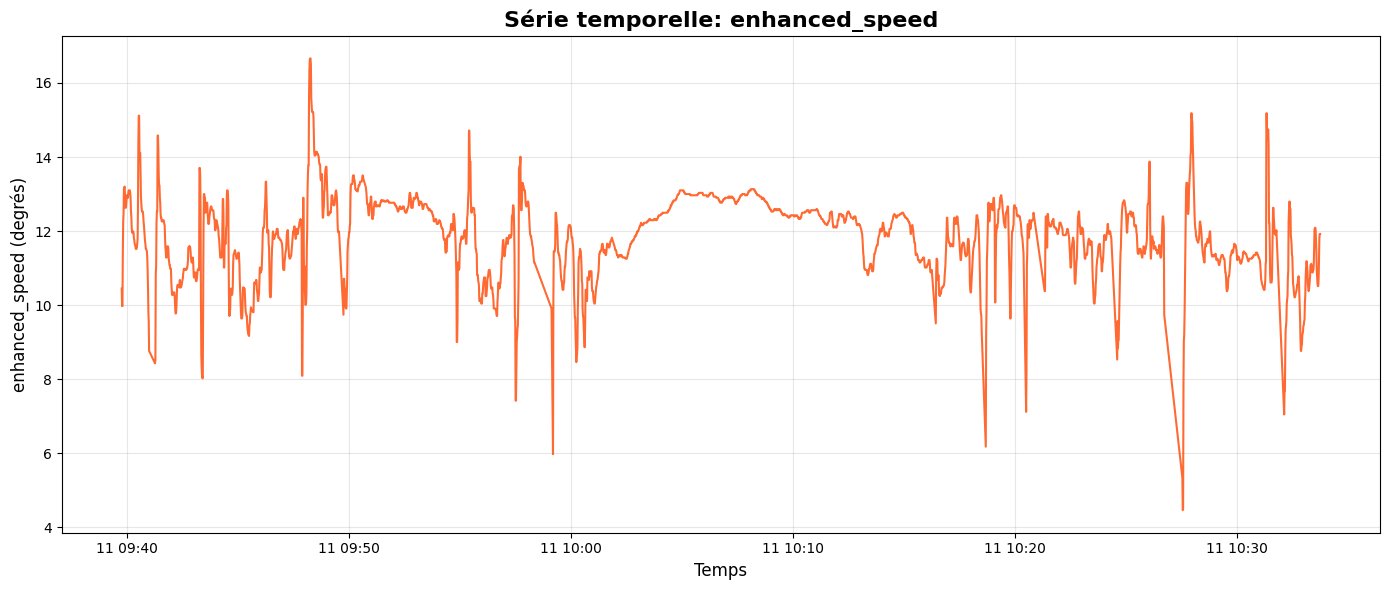

📈 Graphique de la série temporelle affiché
STATISTIQUES DESCRIPTIVES
Moyenne        : 11.8760°
Médiane        : 12.0240°
Écart-type     : 1.0812°
Min            : 4.4680°
Max            : 16.6610°
Q1 (25%)       : 11.2860°
Q3 (75%)       : 12.5640°


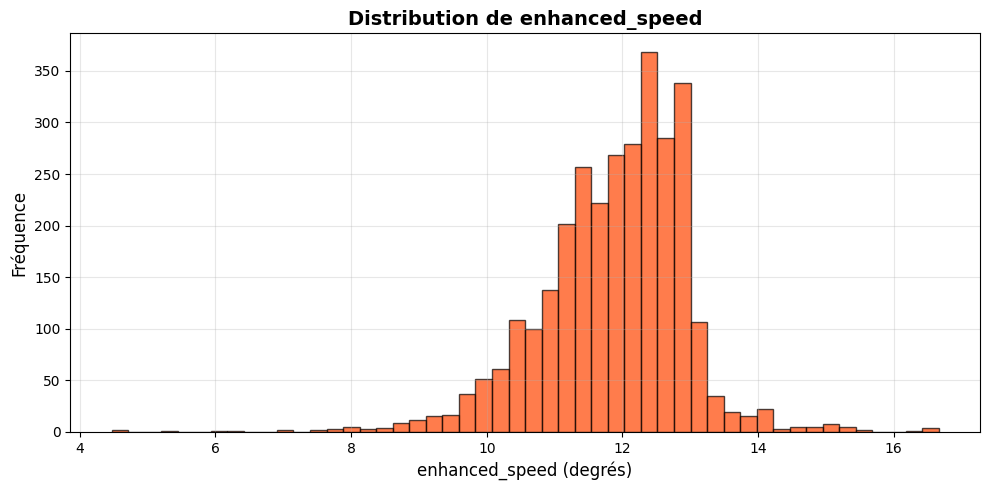

🔄 Décomposition STL en cours...


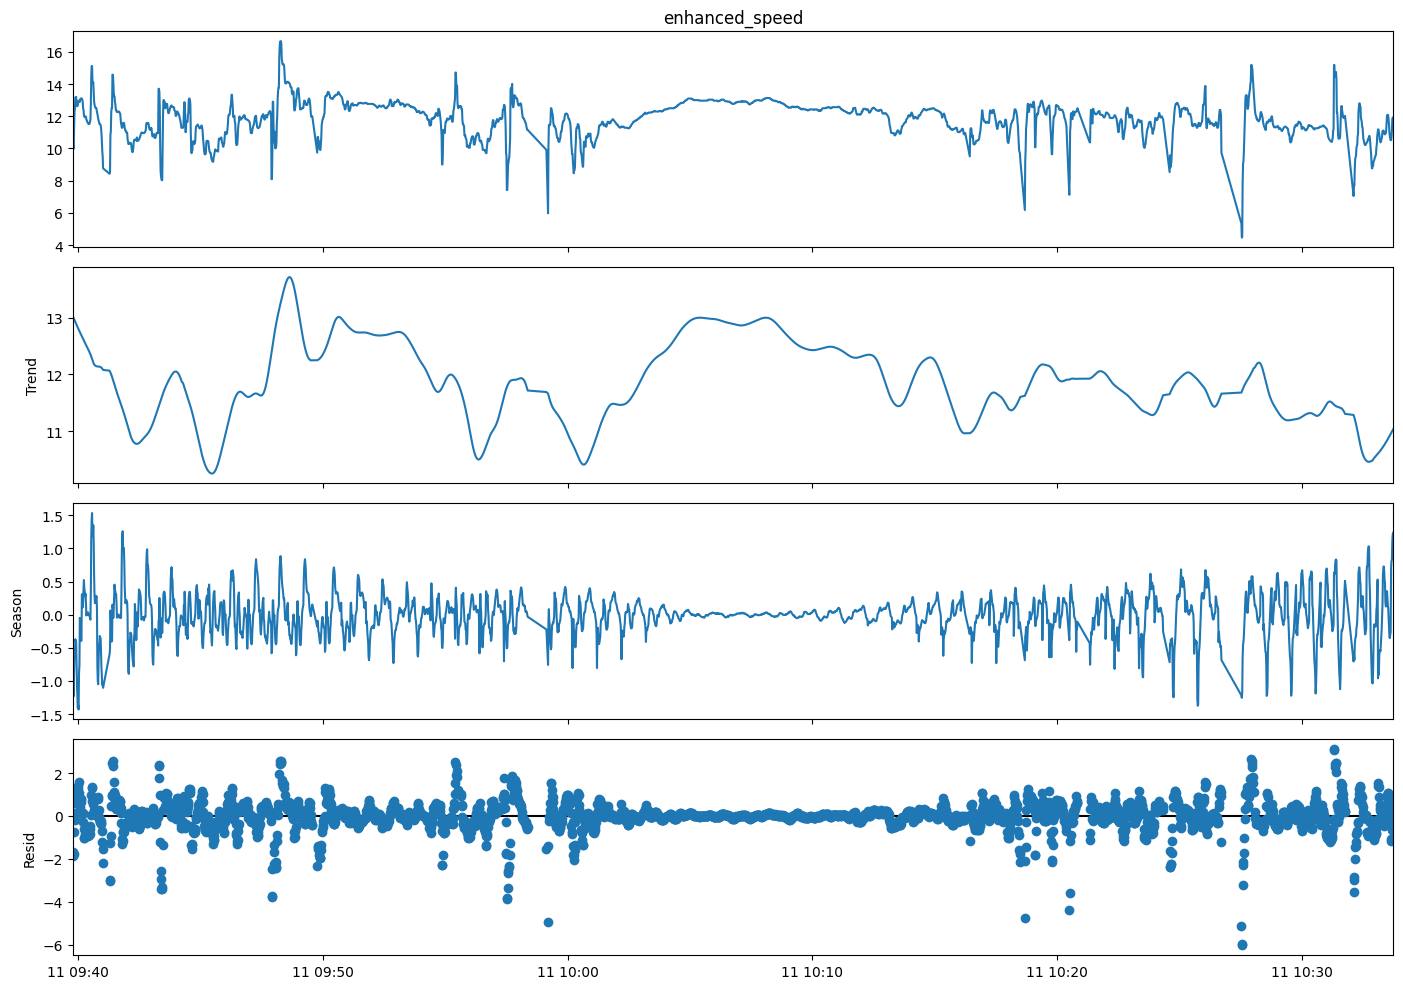

✅ Décomposition STL effectuée (période=60)
TEST DE STATIONNARITÉ (ADF)

Statistique ADF: -5.242824
P-value: 0.000007

Valeurs critiques:
  1%: -3.433
  5%: -2.863
  10%: -2.567

✅ La série est STATIONNAIRE (p-value < 0.05)
📊 Calcul et affichage des fonctions d’autocorrélation...


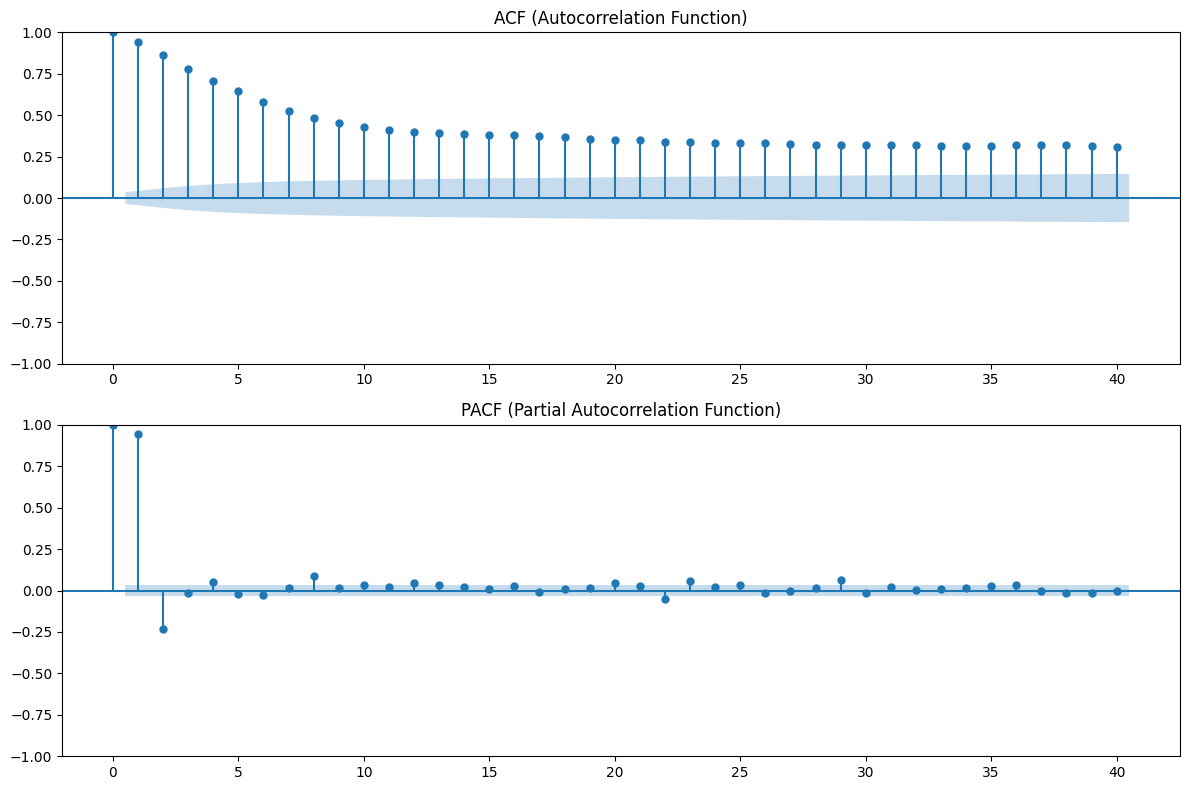

🔍 Détection des points de rupture dans la série...


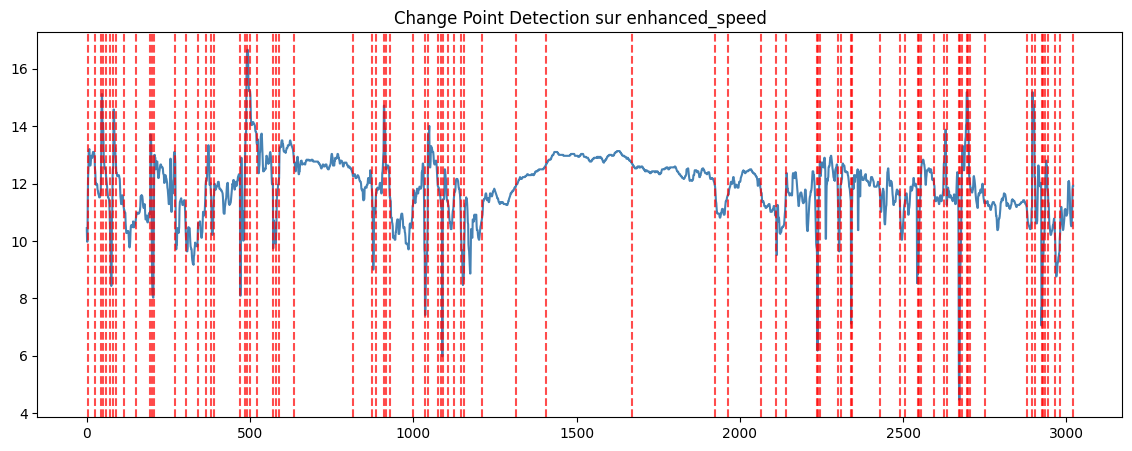

✅ 85 ruptures détectées aux indices : [5, 25, 45, 50, 60, 70, 80, 90, 115, 150, 195, 200, 205, 270, 305, 340, 365, 380, 390, 470, 485, 490, 500, 520, 570, 580, 590, 635, 815, 875, 885, 910, 915, 930, 1000, 1035, 1045, 1075, 1085, 1090, 1105, 1125, 1145, 1155, 1210, 1315, 1405, 1670, 1925, 1965, 2065, 2110, 2140, 2235, 2240, 2245, 2300, 2310, 2340, 2345, 2430, 2490, 2505, 2545, 2550, 2555, 2595, 2625, 2635, 2670, 2675, 2680, 2695, 2700, 2705, 2750, 2880, 2895, 2905, 2925, 2930, 2935, 2945, 2965, 2980]
🌊 Analyse fréquentielle (Transformée de Fourier)


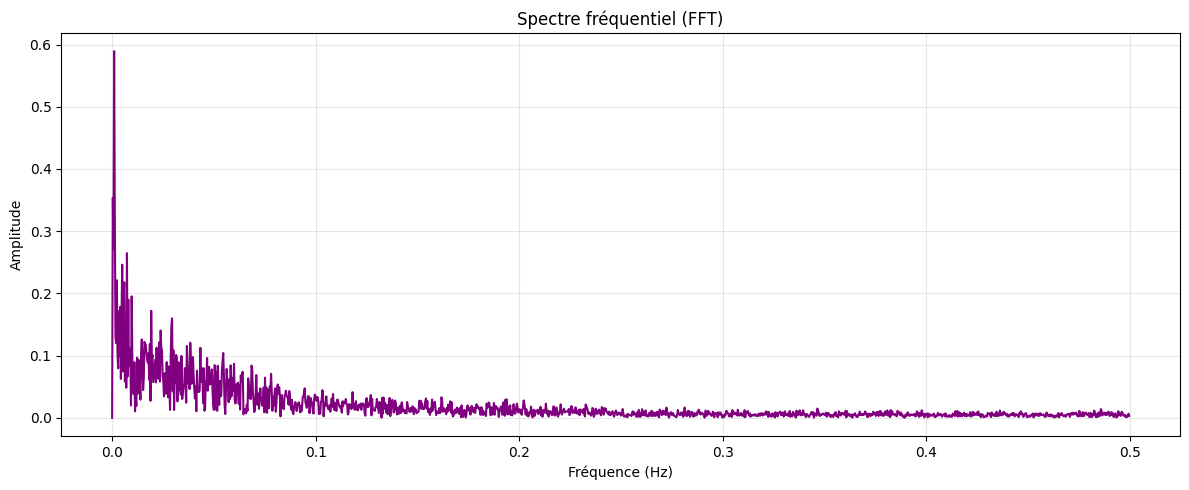

📉 Calcul des critères d’information (AIC / BIC) via modèle ARIMA...
AIC : 2290.2269
BIC : 2314.2816
L1-norm (somme des valeurs absolues) : 419.4493
L2-norm (norme quadratique) : 19.4439


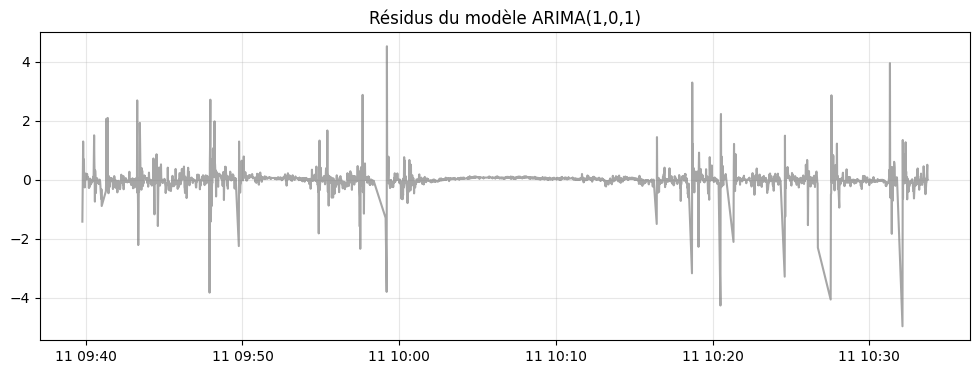

🔁 Autocorrélation globale sur la série...


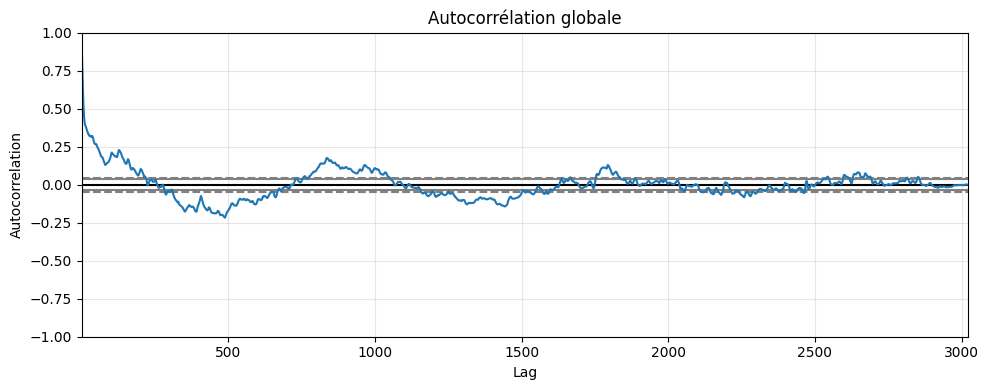

📏 Distance euclidienne entre les deux segments : 62.0086
🔍 Calcul du Matrix Profile pour la détection de motifs...
🏁 Motif principal trouvé à l’indice 1611


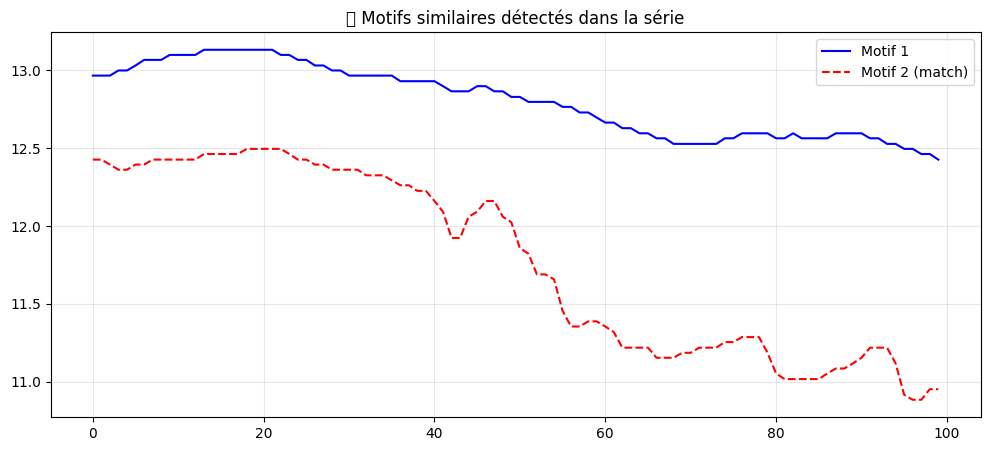

⚠️ Discord (anomalie potentielle) détectée à l’indice 380


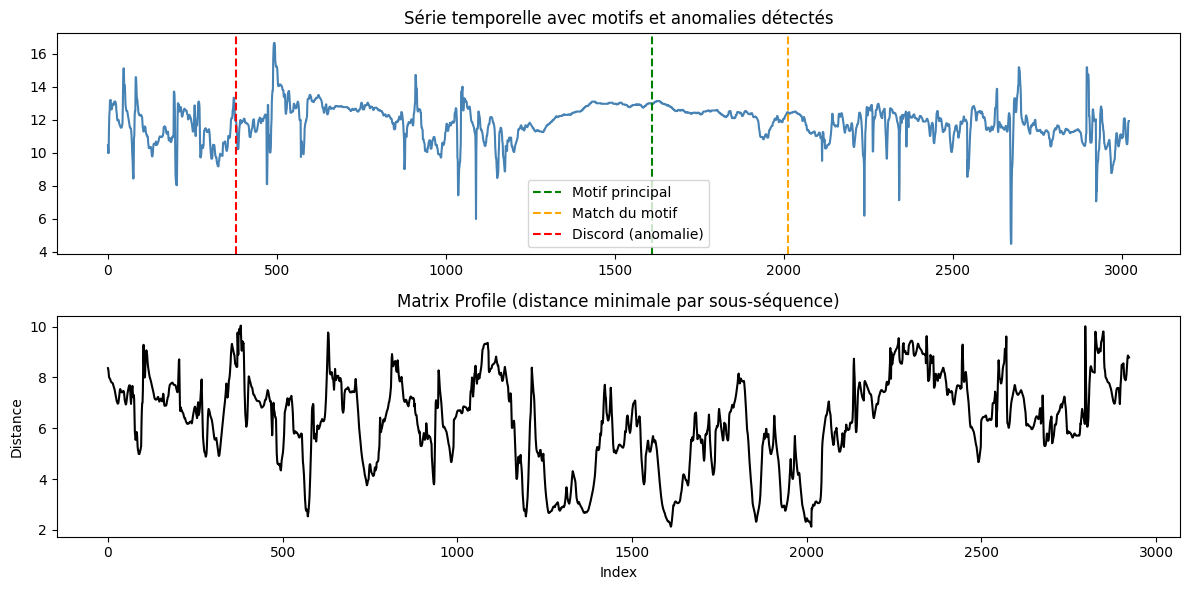

In [ ]:
print("🔍 DIAGNOSTIC DU NETTOYAGE:")
print(f"  Données de départ: {len(dix1_clean)} lignes")
target_col = 'enhanced_speed'

dix1_clean[target_col] = pd.to_numeric(dix1_clean[target_col], errors='coerce')
print(f"  Après conversion numérique: {dix1_clean[target_col].notna().sum()} valeurs non-nulles")

if 'timestamp' in dix1_clean.columns:
    print(f"  Colonne 'timestamp' présente: {dix1_clean['timestamp'].notna().sum()} valeurs non-nulles")
    print(f"  Exemple de valeur timestamp: {dix1_clean['timestamp'].iloc[0]}")
else:
    print(f"  ❌ Colonne 'timestamp' ABSENTE!")

print(f"\n✅ Nettoyage effectué:")
print(f"  - Lignes avant: {len(dix1_clean)}")
print(f"  - Lignes après: {len(dix1_clean)}")
print(f"  - Lignes supprimées: {len(dix1_clean) - len(dix1_clean)}")

if 'timestamp' in dix1_clean.columns:
    print(f"\n🔍 Création de l'index temporel avec 'timestamp'...")
    
    ts_data = dix1_clean[['timestamp', target_col]].copy()
    print(f"  Après sélection colonnes: {len(ts_data)} lignes")
    ts_data = ts_data.dropna()
    print(f"  Après dropna initial: {len(ts_data)} lignes")
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    print(f"  Après conversion datetime: {ts_data['timestamp'].notna().sum()} timestamps valides")
    ts_data = ts_data.dropna()
    print(f"  Après dropna final: {len(ts_data)} lignes")
    
    ts_data = ts_data.set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
    if len(ts_data) > 0:
        print(f"\n⏱️ Plage temporelle de la série :")
        print(f"  Début : {ts_data.index.min()}")
        print(f"  Fin   : {ts_data.index.max()}")
        print(f"  Durée totale : {ts_data.index.max() - ts_data.index.min()}")

    
elif 'timestamp' in dix1_clean.columns:
    ts_data = dix1_clean[['timestamp', target_col]].dropna().copy()
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    ts_data = ts_data.dropna().set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
else:
    ts_data = dix1_clean[[target_col]].dropna().copy()
    ts_data.index = range(len(ts_data))
    print(f"\n✅ Index temporel numérique créé")

print(f"\n{'='*60}")
print(f"RÉSULTAT FINAL: {len(ts_data)} points valides")
print(f"{'='*60}")

if len(ts_data) > 0:
    print(f"\nPremières valeurs de la série:")
    print(ts_data.head())
    print(f"\nStatistiques descriptives:")
    print(ts_data[target_col].describe())
else:
    print("⚠️ ATTENTION: Aucune donnée valide après nettoyage!")
    print("Vérifiez les étapes de diagnostic ci-dessus.")

plt.figure(figsize=(14, 6))
plt.plot(ts_data.index, ts_data[target_col], color='orangered', linewidth=1.5, alpha=0.8)
plt.title(f'Série temporelle: {target_col}', fontsize=16, fontweight='bold')
plt.xlabel('Temps', fontsize=12)
plt.ylabel(f'{target_col} (degrés)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📈 Graphique de la série temporelle affiché")

print("=" * 60)
print("STATISTIQUES DESCRIPTIVES")
print("=" * 60)

stats = {
    'Moyenne': ts_data[target_col].mean(),
    'Médiane': ts_data[target_col].median(),
    'Écart-type': ts_data[target_col].std(),
    'Min': ts_data[target_col].min(),
    'Max': ts_data[target_col].max(),
    'Q1 (25%)': ts_data[target_col].quantile(0.25),
    'Q3 (75%)': ts_data[target_col].quantile(0.75)
}

for key, value in stats.items():
    print(f"{key:15s}: {value:.4f}°")
plt.figure(figsize=(10, 5))
plt.hist(ts_data[target_col], bins=50, color='orangered', edgecolor='black', alpha=0.7)
plt.title(f'Distribution de {target_col}', fontsize=14, fontweight='bold')
plt.xlabel(f'{target_col} (degrés)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if len(ts_data) >= 100:
    print("🔄 Décomposition STL en cours...")
    
    period = min(60, len(ts_data) // 3)
    
    stl = STL(ts_data[target_col], period=period, seasonal=13)
    result = stl.fit()
    
    fig = result.plot()
    fig.set_size_inches(14, 10)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Décomposition STL effectuée (période={period})")
else:
    print(f"⚠️ Série trop courte ({len(ts_data)} points) pour une décomposition STL fiable.")

print("=" * 60)
print("TEST DE STATIONNARITÉ (ADF)")
print("=" * 60)

result_adf = adfuller(ts_data[target_col].dropna())

print(f"\nStatistique ADF: {result_adf[0]:.6f}")
print(f"P-value: {result_adf[1]:.6f}")
print(f"\nValeurs critiques:")
for key, value in result_adf[4].items():
    print(f"  {key}: {value:.3f}")

if result_adf[1] < 0.05:
    print(f"\n✅ La série est STATIONNAIRE (p-value < 0.05)")
else:
    print(f"\n⚠️ La série est NON-STATIONNAIRE (p-value >= 0.05)")
    print("   → Considérer une différenciation ou une transformation")

if len(ts_data) > 30:
    print("📊 Calcul et affichage des fonctions d’autocorrélation...")
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    plot_acf(ts_data[target_col].dropna(), ax=ax[0], lags=40)
    ax[0].set_title("ACF (Autocorrelation Function)")
    
    plot_pacf(ts_data[target_col].dropna(), ax=ax[1], lags=40, method='ywm')
    ax[1].set_title("PACF (Partial Autocorrelation Function)")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Série trop courte pour ACF/PACF fiables.")

print("🔍 Détection des points de rupture dans la série...")

signal = ts_data[target_col].dropna().values
model = "l2"  
algo = rpt.Pelt(model=model).fit(signal)
result = algo.predict(pen=5)

plt.figure(figsize=(14, 5))
plt.plot(signal, color='steelblue')
for cp in result:
    plt.axvline(cp, color='red', linestyle='--', alpha=0.7)
plt.title(f"Change Point Detection sur {target_col}")
plt.show()

print(f"✅ {len(result)-1} ruptures détectées aux indices : {result[:-1]}")

print("🌊 Analyse fréquentielle (Transformée de Fourier)")

y = ts_data[target_col].dropna().values
n = len(y)
timestep = 1  

yf = fft(y - np.mean(y))  
xf = fftfreq(n, timestep)[:n//2]  

plt.figure(figsize=(12, 5))
plt.plot(xf, 2.0/n * np.abs(yf[:n//2]), color='purple')
plt.title("Spectre fréquentiel (FFT)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📉 Calcul des critères d’information (AIC / BIC) via modèle ARIMA...")

try:
    model = ARIMA(ts_data[target_col].dropna(), order=(1, 0, 1))
    result = model.fit()
    
    print(f"AIC : {result.aic:.4f}")
    print(f"BIC : {result.bic:.4f}")
    print(f"L1-norm (somme des valeurs absolues) : {np.sum(np.abs(result.resid)):.4f}")
    print(f"L2-norm (norme quadratique) : {np.sqrt(np.sum(result.resid**2)):.4f}")
    
    plt.figure(figsize=(12, 4))
    plt.plot(result.resid, color='gray', alpha=0.7)
    plt.title("Résidus du modèle ARIMA(1,0,1)")
    plt.grid(True, alpha=0.3)
    plt.show()
except Exception as e:
    print(f"❌ Erreur lors de l’ajustement du modèle ARIMA : {e}")

print("🔁 Autocorrélation globale sur la série...")

plt.figure(figsize=(10, 4))
autocorrelation_plot(ts_data[target_col])
plt.title("Autocorrélation globale")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

y = ts_data[target_col].dropna().values
n = len(y) // 2
segment1, segment2 = y[:n], y[n:2*n]

dist_euclid = euclidean(segment1[:min(len(segment1), len(segment2))],
                        segment2[:min(len(segment1), len(segment2))])

print(f"📏 Distance euclidienne entre les deux segments : {dist_euclid:.4f}")


print("🔍 Calcul du Matrix Profile pour la détection de motifs...")

series = ts_data[target_col].dropna().values.astype(float)

m = 100  

mp = stumpy.stump(series, m=m)


motif_idx = np.argmin(mp[:, 0])
print(f"🏁 Motif principal trouvé à l’indice {motif_idx}")

motif1 = series[motif_idx:motif_idx+m]
motif2 = series[int(mp[motif_idx, 1]):int(mp[motif_idx, 1])+m]


plt.figure(figsize=(12, 5))
plt.plot(motif1, label='Motif 1', color='blue')
plt.plot(motif2, label='Motif 2 (match)', color='red', linestyle='--')
plt.title("🔍 Motifs similaires détectés dans la série")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

discord_idx = np.argmax(mp[:, 0])
print(f"⚠️ Discord (anomalie potentielle) détectée à l’indice {discord_idx}")

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(series, color='steelblue')
plt.axvline(motif_idx, color='green', linestyle='--', label='Motif principal')
plt.axvline(int(mp[motif_idx,1]), color='orange', linestyle='--', label='Match du motif')
plt.axvline(discord_idx, color='red', linestyle='--', label='Discord (anomalie)')
plt.title("Série temporelle avec motifs et anomalies détectés")
plt.legend()

plt.subplot(2,1,2)
plt.plot(mp[:,0], color='black')
plt.title("Matrix Profile (distance minimale par sous-séquence)")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


## 10 km 2

🔍 DIAGNOSTIC DU NETTOYAGE:
  Données de départ: 2732 lignes
  Après conversion numérique: 2732 valeurs non-nulles
  Colonne 'timestamp' présente: 2732 valeurs non-nulles
  Exemple de valeur timestamp: 2025-05-21T09:29:43

✅ Nettoyage effectué:
  - Lignes avant: 2732
  - Lignes après: 2732
  - Lignes supprimées: 0

🔍 Création de l'index temporel avec 'timestamp'...
  Après sélection colonnes: 2732 lignes
  Après dropna initial: 2732 lignes
  Après conversion datetime: 2732 timestamps valides
  Après dropna final: 2732 lignes

✅ Index temporel basé sur 'timestamp'

⏱️ Plage temporelle de la série :
  Début : 2025-05-21 09:29:43
  Fin   : 2025-05-21 10:18:41
  Durée totale : 0 days 00:48:58

RÉSULTAT FINAL: 2732 points valides

Premières valeurs de la série:
                     enhanced_speed
timestamp                          
2025-05-21 09:29:43          13.032
2025-05-21 09:29:44          13.774
2025-05-21 09:29:45          14.512
2025-05-21 09:29:46          14.512
2025-05-21 09:29:4

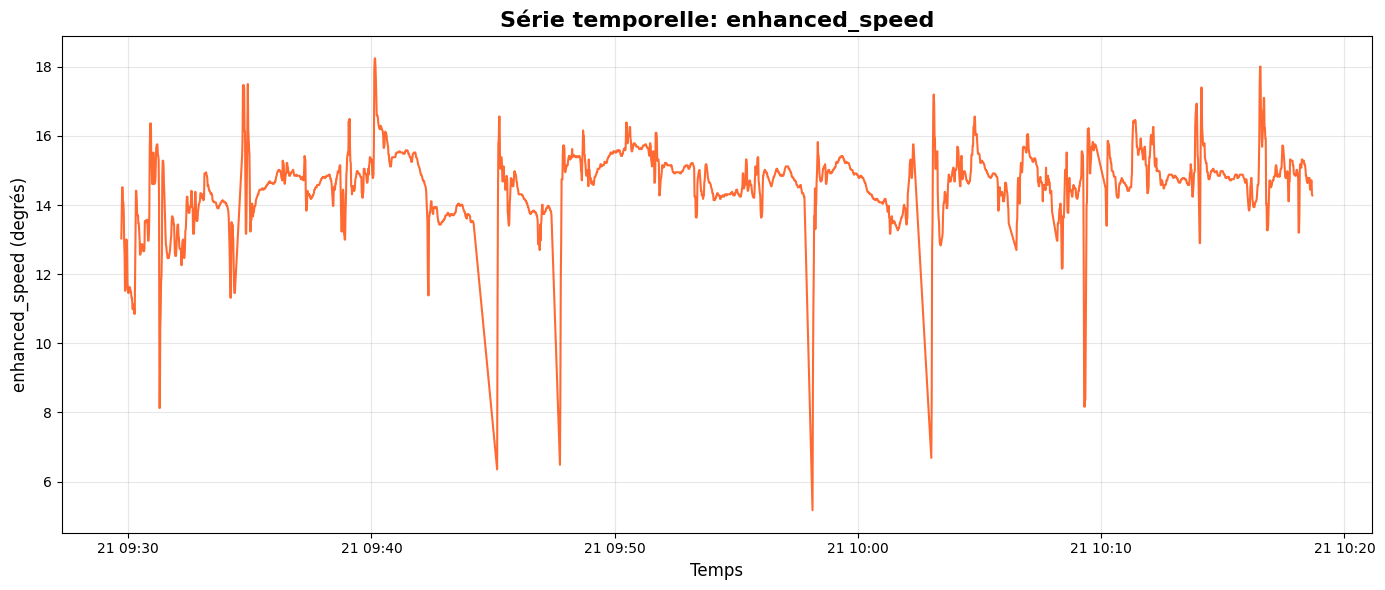

📈 Graphique de la série temporelle affiché
STATISTIQUES DESCRIPTIVES
Moyenne        : 14.6170°
Médiane        : 14.7460°
Écart-type     : 1.0033°
Min            : 5.1730°
Max            : 18.2410°
Q1 (25%)       : 14.2090°
Q3 (75%)       : 15.1490°


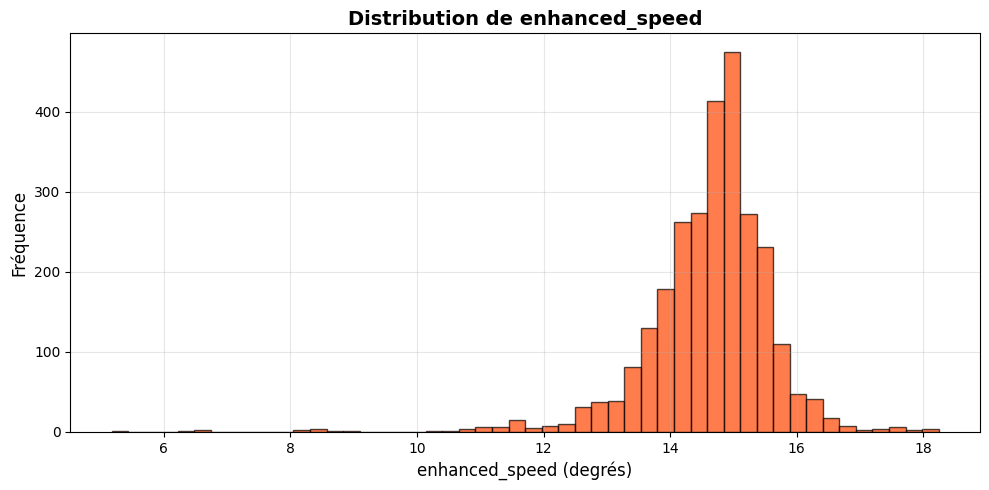

🔄 Décomposition STL en cours...


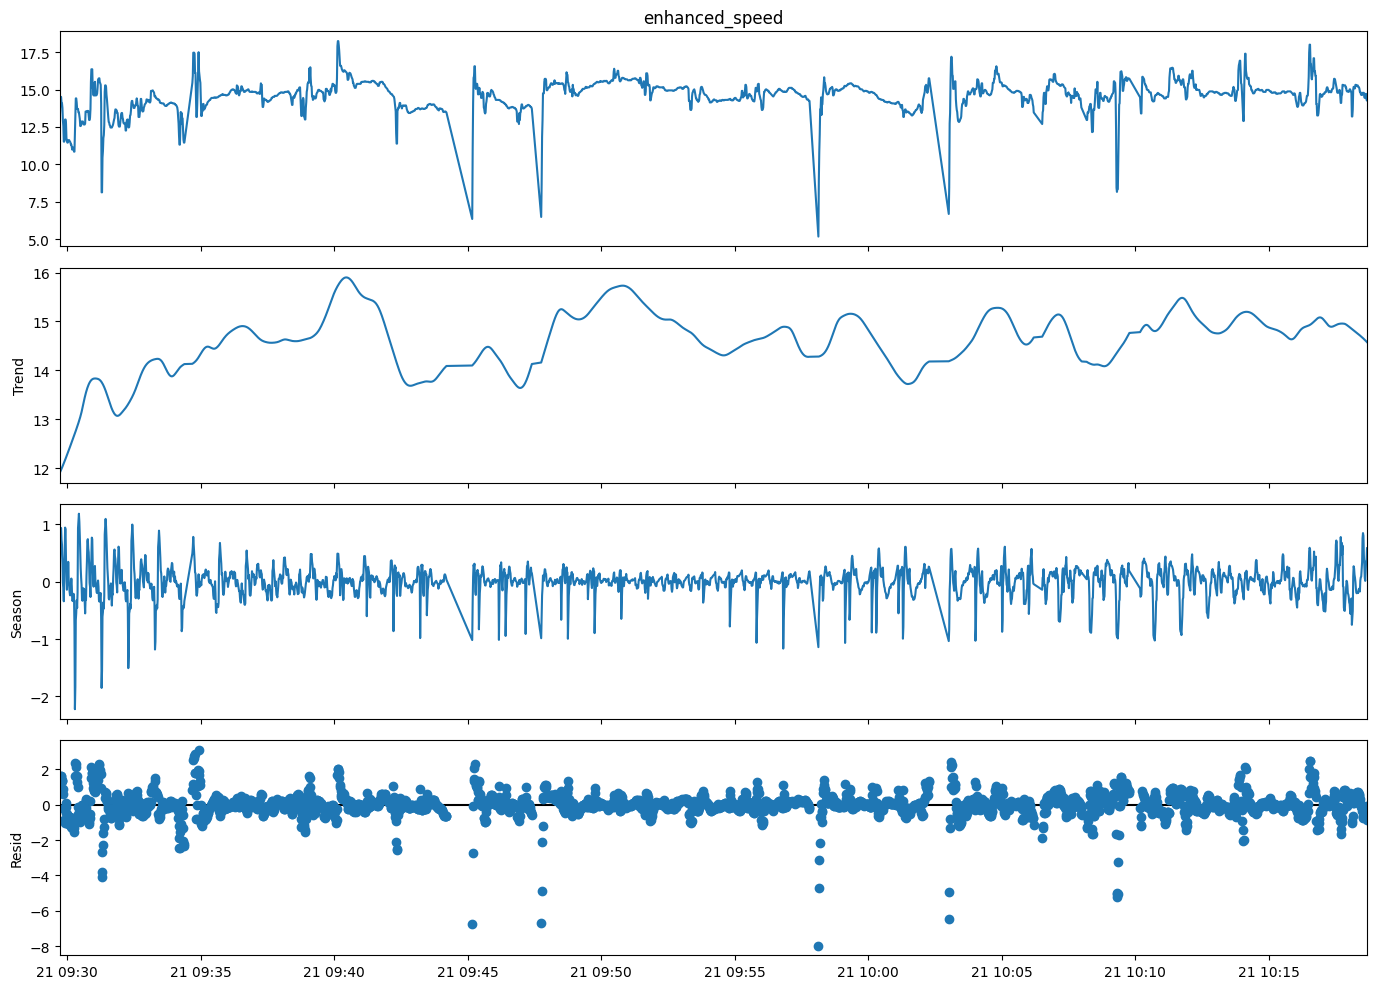

✅ Décomposition STL effectuée (période=60)
TEST DE STATIONNARITÉ (ADF)

Statistique ADF: -8.138269
P-value: 0.000000

Valeurs critiques:
  1%: -3.433
  5%: -2.863
  10%: -2.567

✅ La série est STATIONNAIRE (p-value < 0.05)
📊 Calcul et affichage des fonctions d’autocorrélation...


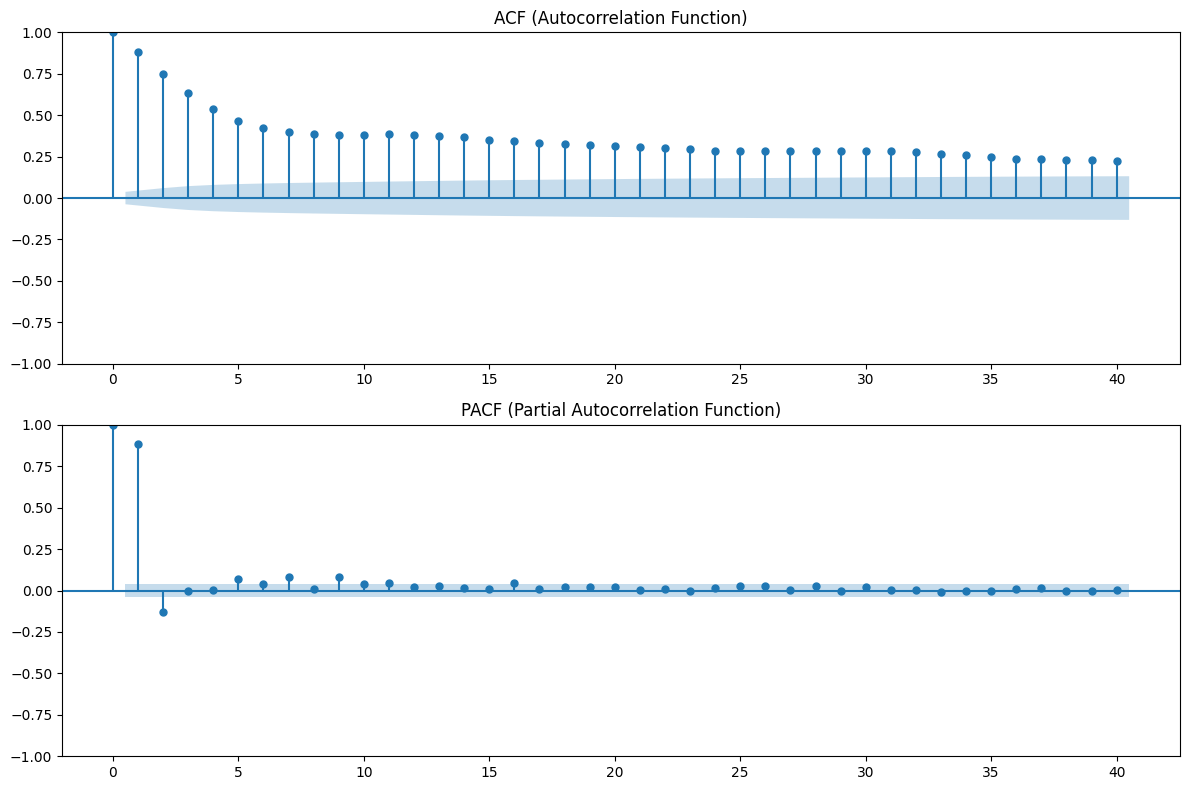

🔍 Détection des points de rupture dans la série...


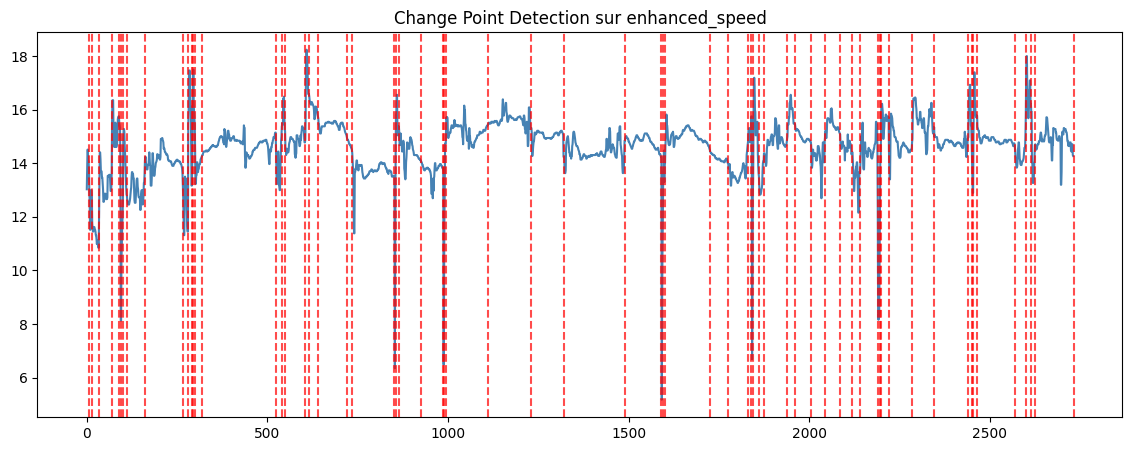

✅ 65 ruptures détectées aux indices : [5, 15, 35, 70, 90, 95, 100, 110, 160, 265, 280, 290, 295, 300, 320, 525, 540, 550, 605, 615, 640, 720, 735, 850, 855, 865, 925, 985, 990, 995, 1110, 1230, 1320, 1490, 1590, 1595, 1600, 1725, 1775, 1830, 1840, 1845, 1860, 1875, 1940, 1960, 2005, 2045, 2085, 2120, 2140, 2190, 2195, 2200, 2220, 2285, 2345, 2440, 2450, 2455, 2465, 2570, 2600, 2615, 2625]
🌊 Analyse fréquentielle (Transformée de Fourier)


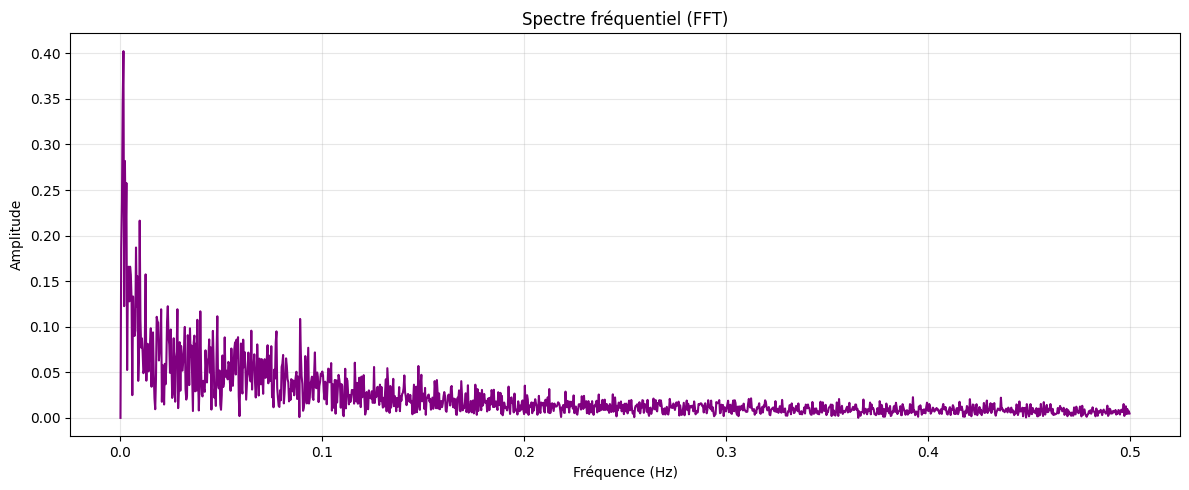

📉 Calcul des critères d’information (AIC / BIC) via modèle ARIMA...
AIC : 3609.6144
BIC : 3633.2656
L1-norm (somme des valeurs absolues) : 482.8238
L2-norm (norme quadratique) : 24.4827


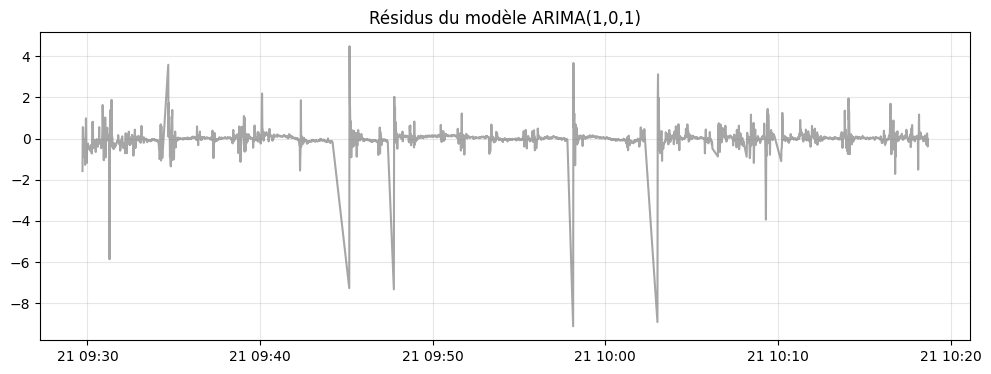

🔁 Autocorrélation globale sur la série...


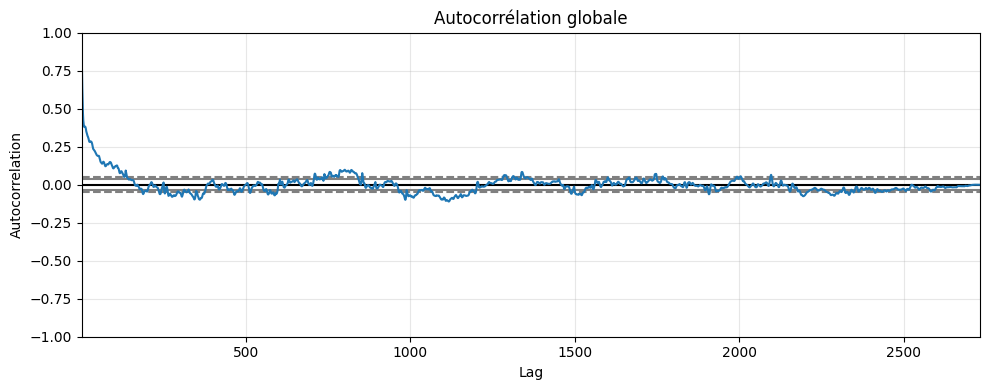

📏 Distance euclidienne entre les deux segments : 50.7481
🔍 Calcul du Matrix Profile pour la détection de motifs...
🏁 Motif principal trouvé à l’indice 754


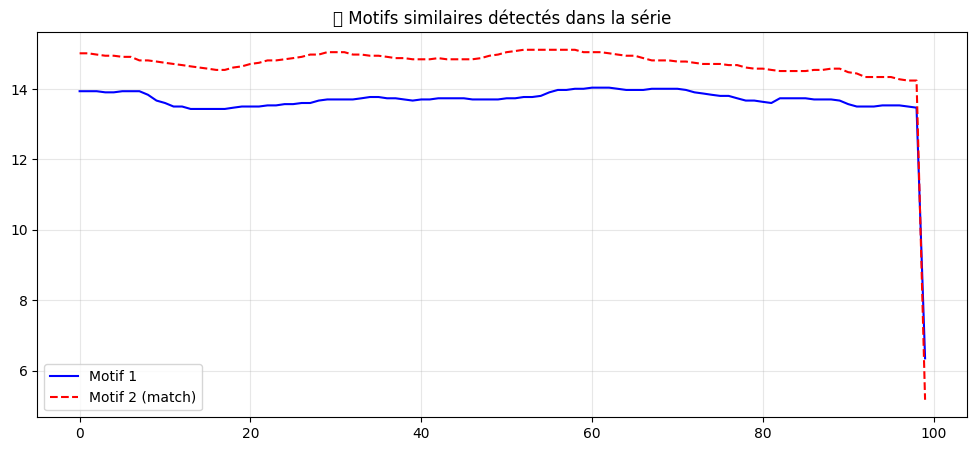

⚠️ Discord (anomalie potentielle) détectée à l’indice 411


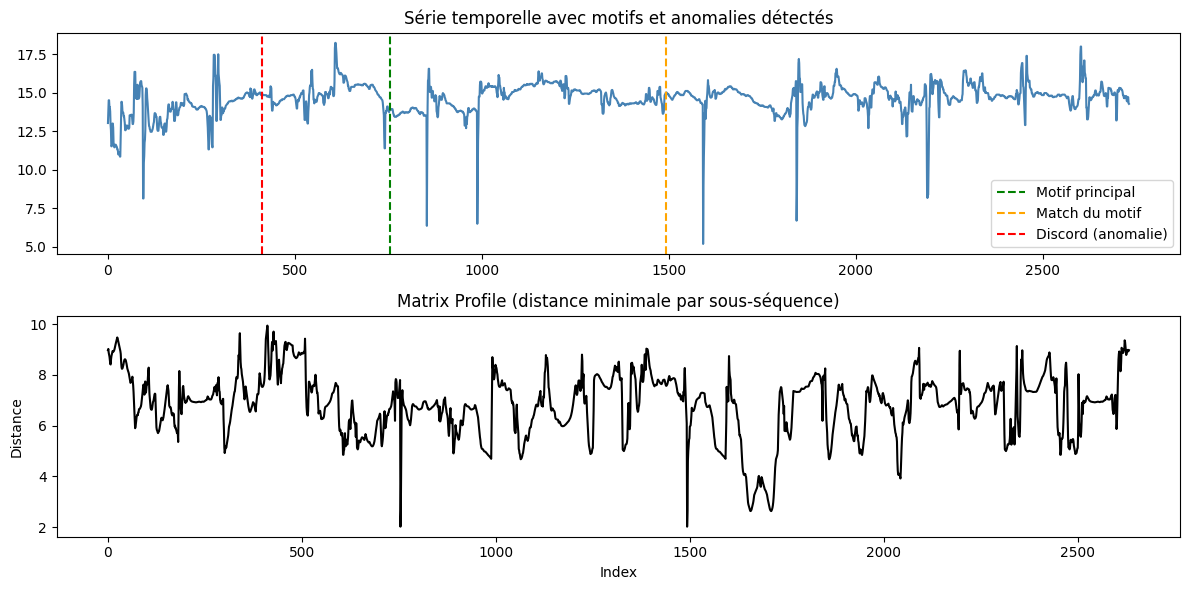

In [ ]:
print("🔍 DIAGNOSTIC DU NETTOYAGE:")
print(f"  Données de départ: {len(dix2_clean)} lignes")
target_col = 'enhanced_speed'

dix2_clean[target_col] = pd.to_numeric(dix2_clean[target_col], errors='coerce')
print(f"  Après conversion numérique: {dix2_clean[target_col].notna().sum()} valeurs non-nulles")

if 'timestamp' in dix2_clean.columns:
    print(f"  Colonne 'timestamp' présente: {dix2_clean['timestamp'].notna().sum()} valeurs non-nulles")
    print(f"  Exemple de valeur timestamp: {dix2_clean['timestamp'].iloc[0]}")
else:
    print(f"  ❌ Colonne 'timestamp' ABSENTE!")

print(f"\n✅ Nettoyage effectué:")
print(f"  - Lignes avant: {len(dix2_clean)}")
print(f"  - Lignes après: {len(dix2_clean)}")
print(f"  - Lignes supprimées: {len(dix2_clean) - len(dix2_clean)}")

if 'timestamp' in dix2_clean.columns:
    print(f"\n🔍 Création de l'index temporel avec 'timestamp'...")
    
    ts_data = dix2_clean[['timestamp', target_col]].copy()
    print(f"  Après sélection colonnes: {len(ts_data)} lignes")
    ts_data = ts_data.dropna()
    print(f"  Après dropna initial: {len(ts_data)} lignes")
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    print(f"  Après conversion datetime: {ts_data['timestamp'].notna().sum()} timestamps valides")
    ts_data = ts_data.dropna()
    print(f"  Après dropna final: {len(ts_data)} lignes")
    
    ts_data = ts_data.set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
    if len(ts_data) > 0:
        print(f"\n⏱️ Plage temporelle de la série :")
        print(f"  Début : {ts_data.index.min()}")
        print(f"  Fin   : {ts_data.index.max()}")
        print(f"  Durée totale : {ts_data.index.max() - ts_data.index.min()}")

    
elif 'timestamp' in dix2_clean.columns:
    ts_data = dix2_clean[['timestamp', target_col]].dropna().copy()
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    ts_data = ts_data.dropna().set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
else:
    ts_data = dix2_clean[[target_col]].dropna().copy()
    ts_data.index = range(len(ts_data))
    print(f"\n✅ Index temporel numérique créé")

print(f"\n{'='*60}")
print(f"RÉSULTAT FINAL: {len(ts_data)} points valides")
print(f"{'='*60}")

if len(ts_data) > 0:
    print(f"\nPremières valeurs de la série:")
    print(ts_data.head())
    print(f"\nStatistiques descriptives:")
    print(ts_data[target_col].describe())
else:
    print("⚠️ ATTENTION: Aucune donnée valide après nettoyage!")
    print("Vérifiez les étapes de diagnostic ci-dessus.")

plt.figure(figsize=(14, 6))
plt.plot(ts_data.index, ts_data[target_col], color='orangered', linewidth=1.5, alpha=0.8)
plt.title(f'Série temporelle: {target_col}', fontsize=16, fontweight='bold')
plt.xlabel('Temps', fontsize=12)
plt.ylabel(f'{target_col} (degrés)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📈 Graphique de la série temporelle affiché")

print("=" * 60)
print("STATISTIQUES DESCRIPTIVES")
print("=" * 60)

stats = {
    'Moyenne': ts_data[target_col].mean(),
    'Médiane': ts_data[target_col].median(),
    'Écart-type': ts_data[target_col].std(),
    'Min': ts_data[target_col].min(),
    'Max': ts_data[target_col].max(),
    'Q1 (25%)': ts_data[target_col].quantile(0.25),
    'Q3 (75%)': ts_data[target_col].quantile(0.75)
}

for key, value in stats.items():
    print(f"{key:15s}: {value:.4f}°")
plt.figure(figsize=(10, 5))
plt.hist(ts_data[target_col], bins=50, color='orangered', edgecolor='black', alpha=0.7)
plt.title(f'Distribution de {target_col}', fontsize=14, fontweight='bold')
plt.xlabel(f'{target_col} (degrés)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if len(ts_data) >= 100:
    print("🔄 Décomposition STL en cours...")
    
    period = min(60, len(ts_data) // 3)
    
    stl = STL(ts_data[target_col], period=period, seasonal=13)
    result = stl.fit()
    
    fig = result.plot()
    fig.set_size_inches(14, 10)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Décomposition STL effectuée (période={period})")
else:
    print(f"⚠️ Série trop courte ({len(ts_data)} points) pour une décomposition STL fiable.")

print("=" * 60)
print("TEST DE STATIONNARITÉ (ADF)")
print("=" * 60)

result_adf = adfuller(ts_data[target_col].dropna())

print(f"\nStatistique ADF: {result_adf[0]:.6f}")
print(f"P-value: {result_adf[1]:.6f}")
print(f"\nValeurs critiques:")
for key, value in result_adf[4].items():
    print(f"  {key}: {value:.3f}")

if result_adf[1] < 0.05:
    print(f"\n✅ La série est STATIONNAIRE (p-value < 0.05)")
else:
    print(f"\n⚠️ La série est NON-STATIONNAIRE (p-value >= 0.05)")
    print("   → Considérer une différenciation ou une transformation")

if len(ts_data) > 30:
    print("📊 Calcul et affichage des fonctions d’autocorrélation...")
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    plot_acf(ts_data[target_col].dropna(), ax=ax[0], lags=40)
    ax[0].set_title("ACF (Autocorrelation Function)")
    
    plot_pacf(ts_data[target_col].dropna(), ax=ax[1], lags=40, method='ywm')
    ax[1].set_title("PACF (Partial Autocorrelation Function)")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Série trop courte pour ACF/PACF fiables.")

print("🔍 Détection des points de rupture dans la série...")

signal = ts_data[target_col].dropna().values
model = "l2"  
algo = rpt.Pelt(model=model).fit(signal)
result = algo.predict(pen=5)

plt.figure(figsize=(14, 5))
plt.plot(signal, color='steelblue')
for cp in result:
    plt.axvline(cp, color='red', linestyle='--', alpha=0.7)
plt.title(f"Change Point Detection sur {target_col}")
plt.show()

print(f"✅ {len(result)-1} ruptures détectées aux indices : {result[:-1]}")

print("🌊 Analyse fréquentielle (Transformée de Fourier)")

y = ts_data[target_col].dropna().values
n = len(y)
timestep = 1  

yf = fft(y - np.mean(y))  
xf = fftfreq(n, timestep)[:n//2]  

plt.figure(figsize=(12, 5))
plt.plot(xf, 2.0/n * np.abs(yf[:n//2]), color='purple')
plt.title("Spectre fréquentiel (FFT)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📉 Calcul des critères d’information (AIC / BIC) via modèle ARIMA...")

try:
    model = ARIMA(ts_data[target_col].dropna(), order=(1, 0, 1))
    result = model.fit()
    
    print(f"AIC : {result.aic:.4f}")
    print(f"BIC : {result.bic:.4f}")
    print(f"L1-norm (somme des valeurs absolues) : {np.sum(np.abs(result.resid)):.4f}")
    print(f"L2-norm (norme quadratique) : {np.sqrt(np.sum(result.resid**2)):.4f}")
    
    plt.figure(figsize=(12, 4))
    plt.plot(result.resid, color='gray', alpha=0.7)
    plt.title("Résidus du modèle ARIMA(1,0,1)")
    plt.grid(True, alpha=0.3)
    plt.show()
except Exception as e:
    print(f"❌ Erreur lors de l’ajustement du modèle ARIMA : {e}")

print("🔁 Autocorrélation globale sur la série...")

plt.figure(figsize=(10, 4))
autocorrelation_plot(ts_data[target_col])
plt.title("Autocorrélation globale")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

y = ts_data[target_col].dropna().values
n = len(y) // 2
segment1, segment2 = y[:n], y[n:2*n]

dist_euclid = euclidean(segment1[:min(len(segment1), len(segment2))],
                        segment2[:min(len(segment1), len(segment2))])

print(f"📏 Distance euclidienne entre les deux segments : {dist_euclid:.4f}")


print("🔍 Calcul du Matrix Profile pour la détection de motifs...")

series = ts_data[target_col].dropna().values.astype(float)

m = 100  

mp = stumpy.stump(series, m=m)


motif_idx = np.argmin(mp[:, 0])
print(f"🏁 Motif principal trouvé à l’indice {motif_idx}")

motif1 = series[motif_idx:motif_idx+m]
motif2 = series[int(mp[motif_idx, 1]):int(mp[motif_idx, 1])+m]


plt.figure(figsize=(12, 5))
plt.plot(motif1, label='Motif 1', color='blue')
plt.plot(motif2, label='Motif 2 (match)', color='red', linestyle='--')
plt.title("🔍 Motifs similaires détectés dans la série")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

discord_idx = np.argmax(mp[:, 0])
print(f"⚠️ Discord (anomalie potentielle) détectée à l’indice {discord_idx}")

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(series, color='steelblue')
plt.axvline(motif_idx, color='green', linestyle='--', label='Motif principal')
plt.axvline(int(mp[motif_idx,1]), color='orange', linestyle='--', label='Match du motif')
plt.axvline(discord_idx, color='red', linestyle='--', label='Discord (anomalie)')
plt.title("Série temporelle avec motifs et anomalies détectés")
plt.legend()

plt.subplot(2,1,2)
plt.plot(mp[:,0], color='black')
plt.title("Matrix Profile (distance minimale par sous-séquence)")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


# Comparaison 6 courses

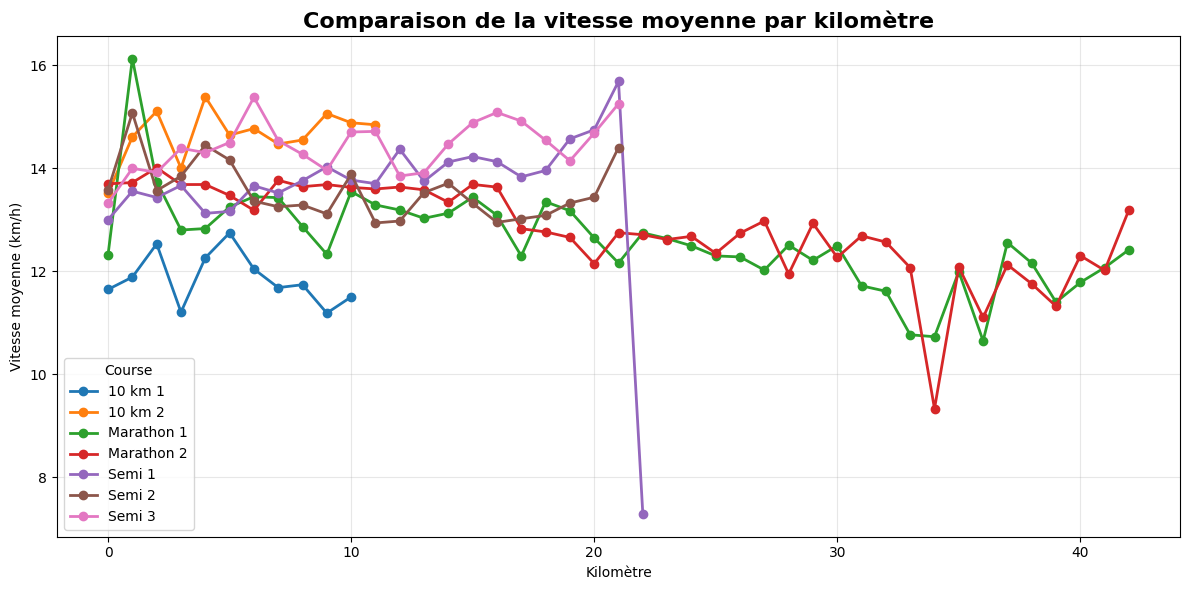

📊 Statistiques de vitesse moyenne (km/h) par course :
             mean   std    min    max
course                               
10 km 1     11.86  0.50  11.19  12.74
10 km 2     14.65  0.50  13.51  15.38
Marathon 1  12.58  0.93  10.65  16.12
Marathon 2  12.80  0.91   9.33  14.01
Semi 1      13.61  1.50   7.29  15.68
Semi 2      13.55  0.56  12.94  15.07
Semi 3      14.44  0.50  13.32  15.37


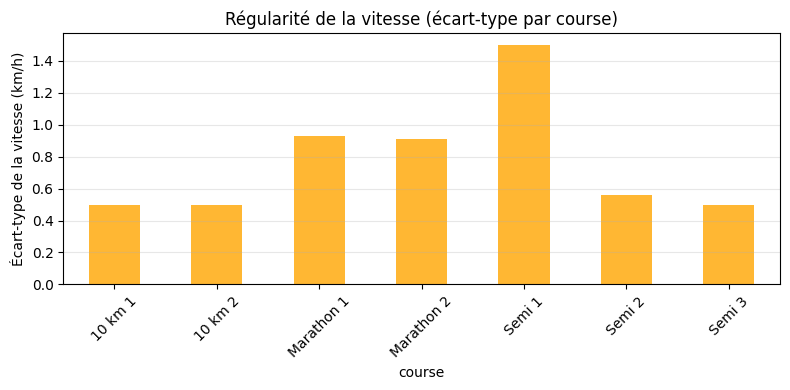

In [ ]:
def get_speed_per_km(df, name):
    """
    Calcule la vitesse moyenne (km/h) pour chaque kilomètre parcouru,
    en utilisant 'distance' comme proxy de la distance (en mètres)
    et 'enhanced_speed' comme vitesse (déjà en km/h).
    """
    df = df.copy()
    
    # Conversion distance → distance cumulée en km
    df['distance_km'] = df['distance'].iloc[:, 0] / 1000

    df = df.dropna(subset=['distance_km', 'enhanced_speed'])
    df = df[(df['enhanced_speed'] > 0) & (df['enhanced_speed'] < 25)] 

    df['km_bin'] = df['distance_km'].astype(int)
    mean_speed = df.groupby('km_bin')['enhanced_speed'].mean()

    return pd.DataFrame({
        'km': mean_speed.index,
        'speed_kmh': mean_speed.values,
        'course': name
    })
dfs = [
    get_speed_per_km(semi1_clean, "Semi 1"),
    get_speed_per_km(semi2_clean, "Semi 2"),
    get_speed_per_km(semi3_clean, "Semi 3"),
    get_speed_per_km(marathon1_clean, "Marathon 1"),
    get_speed_per_km(marathon2_clean, "Marathon 2"),
    get_speed_per_km(dix1_clean, "10 km 1"),
    get_speed_per_km(dix2_clean, "10 km 2")
]

speed_profiles = pd.concat(dfs, ignore_index=True)


plt.figure(figsize=(12, 6))
for name, grp in speed_profiles.groupby('course'):
    plt.plot(grp['km'], grp['speed_kmh'], marker='o', linewidth=2, label=name)

plt.title("Comparaison de la vitesse moyenne par kilomètre", fontsize=16, fontweight='bold')
plt.xlabel("Kilomètre")
plt.ylabel("Vitesse moyenne (km/h)")
plt.grid(True, alpha=0.3)
plt.legend(title="Course", fontsize=10)
plt.tight_layout()
plt.show()

summary = speed_profiles.groupby('course')['speed_kmh'].agg(['mean', 'std', 'min', 'max']).round(2)

print(" Statistiques de vitesse moyenne (km/h) par course :")
print(summary)

plt.figure(figsize=(8, 4))
summary['std'].plot(kind='bar', color='orange', alpha=0.8)
plt.title("Régularité de la vitesse (écart-type par course)")
plt.ylabel("Écart-type de la vitesse (km/h)")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## Corrélation FC vs Vitesse vs Altitude

In [ ]:
def analyse_correlation(df, course_name):
    """
    Calcule et affiche les corrélations entre :
      - vitesse (enhanced_speed)
      - fréquence cardiaque (heart_rate)
      - altitude (elevation_gain ou altitude)
    """
    cols_needed = ['enhanced_speed', 'heart_rate', 'altitude']
    for col in cols_needed:
        if col not in df.columns:
            raise ValueError(f"❌ Colonne '{col}' absente dans {course_name}")

    df = df.copy()
    df = df.dropna(subset=cols_needed)
    df = df[(df['enhanced_speed'] > 0) & (df['heart_rate'] > 40) & (df['altitude'] > 0)]

    corr_speed_hr = df['enhanced_speed'].corr(df['heart_rate'])
    corr_speed_alt = df['enhanced_speed'].corr(df['altitude'])

    print(f"📊 Corrélations pour {course_name}:")
    print(f"  ➕ Corr(vitesse, fréquence cardiaque) = {corr_speed_hr:.3f}")
    print(f"  ➖ Corr(vitesse, altitude) = {corr_speed_alt:.3f}\n")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Vitesse vs Fréquence cardiaque
    sns.regplot(
        x='heart_rate', y='enhanced_speed', data=df,
        ax=axes[0], scatter_kws={'alpha':0.4}, line_kws={'color':'red'}
    )
    axes[0].set_title(f"{course_name} — Corr(vitesse, fréquence cardiaque) = {corr_speed_hr:.2f}")
    axes[0].set_xlabel("Fréquence cardiaque (bpm)")
    axes[0].set_ylabel("Vitesse (km/h)")
    axes[0].grid(alpha=0.3)

    # Vitesse vs Altitude
    sns.regplot(
        x='altitude', y='enhanced_speed', data=df,
        ax=axes[1], scatter_kws={'alpha':0.4}, line_kws={'color':'red'}
    )
    axes[1].set_title(f"{course_name} — Corr(vitesse, altitude) = {corr_speed_alt:.2f}")
    axes[1].set_xlabel("Altitude (m)")
    axes[1].set_ylabel("Vitesse (km/h)")
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Détection d’un éventuel seuil de saturation cardiaque -> repris dans l'autre notebook avec le score de fatigue
    df_sorted = df.sort_values('heart_rate')
    df_sorted['rolling_speed'] = df_sorted['enhanced_speed'].rolling(window=30).mean()

    plt.figure(figsize=(10,4))
    plt.plot(df_sorted['heart_rate'], df_sorted['rolling_speed'], color='dodgerblue')
    plt.title(f"{course_name} — Relation vitesse vs fréquence cardiaque (moyenne glissante)")
    plt.xlabel("Fréquence cardiaque (bpm)")
    plt.ylabel("Vitesse (km/h)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return corr_speed_hr, corr_speed_alt


📊 Corrélations pour Marathon 1:
  ➕ Corr(vitesse, fréquence cardiaque) = 0.367
  ➖ Corr(vitesse, altitude) = 0.154



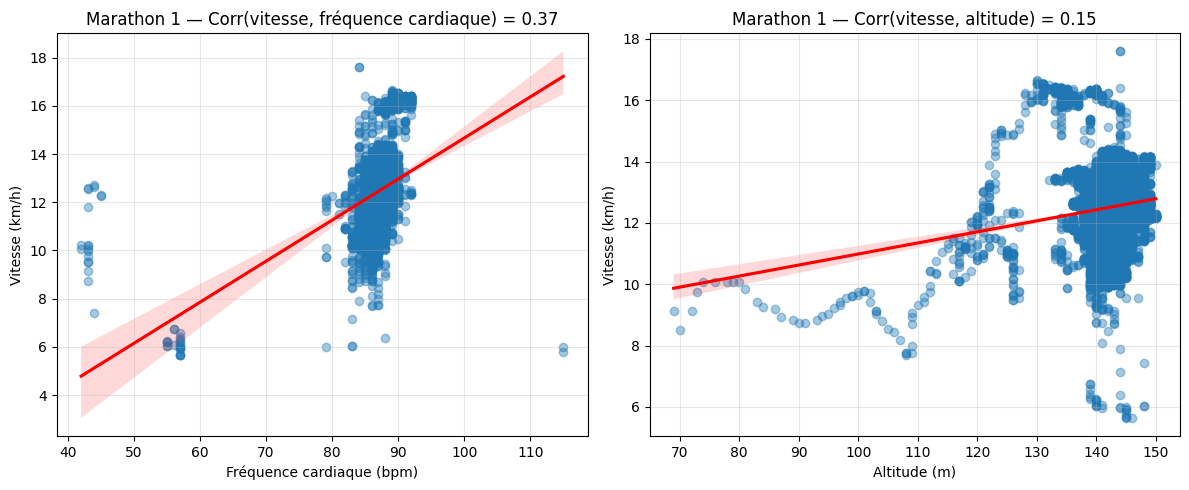

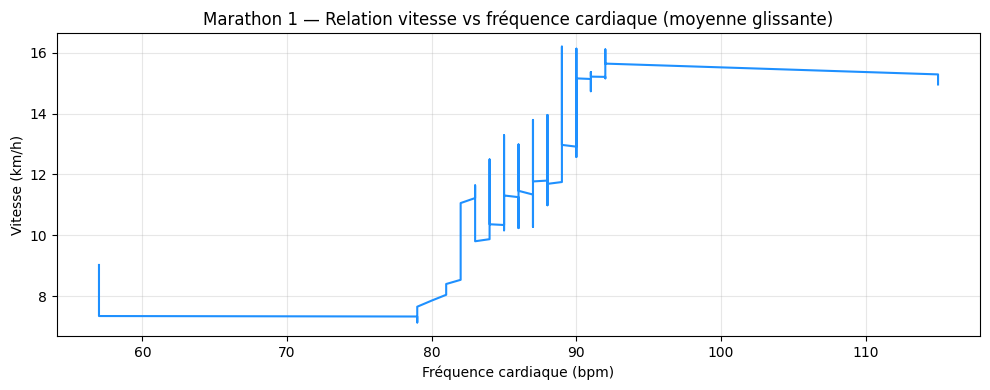

📊 Corrélations pour Marathon 2:
  ➕ Corr(vitesse, fréquence cardiaque) = 0.909
  ➖ Corr(vitesse, altitude) = -0.174



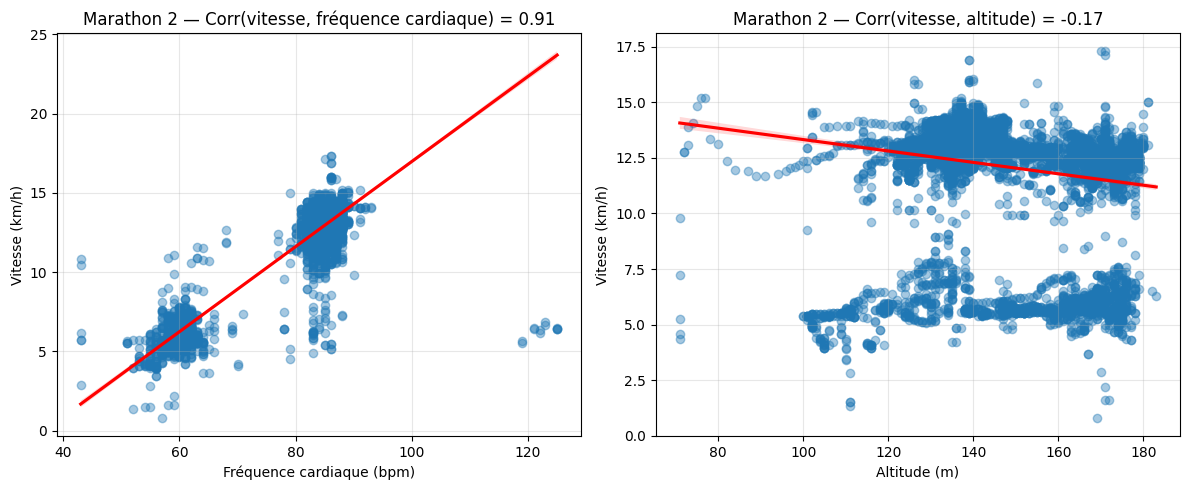

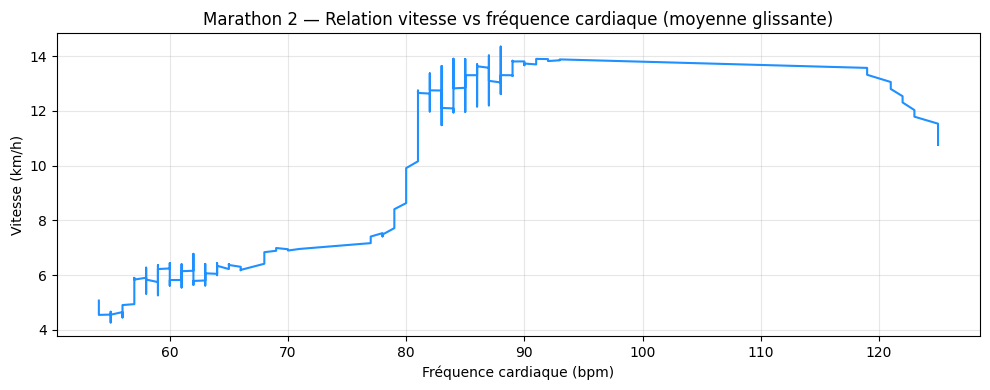

📊 Corrélations pour 10 km 1:
  ➕ Corr(vitesse, fréquence cardiaque) = 0.415
  ➖ Corr(vitesse, altitude) = 0.169



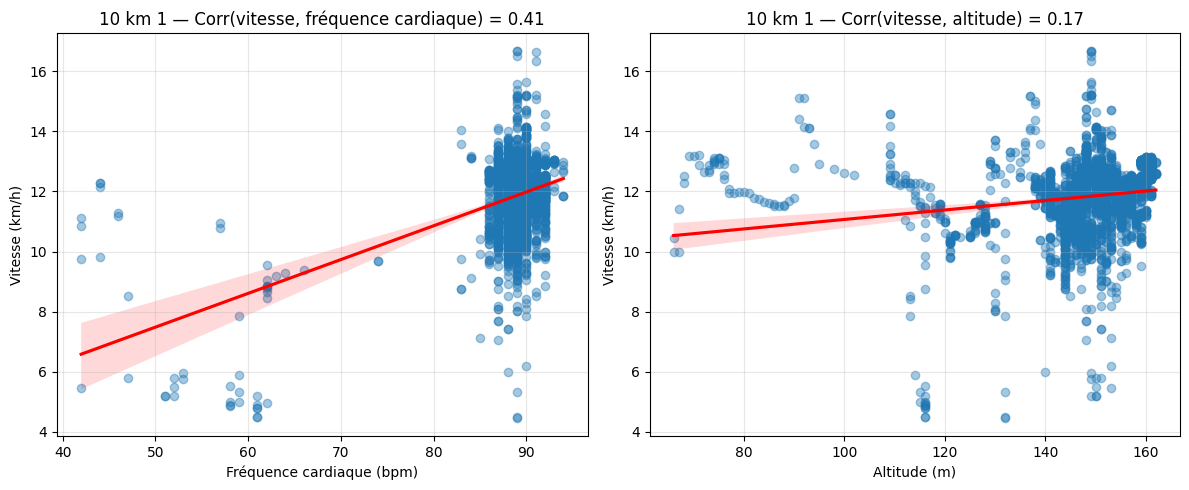

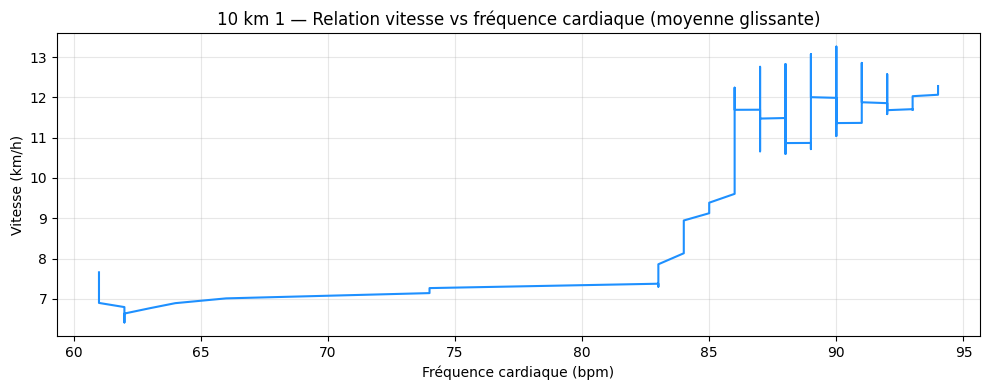

📊 Corrélations pour 10 km 2:
  ➕ Corr(vitesse, fréquence cardiaque) = 0.236
  ➖ Corr(vitesse, altitude) = 0.286



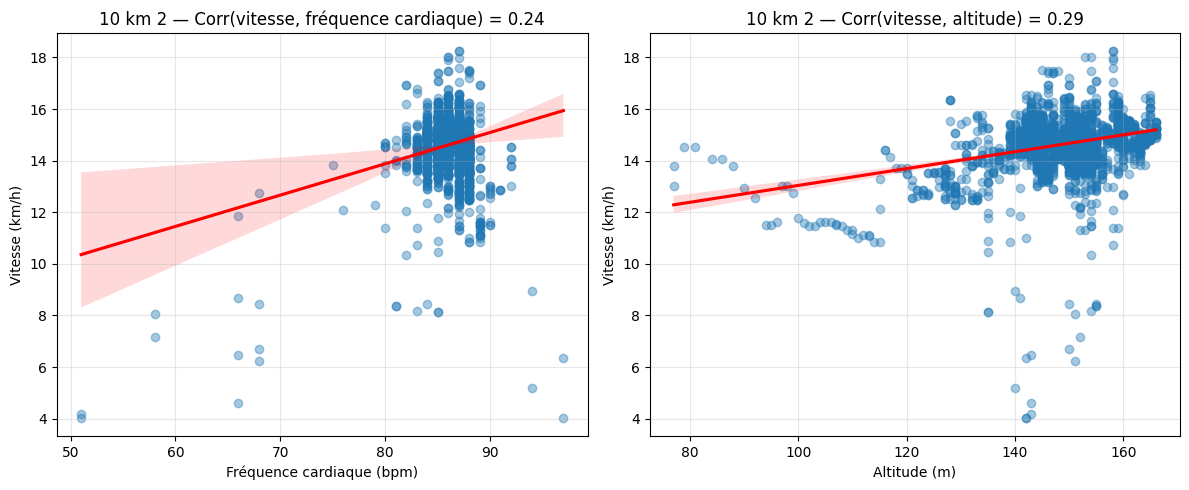

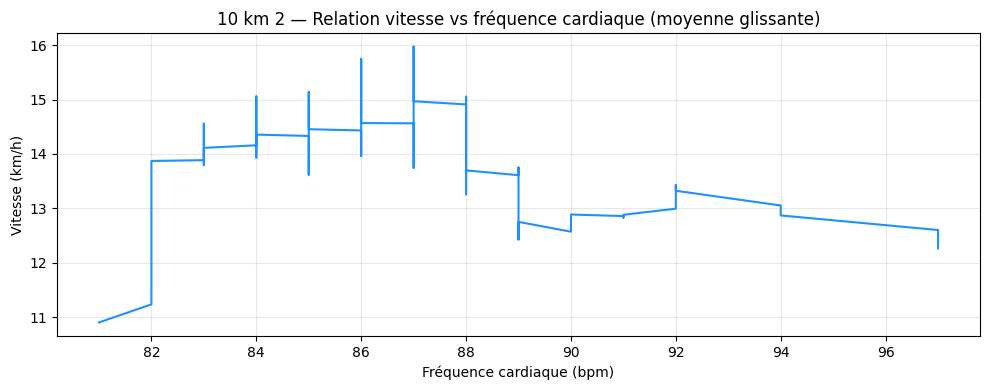

📊 Corrélations pour Semi 1:
  ➕ Corr(vitesse, fréquence cardiaque) = 0.532
  ➖ Corr(vitesse, altitude) = -0.045



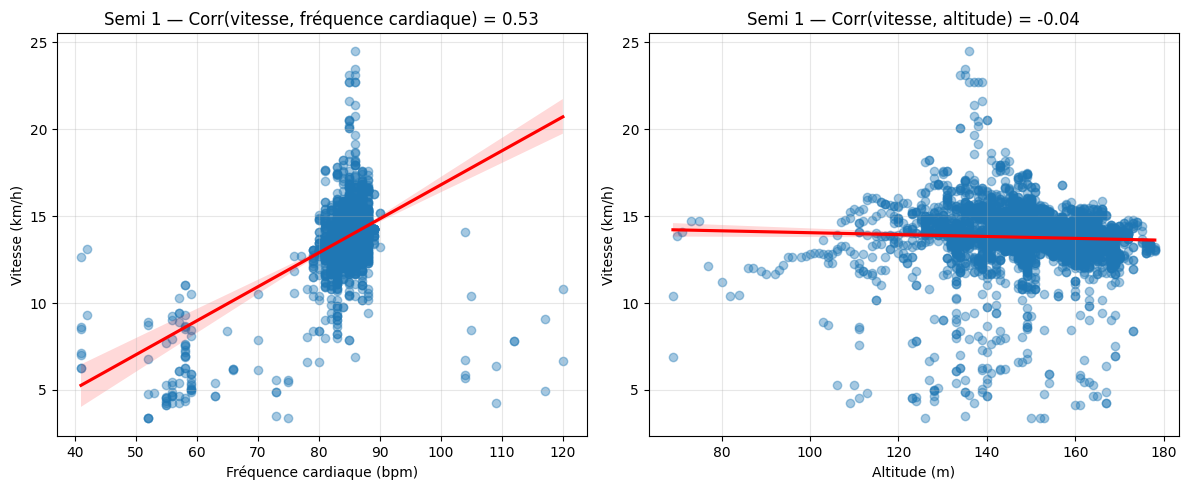

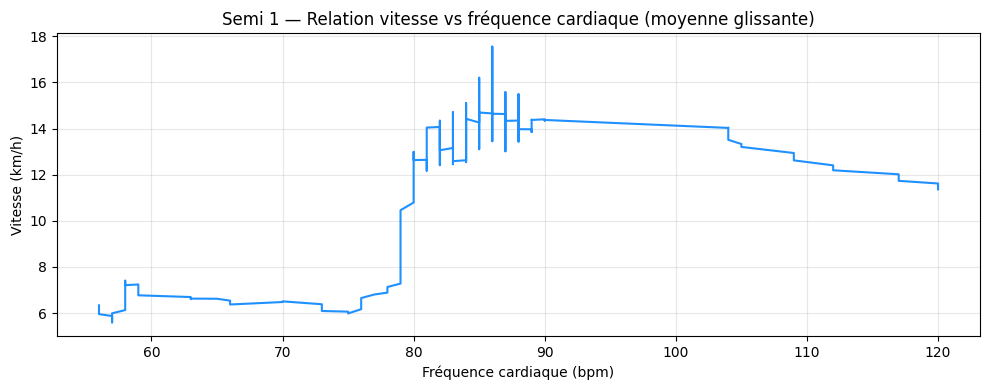

📊 Corrélations pour Semi 2:
  ➕ Corr(vitesse, fréquence cardiaque) = 0.331
  ➖ Corr(vitesse, altitude) = 0.100



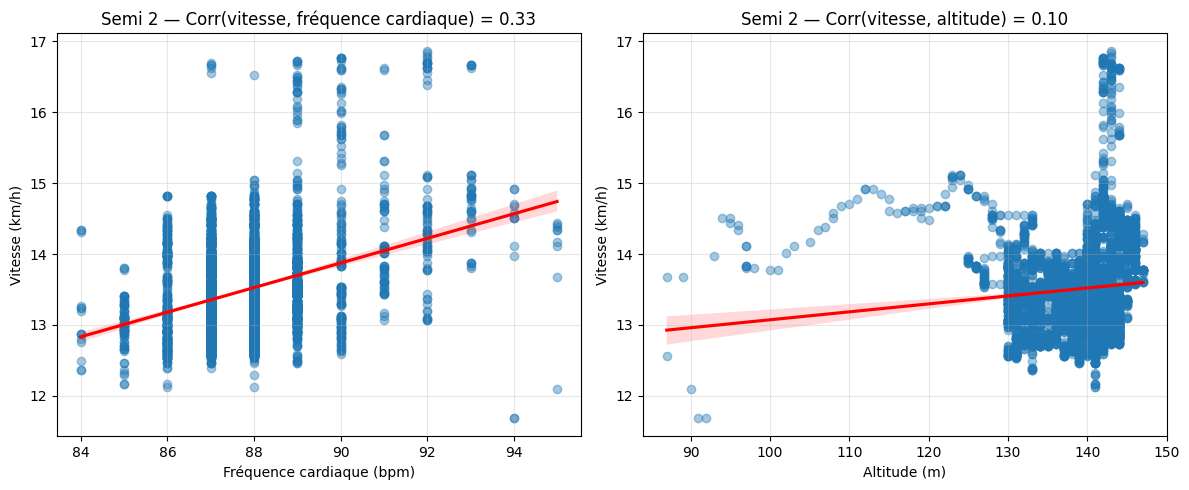

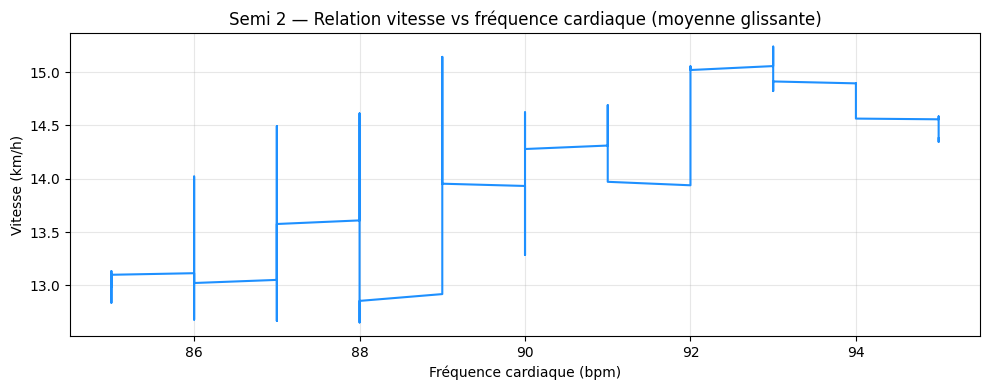

📊 Corrélations pour Semi 3:
  ➕ Corr(vitesse, fréquence cardiaque) = 0.641
  ➖ Corr(vitesse, altitude) = 0.186



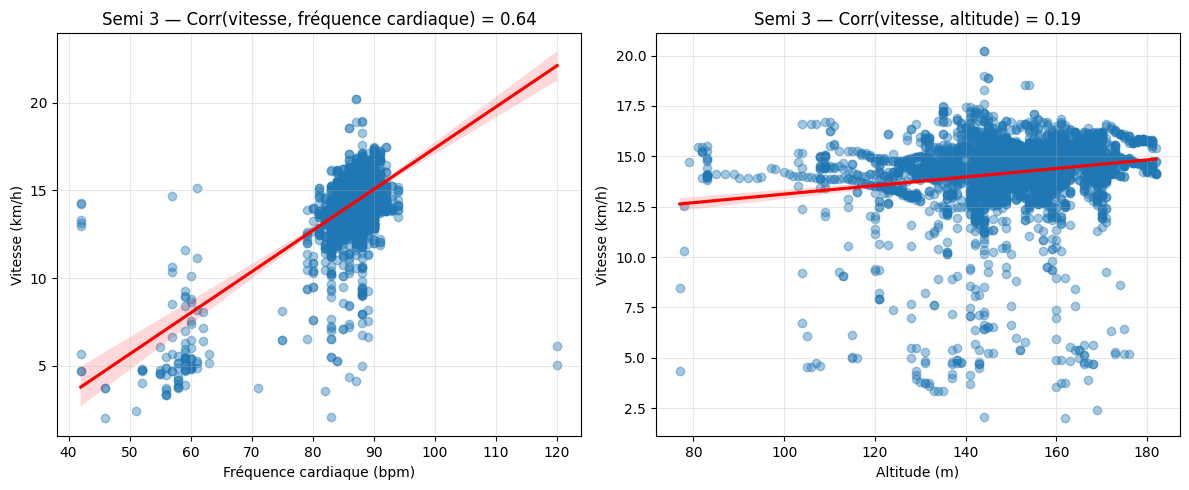

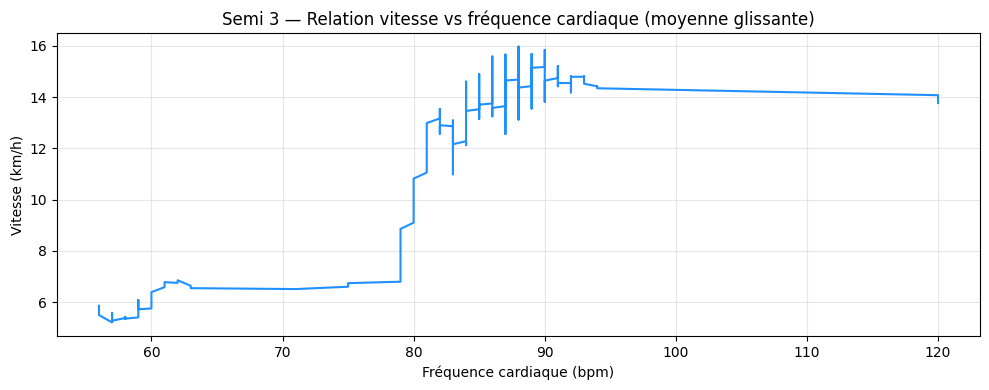

In [ ]:
corr_m1 = analyse_correlation(marathon1, "Marathon 1")
corr_m2 = analyse_correlation(marathon2, "Marathon 2")
corr_10k1 = analyse_correlation(dix1, "10 km 1")
corr_10k2 = analyse_correlation(dix2, "10 km 2")
corr_s1 = analyse_correlation(semi1, "Semi 1")
corr_s2 = analyse_correlation(semi2, "Semi 2")
corr_s3 = analyse_correlation(semi3, "Semi 3")


## Détection de fatigue

In [ ]:
#Voir autre notebook, plus concluant
FCM = 115 
SEUIL_FATIGUE = 0.9 * FCM       
DUREE_SEUIL = 3 * 60          

def detect_fatigue(df, course_name):
    """
    Détecte les périodes où le rythme cardiaque dépasse 90% FCM
    pendant plus de 5 minutes consécutives.
    Indique ensuite la baisse de vitesse moyenne.
    """
    cols_needed = ['timestamp', 'heart_rate', 'right_power_phase_peak']
    for c in cols_needed:
        if c not in df.columns:
            raise ValueError(f"❌ Colonne manquante : {c} dans {course_name}")
    data = df[['timestamp', 'heart_rate', 'right_power_phase_peak']].dropna().copy()
    data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
    data = data.sort_values('timestamp')
    
    data['is_fatigue_zone'] = data['heart_rate'] > SEUIL_FATIGUE
    data['fatigue_group'] = (data['is_fatigue_zone'] != data['is_fatigue_zone'].shift()).cumsum()

    fatigue_segments = []
    for grp, subset in data.groupby('fatigue_group'):
        if subset['is_fatigue_zone'].iloc[0]:
            duration = (subset['timestamp'].iloc[-1] - subset['timestamp'].iloc[0]).total_seconds()
            if duration >= DUREE_SEUIL:
                avg_speed = subset['right_power_phase_peak'].mean()
                fatigue_segments.append({
                    'start': subset['timestamp'].iloc[0],
                    'end': subset['timestamp'].iloc[-1],
                    'duration_sec': duration,
                    'avg_speed': avg_speed
                })
    plt.figure(figsize=(12, 6))
    plt.plot(data['timestamp'], data['right_power_phase_peak'], label='Vitesse (km/h)', color='steelblue')
    plt.plot(data['timestamp'], data['heart_rate'] / 10, label='Fréquence cardiaque (bpm /10)', color='red', alpha=0.6)
    
    for seg in fatigue_segments:
        plt.axvspan(seg['start'], seg['end'], color='orange', alpha=0.3, label='Fatigue détectée')
    
    plt.title(f"🩸 Simulation de la fatigue — {course_name}")
    plt.xlabel("Temps")
    plt.ylabel("Valeurs (km/h et bpm/10)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    print(f"Résultats pour {course_name} :")
    if fatigue_segments:
        for i, seg in enumerate(fatigue_segments, 1):
            print(f"⚠️ Segment {i}:")
            print(f"   - Début      : {seg['start']}")
            print(f"   - Fin        : {seg['end']}")
            print(f"   - Durée      : {seg['duration_sec']/60:.1f} minutes")
            print(f"   - Vitesse moy: {seg['avg_speed']:.2f} km/h\n")
    else:
        print("✅ Aucune période de fatigue prolongée détectée (cardio < 90% FCM).")

    return fatigue_segments


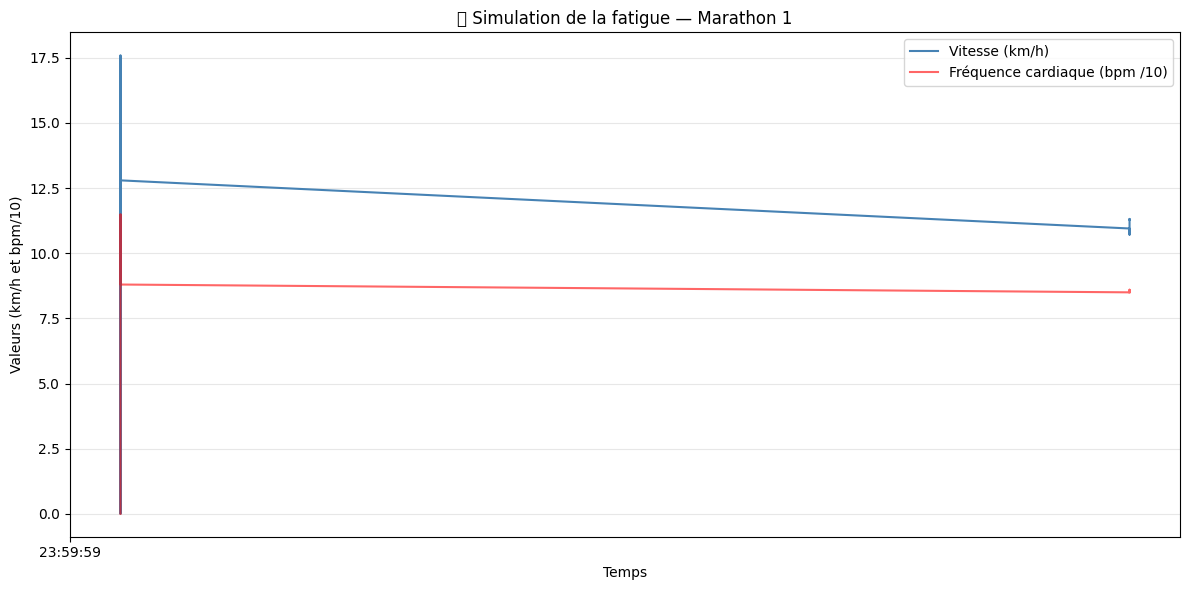

Résultats pour Marathon 1 :
✅ Aucune période de fatigue prolongée détectée (cardio < 90% FCM).


In [62]:
fatigue_marathon1 = detect_fatigue(marathon1, "Marathon 1")